# Status + LTD

In this file, I analyze the repeated simulations on WikiElections. 
Simulations in the range that is suspected to give the proper results were repeated 5 times and their length was extended to 2000 steps. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines
import pandas as pd
import scipy.special
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [3]:
outputs_dir_test = Path("../../outputs/LtdStatus/outputs/test2")
# outputs_dir = Path("../../outputs/LtdStatus/outputs/anal")
# outputs_dir_new = Path("../../outputs/LtdStatus/outputs/n100")
# outputs_dir_sepa = Path("../../outputs/LtdStatus/outputs/sepa_0_2")
outputs_dir_triads_slash = Path("../../outputs/LtdReal/outputs/slash-s400-triads")
outputs_dir_triads_wiki = Path("../../outputs/LtdReal/outputs/wiki-s400-triads")
outputs_dir_triads_wiki1000 = Path("../../outputs/LtdReal/outputs/wiki-s1000-triads")
# outputs_dir_triads_long = Path("../../outputs/LtdStatus/outputs/triads_distr_long")
# outputs_dir_triads_n100 = Path("../../outputs/LtdStatus/outputs/triads_distr_n100")
outputs_dir_triads_wiki2 = Path("../../outputs/LtdReal/outputs/wiki2-s400-triads")
outputs_dir_triads_wiki2_1000 = Path("../../outputs/LtdReal/outputs/wiki2-s1000-triads")
outputs_wiki_rhoinits_2000 = Path("../../outputs/LtdReal/outputs/wiki2-rhoinits-triads-s2000")
outputs_wiki_rhoinits = Path("../../outputs/LtdReal/outputs/wiki2-rhoinits-triads")

# Phase transition details

In [4]:
"""These functions present analytical solutions for the model. 
The parameter `label` can be one of the two values: Adam or Piotr. 
When it is Adam the `q` parameter is as it is in the paper, that is
it is the probability of the status dynamics. 
"""


def get_pb_crit(q, ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    """
    if label == "adam":
        q = 1-q
    return ((2*q + (1-q)*(1-2*ph))**2 / (8*q**2) + 1)/2

def get_rho_crit(q,ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    Basic assumption: pb_crit>0.5
    """
    if label == "adam":
        q = 1-q
    return 2*q/(2*q + (1-q)*(1-2*ph))

def get_pb_when_rho_eq_1(q, ph, label="adam"):
    """This function doesn't check if such pb exists. 

    Args:
        q (_type_): _description_
        ph (_type_): _description_
        label (str, optional): _description_. Defaults to "adam".
    """
    if label == "adam":
        q = 1-q
    return (3*q + (1-2*ph)*(1-q)) / (4*q)

def Delta(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (2 *q + (1 -q)*(1 -2 *ph))** 2 - 4*(4 *pb *q -2 *q) *q

def afun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (4 *pb *q -2 *q)
def bfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return -2 *q - (1 -q)*(1 -2 *ph)
def cfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return q

def get_rhos(pb,ph,q, label="adam"):
    a = afun(pb, ph, q, label=label)
    b = bfun(pb, ph, q, label=label)
    c = cfun(pb, ph, q, label=label)
    
    if a == 0:
        return (-c / b, )
    
    d = Delta(pb, ph, q, label=label)
    if d < 0:
        if np.round(d, decimals = 15) < 0:
            return (np.nan, )
        else:
            d = np.round(d, decimals = 15)
    
    rho1 = (-b  - np.sqrt(d)) / 2 /a
    rho2 = (-b  + np.sqrt(d)) / 2 /a
    return sorted([rho1, rho2])
# rho2(pb,ph,q) = (2q + (1-q)(1-2ph) + sqrt(Delta(pb,ph,q))) / 2*(4pb*q-2q)

def get_quasi_rho(pb,ph,q, label="adam"):
    """Returns one value which is the level of quasi-stationary state if such a level exists. 
    Otherwise returns np.NaN

    Args:
        pb (_type_): _description_
        ph (_type_): _description_
        q (_type_): _description_
    """
    rhos = get_rhos(pb,ph,q, label=label)
    
    if len(rhos) == 1:
        if np.isnan(rhos[0]):
            return np.NaN
        elif (rhos[0] <= 1) & (rhos[0] >= 0):
            return rhos[0]
        else:
            return np.NaN
    
    if (rhos[0] <= 1) & (rhos[0] >= 0):
        if rhos[0] < rhos[1]: #rhos[0] is in proper range and is smaller. 
            rho_exp = rhos[0]
        elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and is smaller. 
            rho_exp = rhos[1]
        else: #rhos[0] is in proper range and rhos[1] is not. 
            rho_exp = rhos[0]
    elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and rhos[0] is not. 
        rho_exp = rhos[1]
    else:
        rho_exp = np.NaN
        
    return rho_exp

def get_separatrix(pbs, ph, q, label="adam"):
    """Returns rho values of separatrix (if exists) for given parameters

    Args:
        pbs (list or numpy.array): pb values
        ph (float): probabiilty ph
        q (float): probability q
    """
    
    rho_crits = np.zeros(len(pbs))
    for i, pb in enumerate(pbs):
        rhos_crit = get_rhos(pb, ph, q, label=label)
        
        no_sep_value = True
        if len(rhos_crit) == 2:
            if 0 < rhos_crit[0] < 1:
                if 0 < rhos_crit[1] < 1:
                    no_sep_value = False
                    rho_crits[i] = rhos_crit[1]
        if no_sep_value:
            rho_crits[i] = np.nan
    return rho_crits

def get_quasi_q(rho, pb, ps):
    """Returns value of q in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    val = 2*(2*pb - 1)*rho**2 - 2*rho+1
    return val/(val + (1-2*ps)*rho)

def get_quasi_pb(rho, ps, q):
    """Returns value of pb in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    return 1/2 * (((2*(1-q) + (1-2*ps)*q)*rho - (1-q)) / (2*(1-q)*rho**2) + 1)

def get_quasi_ps(rho, pb, q):
    """Returns value of ps in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    return 1/2 * ((1-q)/q * (2*rho - 2*(2*pb-1)*rho**2 - 1)/rho + 1)



def find_parameters(rho = -1., q = -1., ps = -1., pb = -1.):
    """The user should specify 3 parameters. The value of the 4th one will be returned. 
    The forth parameter will be such that the system will be in quasi-stationary state. 

    Args:
        rho (_type_, optional): _description_. Defaults to -1..
        q (_type_, optional): _description_. Defaults to -1..
        ps (_type_, optional): _description_. Defaults to -1..
        pb (_type_, optional): _description_. Defaults to -1..
    """
    pars = np.array([rho, q, ps, pb])
    count_m1 = sum(pars == -1)
    if count_m1 != 1:
        # print(pars)
        raise ValueError("One should define exactly 3 parameters. ", pars)
    if rho == -1.:
        return get_quasi_rho(pb,ps,q)
    elif q == -1.:
        return get_quasi_q(rho, pb,ps)
    elif ps == -1.:
        return get_quasi_ps(rho, pb,q)
    elif pb == -1.:
        return get_quasi_pb(rho,ps,q)
        
""" Let us test above functions
"""
qh = 0.5
psh = 0.7
pbh = 0.5
rhoh = find_parameters(q = qh, ps = psh, pb=pbh)

qh2 = find_parameters(rho = rhoh, ps = psh, pb=pbh)
psh2 = find_parameters(rho = rhoh, q = qh, pb=pbh)
pbh2 = find_parameters(rho = rhoh, ps = psh, q=qh)
assert(abs(qh2 - qh) < 1e-5)
assert(abs(psh2 - psh) < 1e-5)
assert(abs(pbh2 - pbh) < 1e-5)

## Process data

In [5]:
import os, ast

def process_data(data, n_links, n_triads, k=1):
    for column in data.columns[k:-2]:
        data.loc[:, column] = data[column].str.split(',').map(lambda x: [int(float(x_el))/n_triads for x_el in x])
    data.loc[:, 'rho'] = data['rho'].str.split(',').map(lambda x: [int(float(x_el))/n_links for x_el in x])
    return data

def means_of_data(data, start, steps):
    df = pd.DataFrame(columns=data.columns)
    for _, row in data.iterrows():
        df = df.append(pd.DataFrame({
        'prob': row.p,
        'rho': row.rho[start:][::steps],
        'n0': row.n0[start:][::steps],
        'n1': row.n1[start:][::steps],
        'n2': row.n2[start:][::steps],
        'n3': row.n3[start:][::steps]
        }))
    df = df.groupby('prob').mean()
    return df

def get_rho_init(filename):
    with open(filename) as f:
        first_line = f.readline()
        spl = first_line.split("--rho-init', '")
        if len(spl) == 1:
            return 0.5
        else:
            strval = spl.split("'")[0]
            return float(strval)
        
def read_params(filename):
    # print("Started " + filename)
    params_d = {}
    with open(filename) as f:
        first_line = f.readline()
        # firstline = "# Commit: 126356fd51d619772e0c4137e13dfe116d309ebe# Arguments: ['main.py', 'LtdStatus', '-n', '100', '-p', '0.88', '-q', '0.5', '-ps', '0.25', '-s', '100', '-r', '1', '--rho-init', '0.9', '--ltd-agent-based', '--on-triad-status', 'outputs/test']"
        params = first_line.split("Arguments: ")[1]
        # params.strip('][').strip("'").split(', ')
        try:
            params = ast.literal_eval(params)
            isvalue = False
            last_key = ""
            for par in params:
                if par.startswith('--'):
                    if isvalue:
                        isvalue = False
                        # params_d[last_key] = True
                if not isvalue:
                    if par.startswith('--'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = True
                        isvalue = True
                        last_key = par2
                    elif par.startswith('-'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = np.NAN
                        isvalue = True
                        last_key = par2
                else:
                    isvalue = False
                    try:
                        if "." in par:
                            params_d[par2] = float(par)
                        else:
                            params_d[par2] = int(par)
                    except ValueError:
                        pass
        except (SyntaxError, ValueError):
            # print(params)
            # print(params == "Namespace(command=None, dataset='../data/wikielections/wikielections_triads2.h5', network=<networktools.network_generators.real_graphs.GeneralRealNetwork object at 0x7f1f70ffcfa0>, is_directed=True, agent_based=True, ltd_agent_based=True, on_triad_status=True, save_pk_distribution=False, build_triad='choose_agents', exp_name='outputs/wiki2-s1000-triads', probability=[0.8], q=[0.0], psprob=[0.1], rho_init=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001], steps=1000, saving_multiplier=10, repetitions=1, no_triad_stats=False, keep_rho_at=[0.67, 0.9, 0.65, 0.92])")
            # print(ord(params[-1]))
            params = params.split("Namespace(")[1]
            params = params[:-1]
            if params[-1] == ")":
                params = params[:-1]
            params = params.split(',')
            params = list(map(lambda x: x.strip(), params))
            """Following is needed in the case some parameters are given as lists."""
            i = len(params) - 1
            while i >= 1:
                if '=' not in params[i]:
                    params[i-1] = ','.join(params[i-1:i+1])
                    params.pop(i)
                i -= 1
            params = list(map(lambda x: x.split('='), params))
            keys = [param[0] for param in params]
            vals = [param[1] for param in params]
            for key, val in zip(keys, vals):
                if key == "steps":
                    key = "s"
                elif key == "n_agents":
                    key = "n"
                if val.startswith("'"):
                    params_d[key] = val
                    continue
                if val.startswith("["):
                    val = ast.literal_eval(val)
                    if len(val) == 1:
                        val = round(val[0],10)
                    else:
                        val = [round(v,10) for v in val]
                    # val = val[1:-1]
                    params_d[key] = val
                else:
                    try:
                        val = ast.literal_eval(val)
                        if val:
                            val = round(val,10)
                            params_d[key] = val
                    except SyntaxError:     
                        try:
                            params_d[key] = int(val)
                        except ValueError:
                            try:
                                if val:
                                    # print(val)
                                    val = round(val,10)
                                    params_d[key] = float(val)
                            except (ValueError, TypeError):
                                pass
    
    if "dataset" in params_d:
        if "wikielections" in params_d["dataset"].lower():
            if "wikielections_triads2" in params_d["dataset"].lower():
                params_d["triads"] = 745129
                params_d["links"] = 94933
            else:
                params_d["triads"] = 747589
                params_d["links"] = 95152
            params_d["dataset"] = "wikielections"
        elif "slashdot" in params_d["dataset"].lower():
            params_d["dataset"] = "slashdot"
            params_d["triads"] = 1251925
            params_d["links"] = 285003
            
    return params_d

def process_folder(directory, no_triad_stats = True):
    files = [os.path.join(directory, dir, "outputs.tsv") for dir in os.listdir(directory) if os.path.isdir(os.path.join(directory, dir)) ]
    
    df_cols = ['q','p', 'ps', 'rho_init', 'steps', 'cur_steps', 'rho']
    usecols = ['q','p', 'ps', 'rho_init', 'rho']
    # usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    if not no_triad_stats:
    #     usecols = ['q','p', 'ps', 'rho', 'bp']
    #     usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    # else:
        for i in range(8):
            df_cols.append('tr' + str(i))
            usecols.append('tr' + str(i))
    
    df = pd.DataFrame({col: [] for col in df_cols})
    # usecols = ['q','p', 'ps', 'rho', 'bp']
    # usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    empty_folds = np.ones(len(files))
    reps = np.zeros(len(files), dtype = int)
    
    for i, file in enumerate(files):
        # if not os.path.isdir(file):
        #     continue
        
        inilen = len(df)
        df2 = df.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols))
        
        if type(np.array(df2.rho)[-1]) != str:
            if np.isnan(np.array(df2.rho)[-1]):
                """There is most likely error in columns. rho values are in another column"""
                df3 = pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup)
                # df3.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup))
                df3_len = len(df3)
                df2_len = inilen+df3_len
                # print(df3)
                # print(df3_len)
                # print(df3.tr0.iloc[-df3_len:-1])
                # print(df3.tr0)
                # return df3, df2
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'rho'] = df3["tr0"]
                # df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'bp'] = df3["tr1"]
                # print(df2)
                # for i, row in enumerate(df3.iterrows()):
                #     df2.rho.iloc[-i] = df3.tr0.iloc[-i]
                #     df2.bp.iloc[-i] = df3.tr1.iloc[-i]
        df = df2
        
        endlen = len(df)
        
        reps[i] = endlen - inilen
        
        if inilen == endlen:
            empty_folds[i] = False
    
    dicts = [read_params(file) for i, file in enumerate(files)]# if empty_folds[i] == 1]
    
    # rho_inits_one = [round(d["rho_init"], 6) if "rho_init" in d else 0.5 for d in dicts]
    steps_one = [d["s"] for d in dicts]
    
    # rho_inits = [rho_init for rho_init, rep in zip(rho_inits_one, reps) for _ in range(0,rep)]
    steps = [step for step, rep in zip(steps_one, reps) for _ in range(0,rep)]
    # print(df)
    # return df, rho_inits
    # df.rho_init = rho_inits
    df.steps = steps
    
    ms_one = [d["saving_multiplier"] if "saving_multiplier" in d else 1 for d in dicts]
    ms = [m for m, rep in zip(ms_one, reps) for _ in range(0,rep)]

    cur_steps = [[*list(range(0,step, m)), step] for m, step in zip(ms, steps)]
    
    df.cur_steps = cur_steps
    
    df = df.dropna().reset_index()
    
    if "n" in dicts[0]:
        Ls_one = [d["n"]*(d["n"] - 1) for d in dicts]
    elif "dataset" in dicts[0]:
        Ls_one = [d["links"] for d in dicts]
    else:
        raise ValueError("Neither number of nodes nor dataset was given.", dicts[0])
    Ls = [L for L, rep in zip(Ls_one, reps) for _ in range(0,rep)]
    df.rho = np.array(df.rho.str.split(',').map(lambda x: [float(x_el) for x_el in x]))
    df["Lplus"] = df.rho
    df.rho = [np.array(rho) / L for rho, L in zip(df.rho, Ls)]
    
    possibly_shorter = [d["keep_rho_at"][:2] != [0.,1.] if "keep_rho_at" in d else False  for d in dicts]
    possibly_shorters = [p for p, rep in zip(possibly_shorter, reps) for _ in range(0,rep)]
    
    """Correcting number of cur_steps for old simulations"""
    for ind, row in df.iterrows():
        if possibly_shorters[ind]:
            if len(row.rho) != len(row.cur_steps):
                df.at[ind, "cur_steps"] = row.cur_steps[0:len(row.rho)]
                # row.cur_steps = 
        else:
            if len(row.rho) != len(row.cur_steps):
                df.iloc[ind].cur_steps.pop()
            if len(row.rho) != len(row.cur_steps):
                raise ValueError("Wrong lengths")
    
    if not no_triad_stats:
        if "n" in dicts[0]:
            Ts_one = [d["n"]*(d["n"] - 1)*(d["n"] - 2) for d in dicts]
        elif "dataset" in dicts[0]:
            Ts_one = [d["triads"] for d in dicts]
        else:
            raise ValueError("Neither number of nodes nor dataset was given.", dicts[0])
        Ts = [T for T, rep in zip(Ts_one, reps) for _ in range(0,rep)]
        for i in range(8):
            col = 'tr' + str(i)
            df[col] = np.array(df[col].str.split(',').map(lambda x: [float(x_el) for x_el in x]))
            df[col] = [np.array(Ni) / T for Ni, T in zip(df[col], Ts)]
    
    return df

def group_results(df, cols):
    """group results according to (q,p,ps,rho_init,steps) anc check the outcome

    Args:
        df (_type_): _description_
    """
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        paradise = np.sum([rho[-1] == 1. for rho in df_temp.rho])
        quasi_stat = np.sum([rho[-1] < rho_crit for rho in df_temp.rho])
        other = np.array(reps) - paradise - quasi_stat
        
        paradise_ratio = paradise / (paradise + quasi_stat)
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "paradise": paradise, "quasi_stat": quasi_stat, "other": other, "paradise_ratio": paradise_ratio})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'paradise', 'quasi_stat', 'other', 'paradise_ratio'])
    

In [6]:
params_d = {}

params = "# Commit: 5676e68a584e7dbe23e09291c633e45bc0c4ff0f# Arguments: Namespace(command=None, dataset='../data/wikielections/wikielections_triads2.h5', network=<networktools.network_generators.real_graphs.GeneralRealNetwork object at 0x7f93ef024a10>, is_directed=True, agent_based=True, ltd_agent_based=True, on_triad_status=True, save_pk_distribution=False, build_triad='choose_agents', exp_name='outputs/wiki2-rhoinits-triads', probability=[0.5], q=[0.9000000000000001], psprob=[0.7000000000000001], rho_init=[0.7, 0.6, 0.5, 0.4, 0.2, 0], steps=1000, saving_multiplier=10, repetitions=1, no_triad_stats=False, keep_rho_at=[0.67, 0.9, 0.65, 0.92])"
# params = "Namespace(command=None, dataset='../data/wikielections/wikielections_triads2.h5', network=, is_directed=True, agent_based=True, ltd_agent_based=True, on_triad_status=True, save_pk_distribution=False, build_triad='choose_agents', exp_name='outputs/wiki2-s1000-triads', probability=[0.8], q=[0.0], psprob=[0.1], rho_init=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001], steps=1000, saving_multiplier=10, repetitions=1, no_triad_stats=False, keep_rho_at=[0.67, 0.9, 0.65, 0.92])"
# params = "# Commit: f3c93320bb5fb828bc8f1522d79a9a00258d7700# Arguments: Namespace(command=None, dataset='../data/wikielections/wikielections_triads2.h5', network=<networktools.network_generators.real_graphs.GeneralRealNetwork object at 0x7f1f70ffcfa0>, is_directed=True, agent_based=True, ltd_agent_based=True, on_triad_status=True, save_pk_distribution=False, build_triad='choose_agents', exp_name='outputs/wiki2-s1000-triads', probability=[0.8], q=[0.0], psprob=[0.1], rho_init=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001], steps=1000, saving_multiplier=10, repetitions=1, no_triad_stats=False, keep_rho_at=[0.67, 0.9, 0.65, 0.92])\n"

params = params.split("Arguments: ")[1]
print(params)
print(params == "Namespace(command=None, dataset='../data/wikielections/wikielections_triads2.h5', network=<networktools.network_generators.real_graphs.GeneralRealNetwork object at 0x7f1f70ffcfa0>, is_directed=True, agent_based=True, ltd_agent_based=True, on_triad_status=True, save_pk_distribution=False, build_triad='choose_agents', exp_name='outputs/wiki2-s1000-triads', probability=[0.8], q=[0.0], psprob=[0.1], rho_init=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001], steps=1000, saving_multiplier=10, repetitions=1, no_triad_stats=False, keep_rho_at=[0.67, 0.9, 0.65, 0.92])")
params = params.split("Namespace(")[1]
params = params[:-1]
if params[-1] == ")":
    params = params[:-1]
params = params.split(',')
params = list(map(lambda x: x.strip(), params))
"""Following is needed in the case some parameters are given as lists."""
i = len(params) - 1
while i >= 1:
    if '=' not in params[i]:
        params[i-1] = ','.join(params[i-1:i+1])
        params.pop(i)
    i -= 1
params = list(map(lambda x: x.split('='), params))
keys = [param[0] for param in params]
vals = [param[1] for param in params]
for key, val in zip(keys, vals):
    if key == "steps":
        key = "s"
    elif key == "n_agents":
        key = "n"
    if val.startswith("'"):
        params_d[key] = val
        continue
    if val.startswith("["):
        val = ast.literal_eval(val)
        if len(val) == 1:
            val = round(val[0],10)
        else:
            val = [round(v,10) for v in val]
        # val = val[1:-1]
        params_d[key] = val
    else:
        try:
            params_d[key] = ast.literal_eval(val)
        except SyntaxError:     
            try:
                params_d[key] = int(val)
            except ValueError:
                try:
                    params_d[key] = float(val)
                except ValueError:
                    pass
            
params_d

Namespace(command=None, dataset='../data/wikielections/wikielections_triads2.h5', network=<networktools.network_generators.real_graphs.GeneralRealNetwork object at 0x7f93ef024a10>, is_directed=True, agent_based=True, ltd_agent_based=True, on_triad_status=True, save_pk_distribution=False, build_triad='choose_agents', exp_name='outputs/wiki2-rhoinits-triads', probability=[0.5], q=[0.9000000000000001], psprob=[0.7000000000000001], rho_init=[0.7, 0.6, 0.5, 0.4, 0.2, 0], steps=1000, saving_multiplier=10, repetitions=1, no_triad_stats=False, keep_rho_at=[0.67, 0.9, 0.65, 0.92])
False


{'command': None,
 'dataset': "'../data/wikielections/wikielections_triads2.h5'",
 'is_directed': True,
 'agent_based': True,
 'ltd_agent_based': True,
 'on_triad_status': True,
 'save_pk_distribution': False,
 'build_triad': "'choose_agents'",
 'exp_name': "'outputs/wiki2-rhoinits-triads'",
 'probability': 0.5,
 'q': 0.9,
 'psprob': 0.7,
 'rho_init': [0.7, 0.6, 0.5, 0.4, 0.2, 0],
 's': 1000,
 'saving_multiplier': 10,
 'repetitions': 1,
 'no_triad_stats': False,
 'keep_rho_at': [0.67, 0.9, 0.65, 0.92]}

In [7]:
files = [os.path.join(outputs_wiki_rhoinits, dir, "outputs.tsv") for dir in os.listdir(outputs_wiki_rhoinits) if os.path.isdir(os.path.join(outputs_wiki_rhoinits, dir)) ]
# files = [os.path.join(directory, dir, "outputs.tsv") for dir in os.listdir(directory) if os.path.isdir(dir)]
read_params(files[1])

{'dataset': 'wikielections',
 'is_directed': 1,
 'agent_based': 1,
 'ltd_agent_based': 1,
 'on_triad_status': 1,
 'build_triad': "'choose_agents'",
 'exp_name': "'outputs/wiki2-rhoinits-triads'",
 'probability': 0.7,
 'q': 0.95,
 'psprob': 0.0,
 'rho_init': [0.9, 0.8, 0.6, 0.4, 0.2, 0],
 's': 1000,
 'saving_multiplier': 10,
 'repetitions': 1,
 'keep_rho_at': [0.67, 0.9, 0.65, 0.92],
 'control_initial_rho': 1,
 'triads': 745129,
 'links': 94933}

In [8]:
# df, rho_inits = process_folder(outputs_dir_test)
df_wrho = process_folder(outputs_wiki_rhoinits_2000, no_triad_stats=False)
print(len(df_wrho))
df_wrho_copy = df_wrho.copy(deep=True)
# df_wrho = df_wrho[df_wrho.rho_init >= 0]
# df_wrho = df_wrho.reset_index(drop=True)
df_wrho

14278


,index,q,p,ps,rho_init,steps,cur_steps,rho,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,Lplus
0,0,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9008669272012894, 0.6499952598148168]","[0.000908567509786896, 0.07524468917462614]","[0.008874973326766239, 0.09504528746029212]","[0.008924629158172612, 0.06673072716267921]","[0.0804719719672701, 0.1642735687377622]","[0.008815923148877577, 0.07054080568599531]","[0.08087324476701349, 0.07358457394625628]","[0.08029884758209652, 0.15913754531094615]","[0.7308318425400165, 0.2954428025214426]","[85522.0, 61706.0]"
1,1,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9017517617688264, 0.6499952598148168]","[0.0008669639753653394, 0.07548357398517572]","[0.008359626319737924, 0.09397567401080886]","[0.008420018547124056, 0.06630529747198136]","[0.08041560588837637, 0.16322140193174606]","[0.00827776130039228, 0.06933967138576005]","[0.07890043200573324, 0.07223313010230444]","[0.07838240089970998, 0.16187666833528155]","[0.7363771910635608, 0.297564582776942]","[85606.0, 61706.0]"
2,2,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9022363140320016, 0.6499952598148168]","[0.0009582233411932699, 0.07660552736506028]","[0.008747478624506628, 0.09569081326857497]","[0.008768951416466142, 0.06581008120741509]","[0.0801190129494356, 0.1685627589316749]","[0.00877297756495855, 0.07073406081363093]","[0.07990831117833289, 0.07374025168796275]","[0.07964124332833644, 0.1546644943358801]","[0.7330838015967704, 0.29419201238980097]","[85652.0, 61706.0]"
3,3,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9006141173248502, 0.6499952598148168]","[0.0009904325291325395, 0.07465016124724712]","[0.008661587456668576, 0.09525330513239989]","[0.009056150008924629, 0.06845123461843519]","[0.08110541933007573, 0.1659444203621118]","[0.009108489939325943, 0.07057569897292952]","[0.08147850909037227, 0.07519905949171217]","[0.08179523277177508, 0.15771765694262335]","[0.7278041788737252, 0.29220846323254096]","[85498.0, 61706.0]"
4,4,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.8997924852264229, 0.6499952598148168]","[0.001164898963803583, 0.07614252028843328]","[0.00976877829208097, 0.09622629101806533]","[0.009650677936303647, 0.06884579717069125]","[0.08700506892095194, 0.1703584211592892]","[0.009138015028270273, 0.07033949826137488]","[0.08149192958534697, 0.07310680432515712]","[0.08162345043609899, 0.15593541520998377]","[0.7201571808371436, 0.2890452525670052]","[85420.0, 61706.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14273,10,0.775,0.7,1.0,0.2,2000,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.1994037900413976, 0.7450939083353523, 0.833...","[0.5123421582034788, 0.019165808873362868, 0.0...","[0.1267015510066042, 0.05521862657338528, 0.01...","[0.1281885418498005, 0.017680160079664057, 0.0...","[0.03160526566540827, 0.09323620473770314, 0.0...","[0.12908637296360764, 0.06460357870918995, 0.0...","[0.03184415047595785, 0.11061306163093908, 0.0...","[0.03197701337620734, 0.1058716007563791, 0.07...","[0.008254946458935299, 0.5336109586393766, 0.7...","[18930.0, 70734.0, 79083.0, 82406.0, 84097.0, ..."
14274,11,0.775,0.7,1.0,0.2,2000,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.19997261226338575, 0.7442406750023701, 0.83...","[0.5097332139803981, 0.021148015981125416, 0.0...","[0.13013988181912126, 0.05870392911831374, 0.0...","[0.12795099908874838, 0.019706654820843102, 0....","[0.03299160279629433, 0.09800048045372009, 0.0...","[0.12688943793624996, 0.06404260201924768, 0.0...","[0.0320977978309796, 0.10892207926412742, 0.07...","[0.03197164517821746, 0.10553474633251424, 0.0...","[0.008225421369990969, 0.5239414920101083, 0.7...","[18984.0, 70653.0, 79090.0, 82246.0, 83919.0, ..."
14275,12,0.775,0.7,1.0,0.2,2000,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.2016580114396469, 0.7489281914613464, 0.837...","[0.5064223778701407, 0.018952423003265207, 0.0...","[0.13029019136283784, 0.05669890716909421, 0.0...","[0.12903403303320632, 0.018492100025633146, 0....","[0.032601066392530686, 0.098734581528

In [9]:
# # df, rho_inits = process_folder(outputs_dir_test)
# df_w1000 = process_folder(outputs_dir_triads_wiki2_1000, no_triad_stats=False)
# print(len(df_w1000))
# df_w1000_copy = df_w1000.copy(deep=True)
# df_w1000 = df_w1000[df_w1000.rho_init >= 0]
# df_w1000 = df_w1000.reset_index(drop=True)
# df_w1000.head()

In [10]:
# frames = [df_wrho, df_w1000]

# df_joined = pd.concat(frames)
# df_joined = df_joined.reset_index()
# df_joined

(array([85460., 87551., 87974., 88197.]), 61706.450000000004, 87338.36)

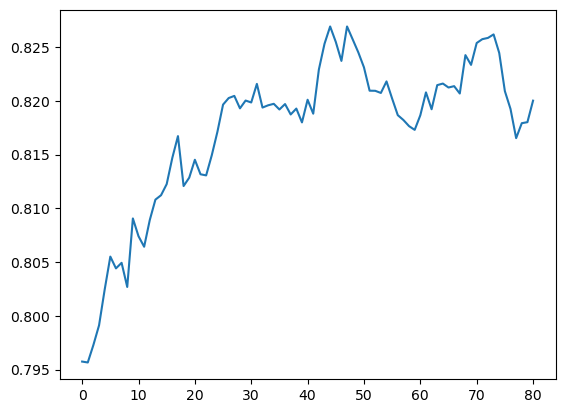

In [11]:
plt.plot(df_wrho.loc[421].rho[20:])

df_wrho.loc[418].rho[:10] * 94933, 94933*0.65, 94933*0.92

# Read real data

In [12]:
realnet_path = Path('../../../triad-statistics/results_realnet2.h5')
results_realnet = pd.read_hdf(realnet_path)
results_realnet

# wikielections

,wiki elections,slashdot,epinions
tr0,0.012461,1.236096e-02,7.488967e-03
tr1,0.027505,5.186732e-02,2.700950e-02
tr2,0.010724,1.451844e-02,4.778784e-03
tr3,0.072158,2.477065e-02,1.890176e-02
tr4,0.049625,2.027677e-02,2.477050e-02
tr5,0.065085,2.038621e-02,1.184566e-02
tr6,0.077725,2.977175e-02,2.997776e-02
tr7,0.684716,8.260479e-01,8.752271e-01
T,745129.000000,1.251925e+06,1.096199e+07
L_plus,75446.000000,2.213970e+05,5.830880e+05


In [13]:
results_realnet.loc["tr0"]

wiki elections    0.012461
slashdot          0.012361
epinions          0.007489
Name: tr0, dtype: float64

In [14]:
results_realnet['wiki elections']

tr0            0.012461
tr1            0.027505
tr2            0.010724
tr3            0.072158
tr4            0.049625
tr5            0.065085
tr6            0.077725
tr7            0.684716
T         745129.000000
L_plus     75446.000000
L          94933.000000
rho            0.794729
Tr0         9285.000000
Tr1        20495.000000
Tr2         7991.000000
Tr3        53767.000000
Tr4        36977.000000
Tr5        48497.000000
Tr6        57915.000000
Tr7       510202.000000
Name: wiki elections, dtype: float64

In [15]:
pd.DataFrame(results_realnet['wiki elections']).transpose()

,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,T,L_plus,L,rho,Tr0,Tr1,Tr2,Tr3,Tr4,Tr5,Tr6,Tr7
wiki elections,0.012461,0.027505,0.010724,0.072158,0.049625,0.065085,0.077725,0.684716,745129.0,75446.0,94933.0,0.794729,9285.0,20495.0,7991.0,53767.0,36977.0,48497.0,57915.0,510202.0


In [16]:
# wiki = pd.DataFrame()

# d = {}

# for i in range(8):
#     lab = "tr" + str(i)
#     d[lab] = results_realnet.loc[lab]['wiki elections']
#     # print(results_realnet.loc[lab].epinions)

# wiki = wiki.append(d, ignore_index=True)
# # epinions.rho = 0.794
# wiki = wiki.assign(rho=0.7947289140762432)
# wiki
wiki = pd.DataFrame(results_realnet['wiki elections']).transpose()
wiki

,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,T,L_plus,L,rho,Tr0,Tr1,Tr2,Tr3,Tr4,Tr5,Tr6,Tr7
wiki elections,0.012461,0.027505,0.010724,0.072158,0.049625,0.065085,0.077725,0.684716,745129.0,75446.0,94933.0,0.794729,9285.0,20495.0,7991.0,53767.0,36977.0,48497.0,57915.0,510202.0


In [17]:
# epinions = pd.DataFrame()

# d = {}

# for i in range(8):
#     lab = "tr" + str(i)
#     d[lab] = results_realnet.loc[lab].epinions
#     # print(results_realnet.loc[lab].epinions)

# epinions = epinions.append(d, ignore_index=True)
# # epinions.rho = 0.794
# epinions = epinions.assign(rho=0.0)
# epinions

In [18]:
# slash = pd.DataFrame()

# d = {}

# for i in range(8):
#     lab = "tr" + str(i)
#     d[lab] = results_realnet.loc[lab].slashdot
#     # print(results_realnet.loc[lab].epinions)

# slash = slash.append(d, ignore_index=True)
# # epinions.rho = 0.794
# slash = slash.assign(rho=0.777)
# slash

slash = pd.DataFrame(results_realnet['slashdot']).transpose()
slash

,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,T,L_plus,L,rho,Tr0,Tr1,Tr2,Tr3,Tr4,Tr5,Tr6,Tr7
slashdot,0.012361,0.051867,0.014518,0.024771,0.020277,0.020386,0.029772,0.826048,1251925.0,221397.0,285003.0,0.776823,15475.0,64934.0,18176.0,31011.0,25385.0,25522.0,37272.0,1034150.0


# Error functions

That are used in finding parameters closest to real network stats. 

In [19]:

# n2_triads = ["tr1", "tr2", "tr4"]
# n1_triads = ["tr3", "tr5", "tr6"]
# deg_triads = [*n1_triads, *n2_triads]
# all_triads = ["tr" + str(i) for i in range(8)]

# # def normalize(data):
# #     triads = ["tr" + str(i) for i in range(8)]
# #     if data.shape[0] > 1:
# #         if data.shape[1] > 1:
# #             return data[triads].values.transpose() / np.sum(data[triads], axis=1).values
# #     return ValueError("Not implemented")

# def transform_data(data, triads = None, triads_groups = None):
#     if triads_groups is None:
#         T = len(triads)
#         if data.shape[0] > 1:
#             if (len(data.shape) > 1) and (data.shape[1] > 1):
#                 return data[triads].values.transpose() / np.sum(data[triads], axis=1).values - 1/T
#             else:
#                 return data[triads] / np.sum(data[triads]) - 1/T
#         else:
#             return data[triads] / np.sum(data[triads], axis=1).values[0] - 1/T
#     else:
#         if type(data) == pd.DataFrame:
#             df = data.copy(deep=True)
#             for triads in triads_groups:
#                 nn = transform_data(data, triads)
                
#                 if np.where(np.array(nn.shape) == 3)[0][0] == 0:
#                     nn = nn.transpose()

#                 new_df = pd.DataFrame(nn, index = data.index, columns=triads)
#                 df.update(new_df)
#             df = df.drop(columns=['tr0', 'tr7'])
#             return df
#         else:
#             raise ValueError("Not implemented")

# def closest_to_six_triads(original_data, model_data):
#     if type(original_data) == pd.DataFrame:
#         if type(model_data) == np.ndarray:
#             err = np.sum((model_data[deg_triads].transpose() - original_data[deg_triads].values)**2, axis=1)
#             return err
#         elif type(model_data) == pd.DataFrame:
#             err = np.sum(model_data[deg_triads].subtract(original_data[deg_triads].values)**2, axis=1)
#             return err
    
#     err = 0
#     for triad in deg_triads:
#         err += (original_data[triad] - model_data[triad])**2
#     return err

# def closest_to_six_triads_transformed(original_data, model_data, is_data_transformed = False):
#     if is_data_transformed:
#         return closest_to_six_triads(original_data, model_data)
    
#     p1_r = transform_data(original_data, n1_triads)
#     p1_m = transform_data(model_data, n1_triads)
#     p2_r = transform_data(original_data, n2_triads)
#     p2_m = transform_data(model_data, n2_triads)
    
#     err = np.sum((p1_r - p1_m)**2, axis = 1).values[0]
#     err += np.sum((p2_r - p2_m)**2, axis = 1).values[0]
    
#     return err

# def closest_to_four_triads(original_data, model_data):
#     triads = ["tr1", "tr2", "tr5", "tr6"]
    
#     if type(original_data) == pd.DataFrame:
#         if type(model_data) == np.ndarray:
#             err = np.sum((model_data[triads].transpose() - original_data[triads].values)**2, axis=1)
#             return err
#         elif type(model_data) == pd.DataFrame:
#             err = np.sum(model_data[triads].subtract(original_data[triads].values)**2, axis=1)
#             return err
    
#     err = np.sum((original_data[triads] - model_data[triads])**2, axis = 1).values[0]
#     return err

# def closest_to_four_triads_transformed(original_data, model_data, is_data_transformed = False):
#     if is_data_transformed:
#         return closest_to_four_triads(original_data, model_data)
    
#     p1_r = transform_data(original_data, n1_triads)
#     p1_m = transform_data(model_data, n1_triads)
#     p2_r = transform_data(original_data, n2_triads)
#     p2_m = transform_data(model_data, n2_triads)
    
#     triads2 = ["tr1", "tr2"]
#     triads1 = ["tr5", "tr6"]
    
#     err = np.sum((p1_r[triads1] - p1_m[triads1])**2, axis = 1).values[0]
#     err += np.sum((p2_r[triads2] - p2_m[triads2])**2, axis = 1).values[0]
    
#     return err

# def closest_to_high_underrepresentation(original_data, model_data):
#     triads = ["tr2"]
    
#     if type(original_data) == pd.DataFrame:
#         if type(model_data) == np.ndarray:
#             err = np.sum((model_data[triads].transpose() - original_data[triads].values)**2, axis=1)
#             return err
#         elif type(model_data) == pd.DataFrame:
#             err = np.sum(model_data[triads].subtract(original_data[triads].values)**2, axis=1)
#             return err
    
#     err = 0
#     err += (original_data["tr2"] - model_data["tr2"])**2
#     return err

# def closest_to_high_underrepresentation_transformed(original_data, model_data, is_data_transformed = False):
#     if is_data_transformed:
#         return closest_to_high_underrepresentation(original_data, model_data)
    
#     # p1_r = transform_data(original_data, n1_triads)
#     # p1_m = transform_data(model_data, n1_triads)
#     p2_r = transform_data(original_data, n2_triads)
#     p2_m = transform_data(model_data, n2_triads)
    
#     err = 0
#     err += np.sum((p2_r["tr2"] - p2_m["tr2"])**2)
#     return err

# def closest_to_rho(original_data, model_data):
#     if type(original_data) == pd.DataFrame:
#         if type(model_data) == pd.DataFrame:
#             err = model_data["rho"].subtract(original_data["rho"].values[0])**2
#             return err
    
#     err = 0
#     err += (original_data["rho"] - model_data["rho"])**2
#     return err


# """New error functions"""

# """Assuming we must have proper sign of deviations. """

# def closest_to_six_triads_corrdevs_transformed(original_data, model_data, is_data_transformed = False):
#     if is_data_transformed:
        
#         err = closest_to_four_triads(original_data, model_data)
#         err += np.sum(model_data[deg_triads] * (original_data[deg_triads].values)  > 0, axis = 1) != 6
#         return err
    
#     raise ValueError("Not implemented")

#     p1_r = transform_data(original_data, n1_triads)
#     p1_m = transform_data(model_data, n1_triads)
#     p2_r = transform_data(original_data, n2_triads)
#     p2_m = transform_data(model_data, n2_triads)
    
#     err = np.sum((p1_r - p1_m)**2, axis = 1).values[0]
#     err += np.sum((p2_r - p2_m)**2, axis = 1).values[0]
    
#     return err

# def closest_to_four_triads_corrdevs_transformed(original_data, model_data, is_data_transformed = False):
#     if is_data_transformed:
#         triads = ["tr1", "tr2", "tr5", "tr6"]
#         err = closest_to_four_triads(original_data, model_data)
#         err += np.sum(model_data[triads] * (original_data[triads].values)  > 0, axis = 1) != 4
#         return err
    
#     raise ValueError("Not implemented")
    
#     p1_r = transform_data(original_data, n1_triads)
#     p1_m = transform_data(model_data, n1_triads)
#     p2_r = transform_data(original_data, n2_triads)
#     p2_m = transform_data(model_data, n2_triads)
    
#     triads2 = ["tr1", "tr2"]
#     triads1 = ["tr5", "tr6"]
    
#     err = np.sum((p1_r[triads1] - p1_m[triads1])**2, axis = 1).values[0]
#     err += np.sum((p2_r[triads2] - p2_m[triads2])**2, axis = 1).values[0]
    
#     return err


# """Combination of triad densities and rho"""

# def closest_to_six_triads_rho(original_data, model_data, rho_factor = 5):
#     return closest_to_six_triads(original_data, model_data) + closest_to_rho(original_data, model_data) * rho_factor

# def closest_to_six_triads_rho_transformed(original_data, model_data, is_data_transformed = False, rho_factor = 5):
#     return closest_to_six_triads_transformed(original_data, model_data, is_data_transformed) + closest_to_rho(original_data, model_data) * rho_factor

# def closest_to_four_triads_rho(original_data, model_data, rho_factor = 5):
#     return closest_to_four_triads(original_data, model_data) + closest_to_rho(original_data, model_data) * rho_factor

# def closest_to_four_triads_rho_transformed(original_data, model_data, is_data_transformed = False, rho_factor = 5):
#     return closest_to_four_triads_transformed(original_data, model_data, is_data_transformed) + closest_to_rho(original_data, model_data) * rho_factor

# error_functions = [closest_to_rho, closest_to_high_underrepresentation, closest_to_high_underrepresentation_transformed, 
#                    closest_to_four_triads, closest_to_four_triads_transformed, closest_to_six_triads, closest_to_six_triads_transformed]
# error_functions.extend([closest_to_six_triads_corrdevs_transformed, closest_to_four_triads_corrdevs_transformed, 
#                         closest_to_six_triads_rho, closest_to_six_triads_rho_transformed, closest_to_four_triads_rho, closest_to_four_triads_rho_transformed])

# error_functions_names = []
# for error_function in error_functions:
#     error_functions_names.append(error_function.__name__)

# # error_functions = [closest_to_rho, closest_to_high_underrepresentation, closest_to_high_underrepresentation_transformed, 
# #                    closest_to_four_triads, closest_to_four_triads_transformed, closest_to_six_triads, closest_to_six_triads_transformed]

In [20]:

n2_triads = ["tr1", "tr2", "tr4"]
n1_triads = ["tr3", "tr5", "tr6"]
deg_triads = [*n1_triads, *n2_triads]
all_triads = ["tr" + str(i) for i in range(8)]

# def normalize(data):
#     triads = ["tr" + str(i) for i in range(8)]
#     if data.shape[0] > 1:
#         if data.shape[1] > 1:
#             return data[triads].values.transpose() / np.sum(data[triads], axis=1).values
#     return ValueError("Not implemented")

def transform_data(data, triads = None, triads_groups = None):
    if triads_groups is None:
        T = len(triads)
        if data.shape[0] > 1:
            if data.shape[1] > 1:
                return data[triads].values.transpose() / np.sum(data[triads], axis=1).values - 1/T
            else:
                return data[triads] / np.sum(data[triads]) - 1/T
        else:
            return data[triads] / np.sum(data[triads], axis=1).values[0] - 1/T
    else:
        if type(data) == pd.DataFrame:
            df = data.copy(deep=True)
            for triads in triads_groups:
                nn = transform_data(data, triads)
                
                if np.where(np.array(nn.shape) == 3)[0][0] == 0:
                    nn = nn.transpose()

                new_df = pd.DataFrame(nn, index = data.index, columns=triads)
                df.update(new_df)
            df = df.drop(columns=['tr0', 'tr7'])
            return df
        else:
            ValueError("Not implemented")

def closest_to_six_triads(original_data, model_data):
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum((model_data[deg_triads].transpose() - original_data[deg_triads].values)**2, axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            err = (model_data[deg_triads].subtract(original_data[deg_triads].values)**2).sum(axis=1, min_count=1)
            return err
    
    if any(np.isnan(original_data[deg_triads])):
        return np.nan
    
    err = 0
    for triad in deg_triads:
        err += (original_data[triad] - model_data[triad])**2
    return err

def closest_to_six_triads_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        return closest_to_six_triads(original_data, model_data)
    
    
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            raise ValueError("Not implemented")
        elif type(model_data) == pd.DataFrame:
            original_data_trans = transform_data(original_data, triads_groups=(n1_triads, n2_triads))
            model_data_trans = transform_data(model_data, triads_groups=(n1_triads, n2_triads))
    
            return closest_to_six_triads(original_data_trans, model_data_trans)
    
    # model    
    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    # p1_m = pd.DataFrame(p1_m.transpose(), columns = n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    # p2_m = pd.DataFrame(p2_m.transpose(), columns = n1_triads)
    
    
    err = np.sum((p1_r - p1_m)**2, axis = 1).values[0]
    err += np.sum((p2_r - p2_m)**2, axis = 1).values[0]
    
    return err

def closest_to_four_triads(original_data, model_data):
    triads = ["tr1", "tr2", "tr5", "tr6"]
    
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum((model_data[triads].transpose() - original_data[triads].values)**2, axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            err = (model_data[triads].subtract(original_data[triads].values)**2).sum(min_count=1, axis=1)
            return err
    
    if any(np.isnan(original_data[triads])):
        return np.nan
    
    err = np.sum((original_data[triads] - model_data[triads])**2, axis = 1).values[0]
    return err

def closest_to_four_triads_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        return closest_to_four_triads(original_data, model_data)
    
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            raise ValueError("Not implemented")
        elif type(model_data) == pd.DataFrame:
            original_data_trans = transform_data(original_data, triads_groups=(n1_triads, n2_triads))
            model_data_trans = transform_data(model_data, triads_groups=(n1_triads, n2_triads))
    
            return closest_to_four_triads(original_data_trans, model_data_trans)
    
    
    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    triads2 = ["tr1", "tr2"]
    triads1 = ["tr5", "tr6"]
    
    err = np.sum((p1_r[triads1] - p1_m[triads1])**2, axis = 1).values[0]
    err += np.sum((p2_r[triads2] - p2_m[triads2])**2, axis = 1).values[0]
    
    return err

def closest_to_high_underrepresentation(original_data, model_data):
    triads = ["tr2"]
    
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum((model_data[triads].transpose() - original_data[triads].values)**2, axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            err = (model_data[triads].subtract(original_data[triads].values)**2).sum(min_count=1, axis=1)
            return err
    
    if any(np.isnan(original_data[triads])):
        return np.nan
    
    err = 0
    err += (original_data["tr2"] - model_data["tr2"])**2
    return err

def closest_to_high_underrepresentation_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        return closest_to_high_underrepresentation(original_data, model_data)
    
    # p1_r = transform_data(original_data, n1_triads)
    # p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    if any(np.isnan(p2_r[["tr2"]])):
        return np.nan
    
    err = 0
    err += np.sum((p2_r["tr2"] - p2_m["tr2"])**2)
    return err

def closest_to_rho(original_data, model_data):
    if type(original_data) == pd.DataFrame:
        if type(model_data) == pd.DataFrame:
            err = model_data["rho"].subtract(original_data["rho"].values[0])**2
            return err
    
    err = 0
    err += (original_data["rho"] - model_data["rho"])**2
    return err

"""New error functions"""

"""Assuming we must have proper sign of deviations. """

def closest_to_six_triads_corrdevs_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        
        err = closest_to_four_triads(original_data, model_data)
        err += np.sum(model_data[deg_triads] * (original_data[deg_triads].values)  > 0, axis = 1) != 6
        return err
    
    raise ValueError("Not implemented")

    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    err = np.sum((p1_r - p1_m)**2, axis = 1).values[0]
    err += np.sum((p2_r - p2_m)**2, axis = 1).values[0]
    
    return err

def closest_to_four_triads_corrdevs_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        triads = ["tr1", "tr2", "tr5", "tr6"]
        err = closest_to_four_triads(original_data, model_data)
        err += np.sum(model_data[triads] * (original_data[triads].values)  > 0, axis = 1) != 4
        return err
    
    raise ValueError("Not implemented")
    
    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    triads2 = ["tr1", "tr2"]
    triads1 = ["tr5", "tr6"]
    
    err = np.sum((p1_r[triads1] - p1_m[triads1])**2, axis = 1).values[0]
    err += np.sum((p2_r[triads2] - p2_m[triads2])**2, axis = 1).values[0]
    
    return err


"""Combination of triad densities and rho"""

def closest_to_six_triads_rho(original_data, model_data, rho_factor = 5):
    return closest_to_six_triads(original_data, model_data) + closest_to_rho(original_data, model_data) * rho_factor

def closest_to_six_triads_rho_transformed(original_data, model_data, is_data_transformed = False, rho_factor = 5):
    return closest_to_six_triads_transformed(original_data, model_data, is_data_transformed) + closest_to_rho(original_data, model_data) * rho_factor

def closest_to_four_triads_rho(original_data, model_data, rho_factor = 5):
    return closest_to_four_triads(original_data, model_data) + closest_to_rho(original_data, model_data) * rho_factor

def closest_to_four_triads_rho_transformed(original_data, model_data, is_data_transformed = False, rho_factor = 5):
    return closest_to_four_triads_transformed(original_data, model_data, is_data_transformed) + closest_to_rho(original_data, model_data) * rho_factor

"""Not MSE, but relative error. In this way differences for different triads will weight the same. """
def closest_to_six_triads_relative(original_data, model_data):
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum(ap.abs((model_data[deg_triads].transpose() - original_data[deg_triads].values)/ original_data[deg_triads].values), axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            # err = np.sum(np.abs(model_data[deg_triads].subtract(original_data[deg_triads].values) / original_data[deg_triads].values), axis=1)
            err = (np.abs(model_data[deg_triads].subtract(original_data[deg_triads].values) / original_data[deg_triads].values)).sum(min_count=1, axis=1)
            return err
    
    if any(np.isnan(original_data[deg_triads])):
        return np.nan
    
    err = 0
    for triad in deg_triads:
        err += (np.abs((original_data[triad] - model_data[triad]) / original_data[triad])).values[0]
    return err

"""Not MSE, but relative error. In this way differences for different triads will weight the same. """
def closest_to_four_triads_relative(original_data, model_data):
    triads = ["tr1", "tr2", "tr5", "tr6"]

    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum(np.abs((model_data[triads].transpose() - original_data[triads].values)/ original_data[triads].values), axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            # err = np.sum(np.abs(model_data[deg_triads].subtract(original_data[deg_triads].values) / original_data[deg_triads].values), axis=1)
            err = (np.abs(model_data[triads].subtract(original_data[triads].values) / original_data[triads].values)).sum(min_count=1, axis=1)
            return err
    
    if any(np.isnan(original_data[triads])):
        return np.nan
    
    err = 0
    for triad in triads:
        err += (np.abs((original_data[triad] - model_data[triad]) / original_data[triad])).values[0]
    return err

error_functions = [closest_to_rho, closest_to_high_underrepresentation, closest_to_high_underrepresentation_transformed, 
                   closest_to_four_triads, closest_to_four_triads_transformed, closest_to_six_triads, closest_to_six_triads_transformed]
error_functions.extend([closest_to_six_triads_corrdevs_transformed, closest_to_four_triads_corrdevs_transformed, 
                        closest_to_six_triads_rho, closest_to_six_triads_rho_transformed, closest_to_four_triads_rho, closest_to_four_triads_rho_transformed,
                        closest_to_six_triads_relative, closest_to_four_triads_relative])

# error_functions = [closest_to_rho, closest_to_high_underrepresentation, closest_to_high_underrepresentation_transformed, 
#                    closest_to_four_triads, closest_to_four_triads_transformed, closest_to_six_triads, closest_to_six_triads_transformed]

In [21]:
wiki_trans = transform_data(wiki, triads_groups=(n1_triads, n2_triads))

df_wrho_trans = transform_data(df_wrho, triads_groups = (n1_triads, n2_triads))

# datasets = []
# for error_fun in error_functions:
#     if error_fun.__name__.endswith("_transformed"):
#         datasets.append((wiki_trans, df_w1000_trans, True, 2))
#     else:
#         datasets.append((wiki, df_w1000))


/tmp/ipykernel_56006/1357367912.py:18: RuntimeWarning: invalid value encountered in true_divide
  return data[triads].values.transpose() / np.sum(data[triads], axis=1).values - 1/T


# Finding simulations closest to real-world data results

In [22]:
df_wrho.iloc[293]

index                                                        3
q                                                         0.85
p                                                          1.0
ps                                                         0.9
rho_init                                                   0.9
steps                                                     2000
cur_steps                                      [0, 20, 40, 60]
rho          [0.9004455774072241, 0.9815975477441985, 0.988...
tr0          [0.000982380232147722, 1.7446643467104353e-05,...
tr1          [0.00877297756495855, 0.000509978809038435, 0....
tr2          [0.00883873799033456, 0.00023754276105211313, ...
tr3          [0.07844413517659359, 0.014143859653831753, 0....
tr4          [0.00889644611872575, 0.0007649682135576524, 0...
tr5          [0.08169592110896234, 0.01378150628951497, 0.0...
tr6          [0.0815563479612255, 0.012874280829225544, 0.0...
tr7          [0.730813053847052, 0.9576704168003124, 0.

In [23]:
n1_triads = ['tr3', 'tr5', 'tr6']
n1_nohierarchical = 'tr5'
n2_triads = ['tr1', 'tr2', 'tr4']
n2_nonhierarchical = 'tr2'

triad_names_map={
    'tr7': 'BH0',
    'tr4': 'BH1',
    'tr1': 'BH2',
    'tr2': 'BN1',
    'tr0': 'UH2',
    'tr3': 'UH1',
    'tr5': 'UN1',
    'tr6': 'UH0',
}
triad_names_map.update({value: key for key, value in triad_names_map.items()})


## Finding quasi-stationary level

In [24]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def get_zero_crossing(vals):
    zero_crossings = np.where(np.diff(np.sign(vals)))[0]
    return zero_crossings
    

def get_quasilevel_exp(rho, rho_exp):
    
    if np.isnan(rho_exp):
        return get_quasilevel(rho)
    
    crossing = get_zero_crossing(rho - rho_exp)
    if len(crossing) > 1:
        beg = crossing[0]
    else:
        return np.NaN, np.NaN, np.NaN, np.NaN
    
    beg = int(beg - np.sqrt(beg))
    if beg < 0:
        beg = 0

    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])
    
    # tt = []
    while not ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s )):
        fin -= 1
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])
        # tt.append((m, s, fin))
    
    return m, s, beg, fin

def get_quasilevel(rho, ini_beg = "half"):
    is_correct = False

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])

    is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
    is_correct_fin = ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s ))

    is_correct = is_correct_beg & is_correct_fin

    while not is_correct:
        if np.abs(rho[beg] - m) > np.abs(rho[fin-1] - m):
            beg += 1
        else:
            fin -= 1
        
        if beg == fin:
            return np.NaN, np.NaN, np.NaN, np.NaN
        
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])

        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s ))

        is_correct = is_correct_beg & is_correct_fin
        
    return m, s, beg, fin

def get_quasilevel2(rho, ini_beg = "half", condition = "variance", conditions = [], condition_params = []):
    """Algorithm for looking whether QS exists. 

    Args:
        rho (np.array): a series with densities of positive links
        ini_beg (str, int, optional): Method for choosing initial point of averaging. Possible values:
            "half" : looking for QS state will start at beg = len(rho)/2
            "last20" : checking in the last 20 steps if QS state was reached. 
            (int): checking in the last steps (the number gives number of steps) if QS state was reached. 
            Defaults to "half". If not given, beg will be set to 0. 
        condition (str, int, optional): Method for deciding if QS was found. Possible values:
            "variance" : the beginning value of the range should be between [m-s, m+s]
            "pvalue" : coefficient test is performed. If the pvalue should be above 0.05.
            "R2" : R2 is measured. R2 value should be below 0.3.
            Defaults to "variance". 
        conditions (list): It may contain multiple conditions. 
            Defaults to  [].
        condition_params (float, int, array, optional): Parameters for condition functions. 
            If not given default values will be used. 
            Right now, this fully works only when one condition is chosen. 
            If multiple conditions are chosen, then condition_params contains parameter for coeficient. 
            Defaults to  []. 

    Returns:
        _type_: _description_
    """
    if len(conditions) > 0:
        condition = ""

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    elif ini_beg == "last20":
        beg = len(rho) - 20
    elif ini_beg == 1:
        return rho[-1], 0, len(rho)-1, len(rho)
    elif type(ini_beg) == int:
        beg = len(rho) - ini_beg
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])

    is_correct = True
    if (condition == "variance") | ("variance" in conditions):
        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = True

        is_correct = is_correct & is_correct_beg & is_correct_fin
    if (condition == "pvalue") | ("pvalue" in conditions):  
        if fin- beg < 8:
            is_correct = False
            return np.NaN, np.NaN, np.NaN, np.NaN
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        if (condition == []) | (condition_params == []):
            p_value_th = 0.05
        else:
            p_value_th = condition_params
        
        is_correct = is_correct & (p_values.x1 > p_value_th)
        
    if (condition == "R2") | ("R2" in conditions):
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        
        if (condition == []) | (condition_params == []):
            R2_th = 0.1
        else:
            R2_th = condition_params
        
        is_correct = is_correct & (fit.score(X, y) < R2_th)
    if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        coef = fii.params[1]
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
    if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        coef = fit.coef_
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
    

    while not is_correct:
        # if np.abs(rho[beg] - m) > np.abs(rho[fin-1] - m):
        beg += 1
        # else:
        #     fin -= 1
        
        # print(beg)
        # else:
        #     fin -= 1
        
        if beg == fin:
            return np.NaN, np.NaN, np.NaN, np.NaN
        
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])

        is_correct = True
        if (condition == "variance") | ("variance" in conditions):
            # print("g")
            is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
            is_correct_fin = True

            is_correct = is_correct & is_correct_beg & is_correct_fin
        if (condition == "pvalue") | ("pvalue" in conditions): 
            if fin- beg < 8:
                is_correct = False
                continue 
            mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
            fii = mod.fit()
            p_values = fii.summary2().tables[1]['P>|t|']
            if (condition == []) | (condition_params == []):
                p_value_th = 0.05
            else:
                p_value_th = condition_params
            
            is_correct = is_correct & (p_values.x1 > p_value_th)
        if (condition == "R2") | ("R2" in conditions):
            fit = LinearRegression()
            X = np.array(list(range(beg, fin))).reshape(-1, 1)
            y = rho[beg:fin].reshape(-1, 1)
            fit.fit(X, y)
            if (condition == []) | (condition_params == []):
                R2_th = 0.1
            else:
                R2_th = condition_params
            
            is_correct = is_correct & (fit.score(X, y) < R2_th)
        if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
            mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
            fii = mod.fit()
            p_values = fii.summary2().tables[1]['P>|t|']
            coef = fii.params[1]
            
            if (condition == []) | (condition_params == []):
                multiplier = 1
            else:
                multiplier = condition_params
            
            is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
        if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
            fit = LinearRegression()
            X = np.array(list(range(beg, fin))).reshape(-1, 1)
            y = rho[beg:fin].reshape(-1, 1)
            fit.fit(X, y)
            coef = fit.coef_
            
            if (condition == []) | (condition_params == []):
                multiplier = 1
            else:
                multiplier = condition_params
            
            is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
        
        
    return m, s, beg, fin


def get_quasilevels(df, calc_rho = True, calc_triads = True):
    """Automatically finds average values for quasi-stationary state. If it cannot find such a state then, NaN values are given. 

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df2 = df.copy(deep = True)
    
    if calc_rho:
        ms = np.zeros(len(df2.index))
        ss = np.zeros(len(df2.index))
        begs = np.zeros(len(df2.index))
        fins = np.zeros(len(df2.index))
        
        ms2 = np.zeros(len(df2.index))
        ss2 = np.zeros(len(df2.index))
        begs2 = np.zeros(len(df2.index))
        fins2 = np.zeros(len(df2.index))
        
        ms3 = np.zeros(len(df2.index))
        ss3 = np.zeros(len(df2.index))
        begs3 = np.zeros(len(df2.index))
        fins3 = np.zeros(len(df2.index))
        
        for ind, row in df2.iterrows():
            q = row.q
            psb = row.p
            ps = row.ps
            
            try:
                rho_exp = get_quasi_rho(psb,ps,q)
            except ZeroDivisionError:
                rho_exp = np.NaN
            
            m, s, beg, fin = get_quasilevel_exp(row.rho, rho_exp)
            ms2[ind] = m
            ss2[ind] = s
            begs2[ind] = beg
            fins2[ind] = fin
            
            m, s, beg, fin = get_quasilevel(row.rho)
            ms[ind] = m
            ss[ind] = s
            begs[ind] = beg
            fins[ind] = fin
            
            m, s, beg, fin = get_quasilevel2(row.rho, condition = "pvalue")
            ms3[ind] = m
            ss3[ind] = s
            begs3[ind] = beg
            fins3[ind] = fin
            
        df2['rho_qs_m'] = ms
        df2['rho_qs_s'] = ss
        df2['rho_qs_b'] = begs
        df2['rho_qs_f'] = fins
        df2['rho_qs2_m'] = ms2
        df2['rho_qs2_s'] = ss2
        df2['rho_qs2_b'] = begs2
        df2['rho_qs2_f'] = fins2
        df2['rho_qs3_m'] = ms3
        df2['rho_qs3_s'] = ss3
        df2['rho_qs3_b'] = begs3
        df2['rho_qs3_f'] = fins3
    
    if calc_triads:
        """ get quasi levels of triads"""
        ms = np.zeros(len(df2.index))
        ss = np.zeros(len(df2.index))
        begs = np.zeros(len(df2.index))
        fins = np.zeros(len(df2.index))
        
        ms3 = np.zeros(len(df2.index))
        ss3 = np.zeros(len(df2.index))
        begs3 = np.zeros(len(df2.index))
        fins3 = np.zeros(len(df2.index))
        for i in range(0,8):
            col = 'tr' + str(i)
            for ind, row in df2.iterrows():
                q = row.q
                psb = row.p
                ps = row.ps
                
                m, s, beg, fin = get_quasilevel(row[col])
                ms[ind] = m
                ss[ind] = s
                begs[ind] = beg
                fins[ind] = fin
                
                m, s, beg, fin = get_quasilevel2(row[col], condition = "pvalue")
                ms3[ind] = m
                ss3[ind] = s
                begs3[ind] = beg
                fins3[ind] = fin
            df2[col + '_qs_m'] = ms
            df2[col + '_qs_s'] = ss
            df2[col + '_qs_b'] = begs
            df2[col + '_qs_f'] = fins
            df2[col + '_qs3_m'] = ms3
            df2[col + '_qs3_s'] = ss3
            df2[col + '_qs3_b'] = begs3
            df2[col + '_qs3_f'] = fins3
    
    return df2
  
def group_quasilevels(df, cols = ['q', 'p', 'ps'], calc_rho = True, calc_triads = True):
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        columns = [*cols, ]
        q, psb, ps, _ = group_label
        # q = df_temp.q
        # ps = df_temp.ps
        # psb = df_temp.p
        
        d = dict(zip(cols, group_label))
        
        if calc_rho:
            rho_exp = get_quasi_rho(psb,ps,q)
            
            reps = len(df_temp.rho)
            
            to_average = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.rho_qs_m])
            level = np.mean([val for val in df_temp.rho_qs_m if not ((np.isnan(val)) | (val == 1))])
            level_std = np.std([val for val in df_temp.rho_qs_m if not ((np.isnan(val)) | (val == 1))])
            
            
            to_average2 = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.rho_qs2_m])
            level2 = np.mean([val for val in df_temp.rho_qs2_m if not ((np.isnan(val)) | (val == 1))])
            level2_std = np.std([val for val in df_temp.rho_qs2_m if not ((np.isnan(val)) | (val == 1))])
            
            to_average3 = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.rho_qs3_m])
            level3 = np.mean([val for val in df_temp.rho_qs3_m if not ((np.isnan(val)) | (val == 1))])
            level3_std = np.std([val for val in df_temp.rho_qs3_m if not ((np.isnan(val)) | (val == 1))])
            
            d.update({"repetitions": reps, "rho_lvl": level, "rho_lvl_std": level_std, "rho_lvl_valid": to_average, "rho_lvl2": level2, "rho_lvl2_std": level2_std, "rho_lvl2_valid": to_average2,"rho_lvl3": level3, "rho_lvl3_std": level3_std, "rho_lvl3_valid": to_average3, "rho_lvl_exp" : rho_exp})
            columns.extend(["repetitions", "rho_lvl", "rho_lvl_std", "rho_lvl_valid", "rho_lvl2", "rho_lvl2_std", "rho_lvl2_valid", "rho_lvl3", "rho_lvl3_std", "rho_lvl3_valid", "rho_lvl_exp"])
        
        if calc_triads:
            if "repetitions" in d:
                reps = d["repetitions"]
            else:
                reps = len(df_temp.tr0)
                d.update({"repetitions": reps,})
                columns.extend(["repetitions"])
            
            to_average = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.tr7_qs_m])
            d.update({"tr_valid": to_average,})
            columns.extend(["tr_valid"])
            
            for i in range(0,8):
                tr_name = 'tr' + str(i)
                col = tr_name + '_qs_m'
                
                level = np.mean([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                level_std = np.std([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                d.update({tr_name + "_lvl": level, tr_name + "_lvl_std": level_std})
                columns.extend([tr_name + "_lvl", tr_name + "_lvl_std"])
                
                # print("h")
                # print
            
            for i in range(0,8):
                tr_name = 'tr' + str(i)
                col = tr_name + '_qs3_m'
                
                level = np.mean([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                level_std = np.std([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                d.update({tr_name + "_lvl3": level, tr_name + "_lvl3_std": level_std})
                columns.extend([tr_name + "_lvl3", tr_name + "_lvl3_std"])
            # print(d)
        
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = columns)
    

In [25]:
try:
    path = Path("../../outputs/LtdReal/outputs/wiki2-rhoinits-triads-s2000/qs_levels2.h5")
    df2_wrho = pd.read_hdf(path)
except FileNotFoundError:
    print("FileNotFoundError")
    df2_wrho = get_quasilevels(df_wrho)
print(len(df2_wrho))
df2_wrho.head(5)
    

14278


,index,q,p,ps,rho_init,steps,cur_steps,rho,tr0,tr1,...,tr6_qs3_b,tr6_qs3_f,tr7_qs_m,tr7_qs_s,tr7_qs_b,tr7_qs_f,tr7_qs3_m,tr7_qs3_s,tr7_qs3_b,tr7_qs3_f
0,0,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9008669272012894, 0.6499952598148168]","[0.000908567509786896, 0.07524468917462614]","[0.008874973326766239, 0.09504528746029212]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9017517617688264, 0.6499952598148168]","[0.0008669639753653394, 0.07548357398517572]","[0.008359626319737924, 0.09397567401080886]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9022363140320016, 0.6499952598148168]","[0.0009582233411932699, 0.07660552736506028]","[0.008747478624506628, 0.09569081326857497]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.9006141173248502, 0.6499952598148168]","[0.0009904325291325395, 0.07465016124724712]","[0.008661587456668576, 0.09525330513239989]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.925,0.9,0.1,0.9,2000,"[0, 20]","[0.8997924852264229, 0.6499952598148168]","[0.001164898963803583, 0.07614252028843328]","[0.00976877829208097, 0.09622629101806533]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#In the case of new simulations

if len(df2_joined) != len(df_joined):
    new_inds = []
    old_inds = []
    ind_map = {}

    for ind, row in df_joined.iterrows():
        q = row.q
        p = row.p
        ps = row.ps
        rho_init = row.rho_init
        
        ind_t = np.where((df2_joined.q == q) & (df2_joined.p == p) & (df2_joined.ps == ps) & (df2_joined.rho_init == rho_init))[0]
        
        if len(ind_t) > 0:
            if len(ind_t) > 1:
                minds = np.copy(ind_t)
                found = False
                for ind_ in minds:
                    if np.array_equal(row.rho, df2_joined.loc[ind_].rho):
                    # if np.all(row.rho == df2_joined.loc[ind_].rho):
                        ind_t = ind_
                        found = True
                        break
                if not found:
                    print((ind, ind_t))
            else:
                ind_t = ind_t[0]
            old_inds.append(ind)
            ind_map[ind] = ind_t
        else:
            new_inds.append(ind)
    
    print(len(new_inds))
    print(len(old_inds))

NameError: name 'df2_joined' is not defined

In [26]:
if len(df2_joined) != len(df_joined):
    df_temp = df_joined.loc[new_inds].copy(deep=True)
    df_temp.index.name = "level_1"
    df_temp.reset_index(inplace=True)
    
    df2_temp = get_quasilevels(df_temp)
    
    len(df2_temp)
    df2_temp.head()

NameError: name 'df2_joined' is not defined

In [37]:
if len(df2_joined) != len(df_joined):
    df2_joined = pd.concat([df2_joined, df2_temp])
    print(len(df2_joined) )

9030


In [26]:
path = Path("../../outputs/LtdReal/outputs/wiki2-rhoinits-triads-s2000/qs_levels2.h5")
df2_wrho.to_hdf(path, key = 'df2_joined')

/home/pgorski/.local/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cur_steps', 'rho', 'tr0', 'tr1', 'tr2', 'tr3', 'tr4', 'tr5', 'tr6',
       'tr7', 'Lplus'],
      dtype='object')]

  pytables.to_hdf(


In [27]:
chosen_cols = ['q', 'p', 'ps', 'rho_qs_m',
       'rho_qs_s', 'rho_qs_b', 'rho_qs_f', 'rho_qs2_m', 'rho_qs2_s',
       'rho_qs2_b', 'rho_qs2_f']

df2_wrho[['q', 'p', 'ps', 'rho_qs_m',
       'rho_qs_s', 'rho_qs_b', 'rho_qs_f', 'rho_qs3_m', 'rho_qs3_s',
       'rho_qs3_b', 'rho_qs3_f']]

,q,p,ps,rho_qs_m,rho_qs_s,rho_qs_b,rho_qs_f,rho_qs3_m,rho_qs3_s,rho_qs3_b,rho_qs3_f
0,0.925,0.9,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.925,0.9,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.925,0.9,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.925,0.9,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.925,0.9,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14273,0.775,0.7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14274,0.775,0.7,1.0,0.91605,0.000551,17.0,22.0,NaN,NaN,NaN,NaN
14275,0.775,0.7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14276,0.775,0.7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df2_wrho.reset_index(inplace=True, drop=True)

len(df2_wrho.index.values), len(np.unique(df2_wrho.index.values))

(14278, 14278)

In [29]:
inds = [row.cur_steps[-1] == row.steps for ind,row in df2_wrho.iterrows()]

df2_wrho_correct = df2_wrho.iloc[inds]

In [30]:
df2_wrho_g = group_quasilevels(df2_wrho, cols = ['q', 'p', 'ps', 'rho_init'])
df2_wrho_g

/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


q    p   ps  rho_init  repetitions   rho_lvl  \
0.75 0.0 0.0 0.9  0.75  0.0  0.0       0.9            5       NaN   
         0.1 0.9  0.75  0.0  0.1       0.9            5       NaN   
         0.2 0.9  0.75  0.0  0.2       0.9            5       NaN   
         0.3 0.9  0.75  0.0  0.3       0.9            5       NaN   
         0.4 0.9  0.75  0.0  0.4       0.9            5       NaN   
...                ...  ...  ...       ...          ...       ...   
0.95 1.0 0.9 0.2  0.95  1.0  0.9       0.2            5       NaN   
             0.9  0.95  1.0  0.9       0.9            5       NaN   
         1.0 0.0  0.95  1.0  1.0       0.0            5  0.887526   
             0.2  0.95  1.0  1.0       0.2            5       NaN   
             0.9  0.95  1.0  1.0       0.9            5       NaN   

                  rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.75 0.0 0.0 0.9          NaN              0       NaN           NaN  ...   
         0.1 0.9          NaN              0       NaN           NaN  ...   
         0.2 0.9          NaN              0       NaN           NaN  ...   
         0.3 0.9          NaN              0       NaN           NaN  ...   
         0.4 0.9          NaN              0       NaN           NaN  ...   
...                       ...            ...       ...           ...  ...   
0.95 1.0 0.9 0.2          NaN              0       NaN           NaN  ...   
             0.9          NaN              0       NaN           NaN  ...   
         1.0 0.0     0.002594              5  0.887526      0.002594  ...   
             0.2          NaN              0       NaN           NaN  ...   
             0.9          NaN              0       NaN           NaN  ...   

                  tr3_lvl3  tr3_lvl3_std  tr4_lvl3  tr4_lvl3_std  tr5_lvl3  \
0.75 0.0 0.0 0.9       NaN           NaN       NaN           NaN       NaN   
         0.1 0.9       NaN           NaN       NaN           NaN       NaN   
         0.2 0.9       NaN           NaN       NaN           NaN       NaN   
         0.3 0.9       NaN           NaN       NaN           NaN       NaN   
         0.4 0.9       NaN           NaN       NaN           NaN       NaN   
...                    ...           ...       ...           ...       ...   
0.95 1.0 0.9 0.2       NaN           NaN       NaN           NaN       NaN   
             0.9       NaN           NaN       NaN           NaN       NaN   
         1.0 0.0  0.002781      0.000108  0.031618           0.0  0.005194   
             0.2       NaN           NaN       NaN           NaN       NaN   
             0.9       NaN           NaN       NaN           NaN       NaN   

                  tr5_lvl3_std  tr6_lvl3  tr6_lvl3_std  tr7_lvl3  tr7_lvl3_std  
0.75 0.0 0.0 0.9           NaN       NaN           NaN       NaN           NaN  
         0.1 0.9           NaN       NaN           NaN       NaN           NaN  
         0.2 0.9           NaN       NaN           NaN       NaN           NaN  
         0.3 0.9           NaN       NaN           NaN       NaN           NaN  
         0.4 0.9           NaN       NaN           NaN       NaN           NaN  
...                        ...       ...           ...       ...           ...  
0.95 1.0 0.9 0.2           NaN       NaN           NaN       NaN           NaN  
             0.9           NaN       NaN           NaN       NaN           NaN  
         1.0 0.0      0.000118  0.026635      0.000298   0.93034      0.001868  
             0.2           NaN       NaN           NaN       NaN           NaN  
             0.9           NaN       NaN           NaN       NaN           NaN  

[2759 rows x 48 columns]

In [31]:
df2_wrho_correct_g = group_quasilevels(df2_wrho_correct, cols = ['q', 'p', 'ps', 'rho_init'])
df2_wrho_correct_g

/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


q    p   ps  rho_init  repetitions   rho_lvl  \
0.75 0.0 0.9 0.2  0.75  0.0  0.9       0.2            5  0.671249   
             0.4  0.75  0.0  0.9       0.4            5  0.678054   
             0.6  0.75  0.0  0.9       0.6            5  0.685312   
             0.8  0.75  0.0  0.9       0.8            5  0.690937   
             0.9  0.75  0.0  0.9       0.9            5  0.694057   
...                ...  ...  ...       ...          ...       ...   
0.95 1.0 0.6 0.0  0.95  1.0  0.6       0.0            5  0.886219   
         0.7 0.0  0.95  1.0  0.7       0.0            5  0.894946   
         0.8 0.0  0.95  1.0  0.8       0.0            5  0.894108   
         0.9 0.0  0.95  1.0  0.9       0.0            5  0.889293   
         1.0 0.0  0.95  1.0  1.0       0.0            5  0.887526   

                  rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.75 0.0 0.9 0.2     0.000514              5       NaN           NaN  ...   
             0.4     0.000382              5       NaN           NaN  ...   
             0.6     0.000821              5       NaN           NaN  ...   
             0.8     0.000562              5       NaN           NaN  ...   
             0.9     0.000787              5       NaN           NaN  ...   
...                       ...            ...       ...           ...  ...   
0.95 1.0 0.6 0.0     0.002472              5  0.886219      0.002472  ...   
         0.7 0.0     0.001542              5  0.894946      0.001542  ...   
         0.8 0.0     0.004145              5  0.894108      0.004145  ...   
         0.9 0.0     0.002409              5  0.889293      0.002409  ...   
         1.0 0.0     0.002594              5  0.887526      0.002594  ...   

                  tr3_lvl3  tr3_lvl3_std  tr4_lvl3  tr4_lvl3_std  tr5_lvl3  \
0.75 0.0 0.9 0.2  0.148808      0.000519  0.065870      0.000096  0.118870   
             0.4  0.150084      0.000548  0.063805      0.000304  0.118764   
             0.6  0.150928      0.000562  0.061693      0.000332  0.118883   
             0.8  0.151297      0.000610  0.060455      0.000447  0.119344   
             0.9  0.151853      0.000529  0.059798      0.000289  0.119670   
...                    ...           ...       ...           ...       ...   
0.95 1.0 0.6 0.0  0.034137      0.000729  0.016259      0.000098  0.024369   
         0.7 0.0  0.015697      0.000223       NaN           NaN  0.014092   
         0.8 0.0  0.008346      0.000193  0.023256      0.000000  0.009457   
         0.9 0.0  0.004829      0.000208       NaN           NaN  0.006851   
         1.0 0.0  0.002781      0.000108  0.031618      0.000000  0.005194   

                  tr5_lvl3_std  tr6_lvl3  tr6_lvl3_std  tr7_lvl3  tr7_lvl3_std  
0.75 0.0 0.9 0.2      0.000259  0.152613      0.000696  0.358969      0.000587  
             0.4      0.000252  0.150528      0.000244  0.362391      0.000817  
             0.6      0.000215  0.148617      0.000469  0.366419      0.000780  
             0.8      0.000073  0.146812      0.000689  0.368795      0.001544  
             0.9      0.000769  0.145429      0.000715  0.369619      0.001863  
...                        ...       ...           ...       ...           ...  
0.95 1.0 0.6 0.0      0.000352  0.046503      0.000454  0.871168      0.001598  
         0.7 0.0      0.000150  0.036270      0.000263  0.910557      0.000286  
         0.8 0.0      0.000190  0.031241      0.000448  0.924043      0.001998  
         0.9 0.0      0.000131  0.028580      0.000341  0.928582      0.001443  
         1.0 0.0      0.000118  0.026635      0.000298  0.930340      0.001868  

[1333 rows x 48 columns]

In [32]:
inds = np.isnan(df2_wrho_correct_g.rho_lvl3)
df2_wrho_correct_g.loc[inds]
# inds

q    p   ps  rho_init  repetitions   rho_lvl  \
0.95 0.1 1.0 0.0  0.95  0.1  1.0       0.0            5  0.894373   
     0.8 0.5 0.9  0.95  0.8  0.5       0.9            1  0.897737   
     1.0 0.9 0.0  0.95  1.0  0.9       0.0            5  0.889293   

                  rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.95 0.1 1.0 0.0     0.000814              5  0.894373      0.000814  ...   
     0.8 0.5 0.9     0.000000              1  0.897737      0.000000  ...   
     1.0 0.9 0.0     0.002409              5  0.889293      0.002409  ...   

                  tr3_lvl3  tr3_lvl3_std  tr4_lvl3  tr4_lvl3_std  tr5_lvl3  \
0.95 0.1 1.0 0.0  0.005162      0.000136  0.023957           0.0  0.006667   
     0.8 0.5 0.9  0.102001      0.000000  0.008858           0.0  0.047296   
     1.0 0.9 0.0  0.004829      0.000208       NaN           NaN  0.006851   

                  tr5_lvl3_std  tr6_lvl3  tr6_lvl3_std  tr7_lvl3  tr7_lvl3_std  
0.95 0.1 1.0 0.0      0.000120  0.030274      0.000214  0.930789      0.001230  
     0.8 0.5 0.9      0.000000  0.063372      0.000000  0.751726      0.000000  
     1.0 0.9 0.0      0.000131  0.028580      0.000341  0.928582      0.001443  

[3 rows x 48 columns]

### Drawing rho(t) and tr(t)

Text(0.5, 1.0, 'q, psbt, pst = 0.95, 1.0, 0.9')

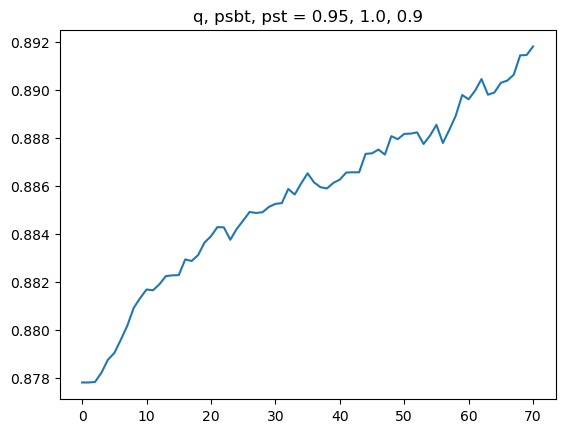

In [39]:
q = 0.95
p = 1.
ps = 0.9
rho_init = 0.0

ind_t = np.where( (np.abs(df2_wrho_correct.q - q) < 1e-5) & (np.abs(df2_wrho_correct.p - p ) < 1e-5) & (np.abs(df2_wrho_correct.rho_init - rho_init) < 1e-5) & (np.abs(df2_wrho_correct.ps - ps) < 1e-5))[0]


# df_one = df102.iloc[0].rho
df_one = df2_wrho_correct.iloc[ind_t[0]].rho
# q = df_w1000.iloc[108].q
# p = df_w1000.iloc[108].p
# ps = df_w1000.iloc[108].ps
df_one
plt.plot(df_one[30:])
plt.title('q, psbt, pst = ' + str(q) + ', ' + str(p) + ', ' + str(ps))

Text(0.5, 1.0, 'q, psbt, pst = 0.8, 1.0, 0.5')

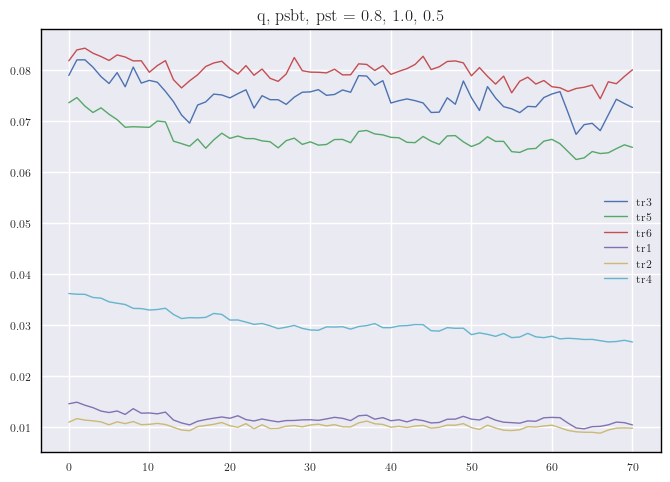

In [248]:
# df_one = df_w2.iloc[0].rho
# df_one
# plt.plot(df_one)

# plt.plot()

for triad in deg_triads:
    plt.plot(df2_joined_correct.iloc[ind_t[0]][triad][30:])
    
plt.legend(deg_triads)
# plt.xscale('log')

plt.title('q, psbt, pst = ' + str(q) + ', ' + str(p) + ', ' + str(ps))

In [312]:
rho_exp = 0.955414
m, s, b, f, tt = get_quasilevel_exp(df_one, rho_exp)

m - s, m + s, df_one[b]

(0.974799860755859, 1.0074328246640774, 0.951010101010101)

### Applying error functions to QS results

In [40]:
df2_wrho_g.columns

Index(['q', 'p', 'ps', 'rho_init', 'repetitions', 'rho_lvl', 'rho_lvl_std',
       'rho_lvl_valid', 'rho_lvl2', 'rho_lvl2_std', 'rho_lvl2_valid',
       'rho_lvl3', 'rho_lvl3_std', 'rho_lvl3_valid', 'rho_lvl_exp', 'tr_valid',
       'tr0_lvl', 'tr0_lvl_std', 'tr1_lvl', 'tr1_lvl_std', 'tr2_lvl',
       'tr2_lvl_std', 'tr3_lvl', 'tr3_lvl_std', 'tr4_lvl', 'tr4_lvl_std',
       'tr5_lvl', 'tr5_lvl_std', 'tr6_lvl', 'tr6_lvl_std', 'tr7_lvl',
       'tr7_lvl_std', 'tr0_lvl3', 'tr0_lvl3_std', 'tr1_lvl3', 'tr1_lvl3_std',
       'tr2_lvl3', 'tr2_lvl3_std', 'tr3_lvl3', 'tr3_lvl3_std', 'tr4_lvl3',
       'tr4_lvl3_std', 'tr5_lvl3', 'tr5_lvl3_std', 'tr6_lvl3', 'tr6_lvl3_std',
       'tr7_lvl3', 'tr7_lvl3_std'],
      dtype='object')

In [33]:
"""Adjusting col names"""

for col in df2_wrho_correct_g.columns:
    if col.endswith("_lvl3"):
        new_col = col.split("_lvl3")[0]
        df2_wrho_correct_g[new_col] = df2_wrho_correct_g[col]


In [34]:
df2_wrho_correct_g[["rho_lvl", "rho_lvl2", "rho_lvl3", "rho"]]

rho_lvl  rho_lvl2  rho_lvl3       rho
0.75 0.0 0.9 0.2  0.671249       NaN  0.671149  0.671149
             0.4  0.678054       NaN  0.677964  0.677964
             0.6  0.685312       NaN  0.685361  0.685361
             0.8  0.690937       NaN  0.690910  0.690910
             0.9  0.694057       NaN  0.694022  0.694022
...                    ...       ...       ...       ...
0.95 1.0 0.6 0.0  0.886219  0.886219  0.889994  0.889994
         0.7 0.0  0.894946  0.894946  0.896667  0.896667
         0.8 0.0  0.894108  0.894108  0.895917  0.895917
         0.9 0.0  0.889293  0.889293       NaN       NaN
         1.0 0.0  0.887526  0.887526  0.890680  0.890680

[1333 rows x 4 columns]

In [35]:
df2_wrho_correct_g_trans = transform_data(df2_wrho_correct_g, triads_groups = (n1_triads, n2_triads))
df2_wrho_correct_g_trans

q    p   ps  rho_init  repetitions   rho_lvl  \
0.75 0.0 0.9 0.2  0.75  0.0  0.9       0.2            5  0.671249   
             0.4  0.75  0.0  0.9       0.4            5  0.678054   
             0.6  0.75  0.0  0.9       0.6            5  0.685312   
             0.8  0.75  0.0  0.9       0.8            5  0.690937   
             0.9  0.75  0.0  0.9       0.9            5  0.694057   
...                ...  ...  ...       ...          ...       ...   
0.95 1.0 0.6 0.0  0.95  1.0  0.6       0.0            5  0.886219   
         0.7 0.0  0.95  1.0  0.7       0.0            5  0.894946   
         0.8 0.0  0.95  1.0  0.8       0.0            5  0.894108   
         0.9 0.0  0.95  1.0  0.9       0.0            5  0.889293   
         1.0 0.0  0.95  1.0  1.0       0.0            5  0.887526   

                  rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.75 0.0 0.9 0.2     0.000514              5       NaN           NaN  ...   
             0.4     0.000382              5       NaN           NaN  ...   
             0.6     0.000821              5       NaN           NaN  ...   
             0.8     0.000562              5       NaN           NaN  ...   
             0.9     0.000787              5       NaN           NaN  ...   
...                       ...            ...       ...           ...  ...   
0.95 1.0 0.6 0.0     0.002472              5  0.886219      0.002472  ...   
         0.7 0.0     0.001542              5  0.894946      0.001542  ...   
         0.8 0.0     0.004145              5  0.894108      0.004145  ...   
         0.9 0.0     0.002409              5  0.889293      0.002409  ...   
         1.0 0.0     0.002594              5  0.887526      0.002594  ...   

                  tr6_lvl3_std  tr7_lvl3  tr7_lvl3_std       rho       tr1  \
0.75 0.0 0.9 0.2      0.000696  0.358969      0.000587  0.671149  0.016093   
             0.4      0.000244  0.362391      0.000817  0.677964  0.022948   
             0.6      0.000469  0.366419      0.000780  0.685361  0.030711   
             0.8      0.000689  0.368795      0.001544  0.690910  0.037884   
             0.9      0.000715  0.369619      0.001863  0.694022  0.042034   
...                        ...       ...           ...       ...       ...   
0.95 1.0 0.6 0.0      0.000454  0.871168      0.001598  0.889994 -0.191710   
         0.7 0.0      0.000263  0.910557      0.000286  0.896667  0.194771   
         0.8 0.0      0.000448  0.924043      0.001998  0.895917 -0.313909   
         0.9 0.0      0.000341  0.928582      0.001443       NaN -0.013747   
         1.0 0.0      0.000298  0.930340      0.001868  0.890680 -0.331441   

                       tr2       tr3       tr4       tr5       tr6  
0.75 0.0 0.9 0.2 -0.024996  0.020726  0.008903 -0.050506  0.029780  
             0.4 -0.024899  0.024542  0.001951 -0.050141  0.025599  
             0.6 -0.025704  0.027369 -0.005007 -0.049214  0.021846  
             0.8 -0.028015  0.029096 -0.009869 -0.047447  0.018351  
             0.9 -0.029306  0.030864 -0.012729 -0.046322  0.015458  
...                    ...       ...       ...       ...       ...  
0.95 1.0 0.6 0.0 -0.239140 -0.008245  0.430850 -0.101269  0.109515  
         0.7 0.0  0.138562 -0.095718       NaN -0.120003  0.215721  
         0.8 0.0 -0.307931 -0.163163  0.621840 -0.140499  0.303662  
         0.9 0.0  0.347080 -0.213401       NaN -0.163161  0.376562  
         1.0 0.0 -0.321361 -0.252969  0.652802 -0.183273  0.436242  

[1333 rows x 55 columns]

In [36]:
# wiki_trans = transform_data(wiki, triads_groups=(n1_triads, n2_triads))

# df_w1000_trans = transform_data(df_w1000, triads_groups = (n1_triads, n2_triads))

datasets = []
for error_fun in error_functions:
    if error_fun.__name__.endswith("_transformed"):
        datasets.append((wiki_trans, df2_wrho_correct_g_trans, True, 2))
    else:
        datasets.append((wiki, df2_wrho_correct_g))


In [37]:
closest_to_four_triads_transformed(wiki_trans, df2_wrho_correct_g_trans, True)

0.75  0.0  0.9  0.2    0.036417
                0.4    0.036989
                0.6    0.037419
                0.8    0.037343
                0.9    0.037400
                         ...   
0.95  1.0  0.6  0.0    0.041780
           0.7  0.0    0.211767
           0.8  0.0    0.183524
           0.9  0.0    0.450707
           1.0  0.0    0.298750
Length: 1333, dtype: float64

In [38]:

errs = {error_fun.__name__: np.zeros(len(df2_wrho_correct_g)) for error_fun in error_functions}

for ind, (dataset, error_fun) in enumerate(zip(datasets, error_functions)):
    # original_data, model_data, is_trans = dataset
    # if is_trans:
    # errs[error_fun.__name__] = error_fun(original_data, model_data)
    # print(ind)
    try:
        errs[error_fun.__name__] = error_fun(*dataset)
    except TypeError:
        errs[error_fun.__name__] = error_fun(*dataset[:3])
    
    # if len(dataset) > 2:
        

for error_fun in error_functions:
    df2_wrho_correct_g[error_fun.__name__] = errs[error_fun.__name__]

df2_wrho_correct_g

q    p   ps  rho_init  repetitions   rho_lvl  \
0.75 0.0 0.9 0.2  0.75  0.0  0.9       0.2            5  0.671249   
             0.4  0.75  0.0  0.9       0.4            5  0.678054   
             0.6  0.75  0.0  0.9       0.6            5  0.685312   
             0.8  0.75  0.0  0.9       0.8            5  0.690937   
             0.9  0.75  0.0  0.9       0.9            5  0.694057   
...                ...  ...  ...       ...          ...       ...   
0.95 1.0 0.6 0.0  0.95  1.0  0.6       0.0            5  0.886219   
         0.7 0.0  0.95  1.0  0.7       0.0            5  0.894946   
         0.8 0.0  0.95  1.0  0.8       0.0            5  0.894108   
         0.9 0.0  0.95  1.0  0.9       0.0            5  0.889293   
         1.0 0.0  0.95  1.0  1.0       0.0            5  0.887526   

                  rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.75 0.0 0.9 0.2     0.000514              5       NaN           NaN  ...   
             0.4     0.000382              5       NaN           NaN  ...   
             0.6     0.000821              5       NaN           NaN  ...   
             0.8     0.000562              5       NaN           NaN  ...   
             0.9     0.000787              5       NaN           NaN  ...   
...                       ...            ...       ...           ...  ...   
0.95 1.0 0.6 0.0     0.002472              5  0.886219      0.002472  ...   
         0.7 0.0     0.001542              5  0.894946      0.001542  ...   
         0.8 0.0     0.004145              5  0.894108      0.004145  ...   
         0.9 0.0     0.002409              5  0.889293      0.002409  ...   
         1.0 0.0     0.002594              5  0.887526      0.002594  ...   

                  closest_to_six_triads  closest_to_six_triads_transformed  \
0.75 0.0 0.9 0.2               0.018584                           0.086314   
             0.4               0.018380                           0.090184   
             0.6               0.018159                           0.093991   
             0.8               0.017998                           0.096328   
             0.9               0.017939                           0.097872   
...                                 ...                                ...   
0.95 1.0 0.6 0.0               0.005867                           0.081624   
         0.7 0.0               0.008302                           0.221381   
         0.8 0.0               0.010855                           0.363264   
         0.9 0.0               0.011189                           0.497248   
         1.0 0.0               0.012195                           0.541408   

                  closest_to_six_triads_corrdevs_transformed  \
0.75 0.0 0.9 0.2                                    1.036417   
             0.4                                    1.036989   
             0.6                                    1.037419   
             0.8                                    1.037343   
             0.9                                    1.037400   
...                                                      ...   
0.95 1.0 0.6 0.0                                    1.041780   
         0.7 0.0                                    1.211767   
         0.8 0.0                                    1.183524   
         0.9 0.0                                    1.450707   
         1.0 0.0                                    1.298750   

                  closest_to_four_triads_corrdevs_transformed  \
0.75 0.0 0.9 0.2                                     1.036417   
             0.4                                     1.036989   
             0.6                                     1.037419   
             0.8                                     1.037343   
             0.9                                     1.037400   
...                                                       ...   
0.95 1.0 0.6 0.0                                     0.041780   
         0.7 0.0                         

In [39]:
kmin = 3
inds_g = []
for error_fun in error_functions:
    arr = df2_wrho_correct_g[error_fun.__name__]
    inds_p = np.argpartition(arr, kmin)[:kmin]
    inds_g.extend(inds_p)
    # print("Best for " + error_fun.__name__ + " are:")
    # for ind in inds:
    #     print(df3.iloc[ind])

df2_wrho_correct_g.iloc[inds_g]
        

q    p   ps  rho_init  repetitions   rho_lvl  \
0.925 0.1 0.7 0.0  0.925  0.1  0.7       0.0            5  0.793509   
0.750 0.2 0.9 0.4  0.750  0.2  0.9       0.4            5  0.794068   
0.825 0.2 0.8 0.2  0.825  0.2  0.8       0.2            5  0.794162   
0.900 0.6 0.6 0.2  0.900  0.6  0.6       0.2            5  0.844622   
0.750 0.3 0.9 0.4  0.750  0.3  0.9       0.4            5  0.859392   
0.900 0.2 0.7 0.8  0.900  0.2  0.7       0.8           10  0.853744   
0.875 0.3 0.9 0.0  0.875  0.3  0.9       0.0            5  0.893768   
0.825 0.9 0.8 0.0  0.825  0.9  0.8       0.0            5  0.896056   
0.800 0.8 0.9 0.0  0.800  0.8  0.9       0.0            5  0.898580   
      0.9 0.4 0.9  0.800  0.9  0.4       0.9            1  0.884325   
0.875 1.0 0.4 0.8  0.875  1.0  0.4       0.8            5  0.880146   
0.950 0.9 0.5 0.4  0.950  0.9  0.5       0.4            5  0.856362   
0.900 0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
0.875 0.8 0.6 0.4  0.875  0.8  0.6       0.4            9  0.913110   
0.925 0.7 0.6 0.2  0.925  0.7  0.6       0.2            5  0.887701   
0.775 1.0 0.5 0.0  0.775  1.0  0.5       0.0            5  0.841893   
0.750 0.8 0.6 0.0  0.750  0.8  0.6       0.0            5  0.831777   
0.800 1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.900 0.8 0.6 0.2  0.900  0.8  0.6       0.2            5  0.893451   
0.925 0.8 0.6 0.2  0.925  0.8  0.6       0.2            5  0.899715   
0.900 0.5 0.7 0.2  0.900  0.5  0.7       0.2            5  0.895893   
      0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
0.875 0.8 0.6 0.4  0.875  0.8  0.6       0.4            9  0.913110   
0.925 0.7 0.6 0.2  0.925  0.7  0.6       0.2            5  0.887701   
0.900 0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
0.875 0.8 0.6 0.4  0.875  0.8  0.6       0.4            9  0.913110   
0.925 0.7 0.6 0.2  0.925  0.7  0.6       0.2            5  0.887701   
0.775 0.9 0.5 0.0  0.775  0.9  0.5       0.0            5  0.806144   
0.750 0.9 0.5 0.0  0.750  0.9  0.5       0.0            5  0.807928   
0.800 0.9 0.5 0.0  0.800  0.9  0.5       0.0            5  0.804148   
      1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.825 1.0 0.5 0.0  0.825  1.0  0.5       0.0            5  0.839106   
0.950 0.6 0.6 0.0  0.950  0.6  0.6       0.0            5  0.855452   
0.875 0.9 0.5 0.0  0.875  0.9  0.5       0.0            5  0.795311   
0.925 0.5 0.6 0.0  0.925  0.5  0.6       0.0            5  0.798926   
0.950 0.4 0.6 0.0  0.950  0.4  0.6       0.0            5  0.802109   
0.900 1.0 0.5 0.0  0.900  1.0  0.5       0.0            5  0.833692   
0.925 1.0 0.5 0.0  0.925  1.0  0.5       0.0            5  0.828365   
0.875 1.0 0.5 0.0  0.875  1.0  0.5       0.0            5  0.836755   
0.800 1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.850 1.0 0.5 0.0  0.850  1.0  0.5       0.0            5  0.838019   
0.775 0.8 0.6 0.0  0.775  0.8  0.6       0.0            5  0.836517   
0.950 0.8 0.5 0.8  0.950  0.8  0.5       0.8            5  0.881828   
      0.9 0.5 0.4  0.950  0.9  0.5       0.4            5  0.856362   
0.850 0.6 0.6 0.6  0.850  0.6  0.6       0.6            5  0.868987   

                   rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.925 0.1 0.7 0.0     0.001048              5  0.793509      0.001048  ...   
0.750 0.2 0.9 0.4     0.000700              5  0.794068      0.000700  ...   
0.825 0.2 0.8 0.2     0.001145              5  0.794162      0.001145  ...   
0.900 0.6 0.6 0.2     0.002382              5  0.844622      0.002382  ...   
0.750 0.3 0.9 0.4     0.001280              5  0.859392      0.001280  ...   
0.900 0.2 0.7 0.8     0.001149             10  0.853744      0.001149  ...   
0.875 0.3 0.9 0.0     0.001433              5  0.893768      0.001433  ...   
0.825 0.9 0.8 0.0     0.000884              5  0.896056      0.000884  ...   
0.800 0.8 0.9 0.0     0.000348              5  0.89858

In [40]:
df2_wrho_correct_g.columns

non_nan_cols = ['rho', 'tr0', 'tr1', 'tr2', 'tr3', 'tr4',
       'tr5', 'tr6', 'tr7']

In [41]:
for ind,row in df2_wrho_correct_g.iterrows():
    if np.any(np.isnan(row[non_nan_cols].values.flatten().tolist())):
        print(ind)

(0.8, 0.5, 0.6000000000000001, 0.2)
(0.85, 0.8, 1.0, 0.0)
(0.875, 0.7000000000000001, 1.0, 0.0)
(0.875, 0.8, 1.0, 0.0)
(0.875, 0.9, 0.9, 0.0)
(0.875, 1.0, 0.4, 0.6)
(0.9, 0.4, 1.0, 0.0)
(0.9, 0.7000000000000001, 0.9, 0.0)
(0.925, 0.2, 0.7000000000000001, 0.9)
(0.925, 0.4, 1.0, 0.0)
(0.925, 0.5, 1.0, 0.0)
(0.925, 0.6000000000000001, 0.9, 0.0)
(0.925, 0.6000000000000001, 1.0, 0.0)
(0.925, 0.7000000000000001, 0.8, 0.0)
(0.925, 0.8, 0.7000000000000001, 0.0)
(0.925, 0.8, 0.9, 0.0)
(0.925, 0.9, 0.9, 0.0)
(0.95, 0.0, 1.0, 0.0)
(0.95, 0.1, 0.9, 0.0)
(0.95, 0.1, 1.0, 0.0)
(0.95, 0.2, 0.8, 0.0)
(0.95, 0.3, 0.8, 0.0)
(0.95, 0.3, 1.0, 0.0)
(0.95, 0.4, 0.9, 0.0)
(0.95, 0.5, 1.0, 0.0)
(0.95, 0.6000000000000001, 0.7000000000000001, 0.0)
(0.95, 0.6000000000000001, 0.9, 0.0)
(0.95, 0.6000000000000001, 1.0, 0.0)
(0.95, 0.7000000000000001, 0.8, 0.0)
(0.95, 0.7000000000000001, 1.0, 0.0)
(0.95, 0.8, 0.5, 0.9)
(0.95, 0.8, 0.7000000000000001, 0.0)
(0.95, 0.8, 0.8, 0.0)
(0.95, 0.8, 1.0, 0.0)
(0.95, 0.9, 0.8, 

In [42]:
"""Let us exclude rows that have nan in rho and rho in [0.65,0.92]"""
non_nan_cols = ['rho', 'tr0', 'tr1', 'tr2', 'tr3', 'tr4',
       'tr5', 'tr6', 'tr7']
kmin = 3
inds_g3 = []
for error_fun in error_functions:
    arr = [row[error_fun.__name__] if ((not np.any(np.isnan(row[non_nan_cols].values.flatten().tolist()))) & (not np.isnan(row.rho_lvl)) & (row.rho_lvl < 0.92) & (row.rho_lvl > 0.65)) else 100 for ind,row in df2_wrho_correct_g.iterrows()]
    inds_p = np.argpartition(arr, kmin)[:kmin]
    inds_g3.extend(inds_p)
    # print("Best for " + error_fun.__name__ + " are:")
    # for ind in inds:
    #     print(df3.iloc[ind])

df2_wrho_correct_g.iloc[inds_g3]
        

q    p   ps  rho_init  repetitions   rho_lvl  \
0.925 0.1 0.7 0.0  0.925  0.1  0.7       0.0            5  0.793509   
0.825 0.2 0.8 0.2  0.825  0.2  0.8       0.2            5  0.794162   
0.750 0.2 0.9 0.4  0.750  0.2  0.9       0.4            5  0.794068   
      0.3 0.9 0.4  0.750  0.3  0.9       0.4            5  0.859392   
0.900 0.6 0.6 0.2  0.900  0.6  0.6       0.2            5  0.844622   
      0.2 0.7 0.8  0.900  0.2  0.7       0.8           10  0.853744   
0.875 0.3 0.9 0.0  0.875  0.3  0.9       0.0            5  0.893768   
0.825 0.9 0.8 0.0  0.825  0.9  0.8       0.0            5  0.896056   
0.800 0.8 0.9 0.0  0.800  0.8  0.9       0.0            5  0.898580   
0.950 0.9 0.5 0.4  0.950  0.9  0.5       0.4            5  0.856362   
0.875 1.0 0.4 0.8  0.875  1.0  0.4       0.8            5  0.880146   
0.800 0.9 0.4 0.9  0.800  0.9  0.4       0.9            1  0.884325   
0.900 0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
0.875 0.8 0.6 0.4  0.875  0.8  0.6       0.4            9  0.913110   
0.925 0.7 0.6 0.2  0.925  0.7  0.6       0.2            5  0.887701   
0.800 1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.750 0.8 0.6 0.0  0.750  0.8  0.6       0.0            5  0.831777   
0.775 1.0 0.5 0.0  0.775  1.0  0.5       0.0            5  0.841893   
0.900 0.8 0.6 0.2  0.900  0.8  0.6       0.2            5  0.893451   
0.925 0.8 0.6 0.2  0.925  0.8  0.6       0.2            5  0.899715   
0.900 0.5 0.7 0.2  0.900  0.5  0.7       0.2            5  0.895893   
      0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
0.875 0.8 0.6 0.4  0.875  0.8  0.6       0.4            9  0.913110   
0.925 0.7 0.6 0.2  0.925  0.7  0.6       0.2            5  0.887701   
0.900 0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
0.875 0.8 0.6 0.4  0.875  0.8  0.6       0.4            9  0.913110   
0.925 0.7 0.6 0.2  0.925  0.7  0.6       0.2            5  0.887701   
0.775 0.9 0.5 0.0  0.775  0.9  0.5       0.0            5  0.806144   
0.750 0.9 0.5 0.0  0.750  0.9  0.5       0.0            5  0.807928   
0.800 0.9 0.5 0.0  0.800  0.9  0.5       0.0            5  0.804148   
0.950 0.6 0.6 0.0  0.950  0.6  0.6       0.0            5  0.855452   
0.825 1.0 0.5 0.0  0.825  1.0  0.5       0.0            5  0.839106   
0.800 1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.925 0.5 0.6 0.0  0.925  0.5  0.6       0.0            5  0.798926   
0.875 0.9 0.5 0.0  0.875  0.9  0.5       0.0            5  0.795311   
0.950 0.4 0.6 0.0  0.950  0.4  0.6       0.0            5  0.802109   
0.900 1.0 0.5 0.0  0.900  1.0  0.5       0.0            5  0.833692   
0.925 1.0 0.5 0.0  0.925  1.0  0.5       0.0            5  0.828365   
0.875 1.0 0.5 0.0  0.875  1.0  0.5       0.0            5  0.836755   
0.800 1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.850 1.0 0.5 0.0  0.850  1.0  0.5       0.0            5  0.838019   
0.775 0.8 0.6 0.0  0.775  0.8  0.6       0.0            5  0.836517   
0.950 0.9 0.5 0.4  0.950  0.9  0.5       0.4            5  0.856362   
      0.8 0.5 0.8  0.950  0.8  0.5       0.8            5  0.881828   
0.850 0.6 0.6 0.6  0.850  0.6  0.6       0.6            5  0.868987   

                   rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.925 0.1 0.7 0.0     0.001048              5  0.793509      0.001048  ...   
0.825 0.2 0.8 0.2     0.001145              5  0.794162      0.001145  ...   
0.750 0.2 0.9 0.4     0.000700              5  0.794068      0.000700  ...   
      0.3 0.9 0.4     0.001280              5  0.859392      0.001280  ...   
0.900 0.6 0.6 0.2     0.002382              5  0.844622      0.002382  ...   
      0.2 0.7 0.8     0.001149             10  0.853744      0.001149  ...   
0.875 0.3 0.9 0.0     0.001433              5  0.893768      0.001433  ...   
0.825 0.9 0.8 0.0     0.000884              5  0.896056      0.000884  ...   
0.800 0.8 0.9 0.0     0.000348              5  0.89858

# Plots

In [43]:


n1_triads = ['tr3', 'tr5', 'tr6']
n1_nonhierarchical = 'tr5'
n2_triads = ['tr1', 'tr2', 'tr4']
n2_nonhierarchical = 'tr2'

triad_names_map={
    'tr7': 'BH0',
    'tr4': 'BH1',
    'tr1': 'BH2',
    'tr2': 'BN1',
    'tr0': 'UH2',
    'tr3': 'UH1',
    'tr5': 'UN1',
    'tr6': 'UH0',
}
triad_names_map.update({value: key for key, value in triad_names_map.items()})


### Heatmaps

In [52]:
df2_wrho_correct_g

q    p   ps  rho_init  repetitions   rho_lvl  \
0.75 0.0 0.9 0.2  0.75  0.0  0.9       0.2            5  0.671249   
             0.4  0.75  0.0  0.9       0.4            5  0.678054   
             0.6  0.75  0.0  0.9       0.6            5  0.685312   
             0.8  0.75  0.0  0.9       0.8            5  0.690937   
             0.9  0.75  0.0  0.9       0.9            5  0.694057   
...                ...  ...  ...       ...          ...       ...   
0.95 1.0 0.6 0.0  0.95  1.0  0.6       0.0            5  0.886219   
         0.7 0.0  0.95  1.0  0.7       0.0            5  0.894946   
         0.8 0.0  0.95  1.0  0.8       0.0            5  0.894108   
         0.9 0.0  0.95  1.0  0.9       0.0            5  0.889293   
         1.0 0.0  0.95  1.0  1.0       0.0            5  0.887526   

                  rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.75 0.0 0.9 0.2     0.000514              5       NaN           NaN  ...   
             0.4     0.000382              5       NaN           NaN  ...   
             0.6     0.000821              5       NaN           NaN  ...   
             0.8     0.000562              5       NaN           NaN  ...   
             0.9     0.000787              5       NaN           NaN  ...   
...                       ...            ...       ...           ...  ...   
0.95 1.0 0.6 0.0     0.002472              5  0.886219      0.002472  ...   
         0.7 0.0     0.001542              5  0.894946      0.001542  ...   
         0.8 0.0     0.004145              5  0.894108      0.004145  ...   
         0.9 0.0     0.002409              5  0.889293      0.002409  ...   
         1.0 0.0     0.002594              5  0.887526      0.002594  ...   

                  closest_to_six_triads  closest_to_six_triads_transformed  \
0.75 0.0 0.9 0.2               0.018584                           0.086314   
             0.4               0.018380                           0.090184   
             0.6               0.018159                           0.093991   
             0.8               0.017998                           0.096328   
             0.9               0.017939                           0.097872   
...                                 ...                                ...   
0.95 1.0 0.6 0.0               0.005867                           0.081624   
         0.7 0.0               0.008302                           0.221381   
         0.8 0.0               0.010855                           0.363264   
         0.9 0.0               0.011189                           0.497248   
         1.0 0.0               0.012195                           0.541408   

                  closest_to_six_triads_corrdevs_transformed  \
0.75 0.0 0.9 0.2                                    1.036417   
             0.4                                    1.036989   
             0.6                                    1.037419   
             0.8                                    1.037343   
             0.9                                    1.037400   
...                                                      ...   
0.95 1.0 0.6 0.0                                    1.041780   
         0.7 0.0                                    1.211767   
         0.8 0.0                                    1.183524   
         0.9 0.0                                    1.450707   
         1.0 0.0                                    1.298750   

                  closest_to_four_triads_corrdevs_transformed  \
0.75 0.0 0.9 0.2                                     1.036417   
             0.4                                     1.036989   
             0.6                                     1.037419   
             0.8                                     1.037343   
             0.9                                     1.037400   
...                                                       ...   
0.95 1.0 0.6 0.0                                     0.041780   
         0.7 0.0                         

In [53]:
np.unique(get_index_row(df2_wrho_correct_g, 3))

NameError: name 'get_index_row' is not defined

In [54]:
np.unique(df_wrho.p)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [55]:
df2_wrho_correct_g_minerrs = df2_wrho_correct_g.groupby(by=["q", "p", "ps"]).min()

In [57]:
def get_index_row(df, which):
    return [ind[which] for ind in df.index]

qs = np.unique(get_index_row(df2_wrho_correct_g_minerrs, 0))
# qs = np.unique(get_index_row(df2_joined_correct_g, 3))

i = 2


q = qs[i]
print(q)

inds2 = np.abs(get_index_row(df2_wrho_correct_g_minerrs, 0) - q) < 1e-5
df2_wrho_correct_g_minerrs[inds2]

df_temp = df2_wrho_correct_g_minerrs[inds2].copy(deep=True)
if q == 0:
    
    ps_true = np.unique(df_temp.ps)
    
    for ps in np.arange(0,1.1,0.1):
        ps = round(ps, 2)
        if ps == ps_true:
            continue
        # df_temp = df_temp.append(df2_w1000_g[inds2])
        # for i in range(len(df2_w1000_g[inds2])):
        #     df_temp['ps'][-i-1] = ps
        for ind, row in df2_wrho_correct_g_minerrs[inds2].iterrows():
            new_ind = (ind[0], ind[1], ps)
            row.ps = ps
            # df_temp[new_ind] = row
            df_temp = df_temp.append(row, ignore_index = True)
            # print(ps)
elif q == 1.:
    
    ph_true = np.unique(df_temp.p)
    
    for ph in np.arange(0,1.1,0.1):
        ph = round(ph, 2)
        if ph == ph_true:
            continue
        # df_temp = df_temp.append(df2_w1000_g[inds2])
        # for i in range(len(df2_w1000_g[inds2])):
        #     df_temp['ps'][-i-1] = ps
        for ind, row in df2_wrho_correct_g_minerrs[inds2].iterrows():
            new_ind = (ind[0], ps, ind[2])
            row.p = ph
            # df_temp[new_ind] = row
            df_temp = df_temp.append(row, ignore_index = True)
            # print(ps)

df_temp

pv = pd.pivot_table(df_temp, values = "closest_to_rho", index = "ps", columns = "p")
pv
# pv = pd.pivot_table(df2_w1000_g[inds2], values = "closest_to_rho", index = "ps", columns = "p")
# pv
# pv["0.6"] = pv["0.5"]
# pv



0.8


p,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
ps,,,,,,,,,,,
0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001513
0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000818,0.000090
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001476,0.000144,0.000122,0.002196
0.6,NaN,NaN,NaN,NaN,NaN,0.002387,0.000067,0.000064,0.002235,0.004461,0.006217
0.7,NaN,NaN,0.016322,0.002611,0.000031,0.000009,0.002141,0.004815,0.006655,0.008011,0.008941
0.8,0.013601,0.003018,0.000053,0.000017,0.001716,0.004916,0.006994,0.008342,0.009440,0.010098,0.010522
0.9,0.000092,0.000013,0.001094,0.004341,0.007113,0.008854,0.009934,0.010574,0.011095,0.011211,0.011556
1.0,0.000265,0.003083,0.006724,0.009025,0.010279,0.011057,0.011464,0.011738,0.012031,0.012003,0.011872


/tmp/ipykernel_69815/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

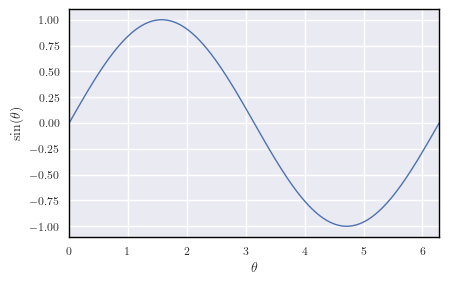

In [58]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



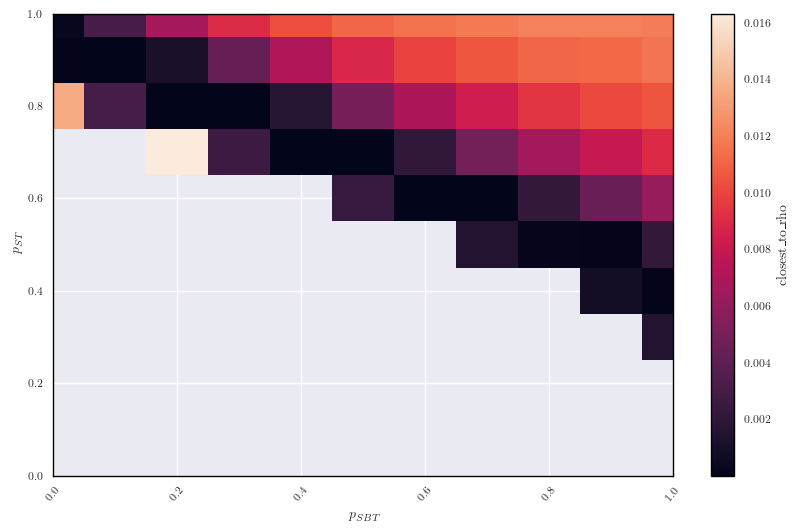

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))

colormesh = ax.pcolormesh(pv.columns, pv.index, pv, cmap=sns.color_palette("rocket", as_cmap=True))

ax.tick_params(axis='x', which='major', rotation=50)
# ax.set_xticks(pv.columns)
# ax.set_yticks(pv.index)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

cbar = fig.colorbar(colormesh,ax = ax)

# ax.plot(pbs, rho_crits, color='black')

ax.set_xlabel(r'$p_{SBT}$')
ax.set_ylabel(r'$p_{ST}$')
# ax.set_xlabel('p_SB')

cbar.set_label("closest_to_rho")

Text(0.5, 0.98, ' closest_to_rho ')

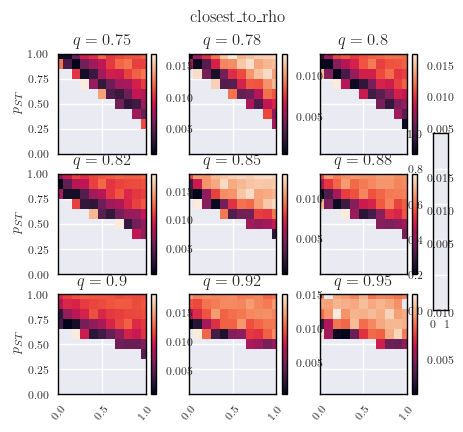

In [64]:

save_ = False

figsize = set_size(width)
figsize = (figsize[0], figsize[1]*1.5)

fig, axs = plt.subplots(3, 3, figsize=figsize, sharey=True, sharex = True)

cbar_ax = fig.add_axes([.91, .3, .03, .4])

qs = np.unique(get_index_row(df2_wrho_correct_g, 0))

minval = df2_wrho_correct_g.describe().closest_to_rho["min"]
maxval = df2_wrho_correct_g.describe().closest_to_rho["max"]

for i, (ax, q) in enumerate(zip(axs.flat, qs)):
    # if i == 11:
    #     continue
    inds2 = np.abs(get_index_row(df2_wrho_correct_g, 0) - q) < 1e-5
    
    df_temp = df2_wrho_correct_g[inds2].copy(deep=True)
    if q == 0:
        
        ps_true = np.unique(df_temp.ps)
        
        for ps in np.arange(0,1.1,0.1):
            ps = round(ps, 2)
            if ps == ps_true:
                continue
            # df_temp = df_temp.append(df2_w1000_g[inds2])
            # for i in range(len(df2_w1000_g[inds2])):
            #     df_temp['ps'][-i-1] = ps
            for ind, row in df2_wrho_correct_g[inds2].iterrows():
                new_ind = (ind[0], ind[1], ps)
                row.ps = ps
                # df_temp[new_ind] = row
                df_temp = df_temp.append(row, ignore_index = True)
                # print(ps)
    elif q == 1.:
        
        ph_true = np.unique(df_temp.p)
        
        for ph in np.arange(0,1.1,0.1):
            ph = round(ph, 2)
            if ph == ph_true:
                continue
            # df_temp = df_temp.append(df2_w1000_g[inds2])
            # for i in range(len(df2_w1000_g[inds2])):
            #     df_temp['ps'][-i-1] = ps
            for ind, row in df2_wrho_correct_g[inds2].iterrows():
                new_ind = (ind[0], ps, ind[2])
                row.p = ph
                # df_temp[new_ind] = row
                df_temp = df_temp.append(row, ignore_index = True)
                # print(ps)

    # df_temp
    
    pv = pd.pivot_table(df_temp, values = "closest_to_rho", index = "ps", columns = "p")
    # print(pv)
    colormesh = ax.pcolormesh(pv.columns, pv.index, pv, cmap=sns.color_palette("rocket", as_cmap=True))

    ax.tick_params(axis='x', which='major', rotation=50)
    # ax.set_xticks(pv.columns)
    # ax.set_yticks(pv.index)
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    cbar = fig.colorbar(colormesh,ax = ax)

    # ax.set_xlabel(r'$p_{SBT}$')
    # ax.set_ylabel(r'$p_{ST}$')
    # # ax.set_xlabel('p_SB')

    # cbar.set_label("closest_to_rho")

    ax.set_title(r'$q={q}$'.format(q=round(q, 2)))
    
    # fmt = '{:0.1f}'
    # xticklabels = []
    # for item in ax.get_xticklabels():
    #     item.set_text(fmt.format(float(item.get_text())))
    #     xticklabels += [item]
        
    # if len(ax.get_yticklabels()) > 0:
    #     # print(q)
    #     yticklabels = []
        
    #     for item in ax.get_yticklabels():
    #         item.set_text(fmt.format(float(item.get_text())))
    #         yticklabels += [item]
    # else:
    #     yticklabels2 = []
    #     for item in yticklabels:
    #         item.set_text(fmt.format(float(item.get_text())))
    #         yticklabels2 += [item]
    #     ax.set_yticklabels(yticklabels2)
    
    
    if i%3 == 0:
        # print(yticklabels)
        # ax.set_yticklabels(yticklabels)
        # print(ax.get_yticklabels())
        ax.set_ylabel(r'$p_{ST}$')
    else:
        # print(ax.get_yticklabels())
        ax.set_ylabel('')
        ax.tick_params(left=False)
        # print(yticklabels)
    if i == 10:
        ax.set_xlabel(r'$p_{SBT}$')
    else:
        ax.set_xlabel('')
    if i < 9:
        ax.tick_params(bottom=False)
    # else:
        # ax.set_xticklabels(xticklabels)
    # else: break

# axs.fla

fig.suptitle(' closest_to_rho ')

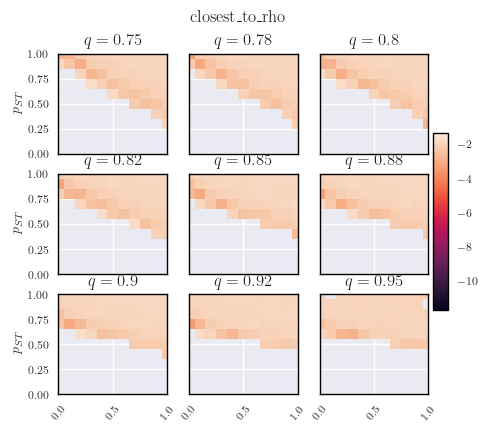

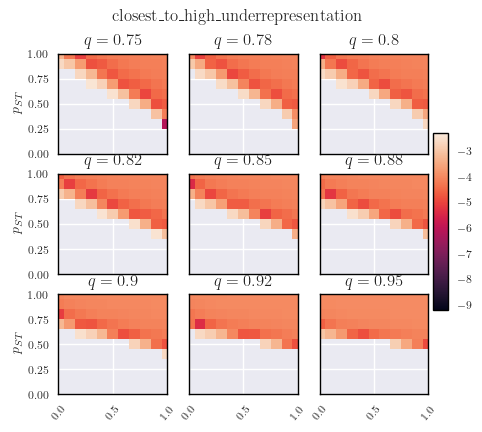

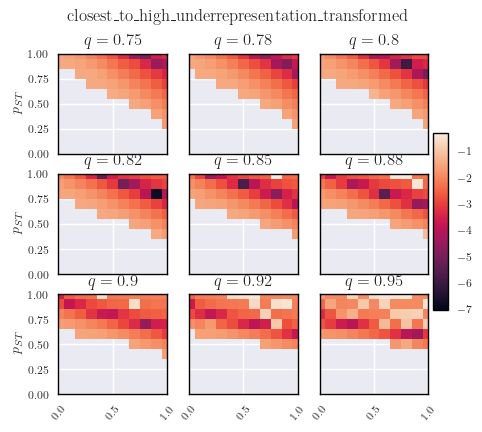

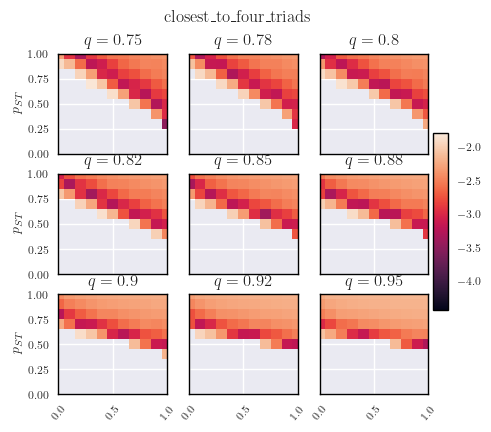

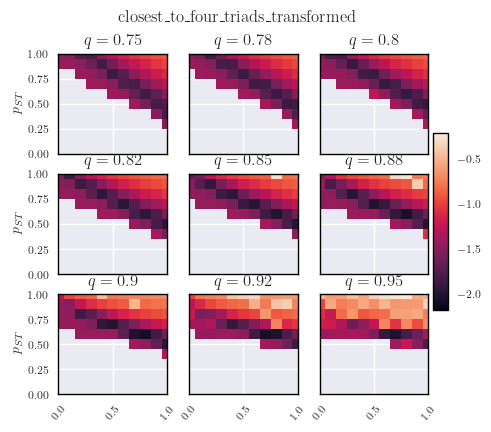

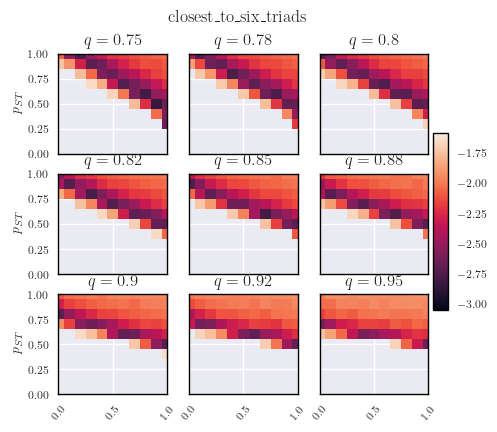

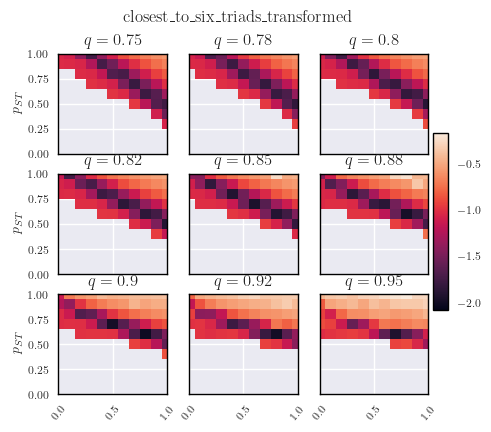

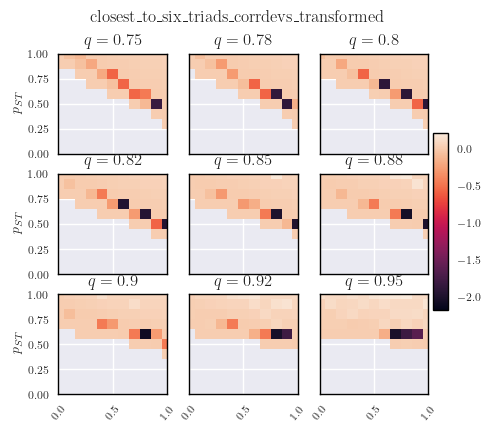

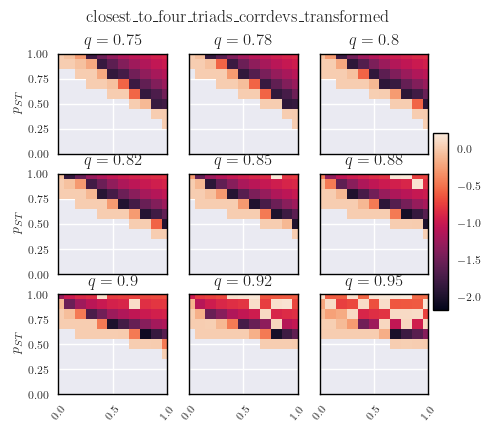

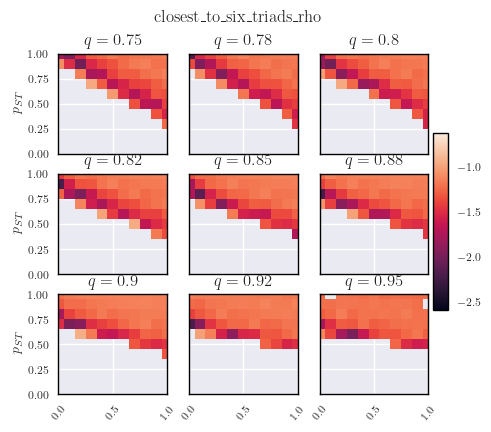

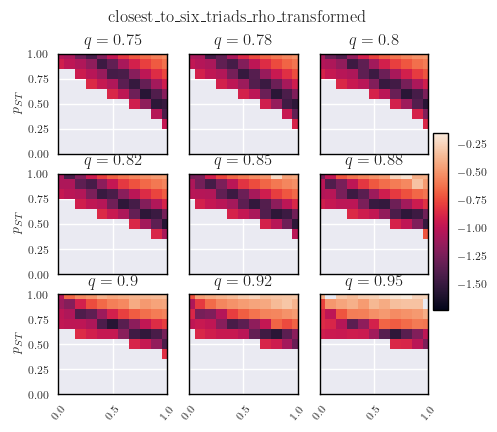

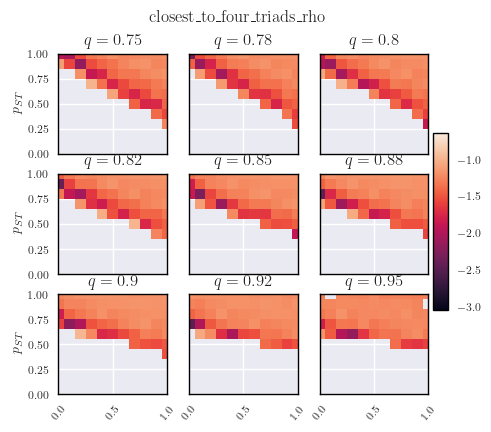

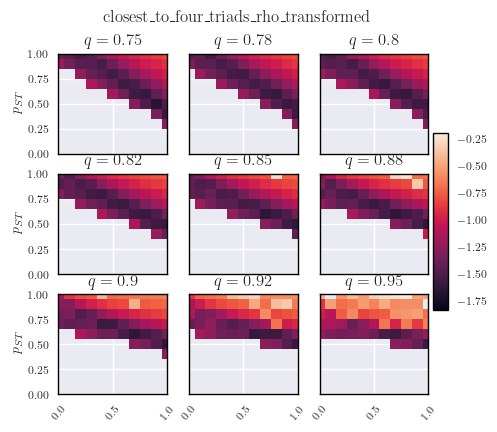

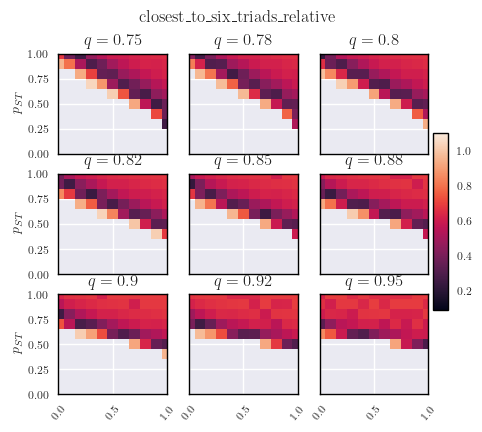

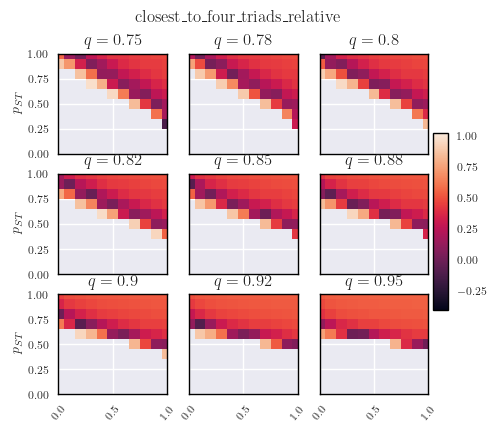

In [65]:

save_ = False
log = True

for error_fun in error_functions:
    error_fun_name = error_fun.__name__

    figsize = set_size(width)
    figsize = (figsize[0], figsize[1]*1.5)

    fig, axs = plt.subplots(3, 3, figsize=figsize, sharey=True, sharex = True)

    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    qs = np.unique(get_index_row(df2_wrho_correct_g, 0))

    minval = df2_wrho_correct_g.describe()[error_fun_name]["min"]
    maxval = df2_wrho_correct_g.describe()[error_fun_name]["max"]
    if log:
        minval = np.log10(minval)
        maxval = np.log10(maxval)
    
    for i, (ax, q) in enumerate(zip(axs.flat, qs)):
        # if i == 11:
        #     continue

        inds2 = np.abs(get_index_row(df2_wrho_correct_g, 0) - q) < 1e-5
    
        df_temp = df2_wrho_correct_g[inds2].copy(deep=True)
        if q == 0:
            
            ps_true = np.unique(df_temp.ps)
            
            for ps in np.arange(0,1.1,0.1):
                ps = round(ps, 2)
                if ps == ps_true:
                    continue
                # df_temp = df_temp.append(df2_w1000_g[inds2])
                # for i in range(len(df2_w1000_g[inds2])):
                #     df_temp['ps'][-i-1] = ps
                for ind, row in df2_wrho_correct_g[inds2].iterrows():
                    new_ind = (ind[0], ind[1], ps)
                    row.ps = ps
                    # df_temp[new_ind] = row
                    df_temp = df_temp.append(row, ignore_index = True)
                    # print(ps)
        elif q == 1.:
            
            ph_true = np.unique(df_temp.p)
            
            for ph in np.arange(0,1.1,0.1):
                ph = round(ph, 2)
                if ph == ph_true:
                    continue
                # df_temp = df_temp.append(df2_w1000_g[inds2])
                # for i in range(len(df2_w1000_g[inds2])):
                #     df_temp['ps'][-i-1] = ps
                for ind, row in df2_wrho_correct_g[inds2].iterrows():
                    new_ind = (ind[0], ps, ind[2])
                    row.p = ph
                    # df_temp[new_ind] = row
                    df_temp = df_temp.append(row, ignore_index = True)
                    # print(ps)

        # df_temp
        
        pv = pd.pivot_table(df_temp, values = error_fun_name, index = "ps", columns = "p")
        if log == True:
            pv = np.log10(pv)
        colormesh = ax.pcolormesh(pv.columns, pv.index, pv, cmap=sns.color_palette("rocket", as_cmap=True),
                                  vmin = minval, vmax = maxval)

        ax.tick_params(axis='x', which='major', rotation=50)
        # ax.set_xticks(pv.columns)
        # ax.set_yticks(pv.index)
        
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])

        if i == 0:
            cbar = fig.colorbar(colormesh,cax = cbar_ax)#, fraction=0.046, pad=0.04)#,vmin = minval, vmax = maxval)
        
        
        # sns.heatmap(pv, square = True, ax = ax, cbar_ax = cbar_ax, cbar = i == 0, vmin = minval, vmax = maxval)
        
        ax.set_title(r'$q={q}$'.format(q=round(q, 2)))
        
        # fmt = '{:0.1f}'
        # xticklabels = []
        # for item in ax.get_xticklabels():
        #     item.set_text(fmt.format(float(item.get_text())))
        #     xticklabels += [item]
            
        # if len(ax.get_yticklabels()) > 0:
        #     # print(q)
        #     yticklabels = []
            
        #     for item in ax.get_yticklabels():
        #         item.set_text(fmt.format(float(item.get_text())))
        #         yticklabels += [item]
        # else:
        #     yticklabels2 = []
        #     for item in yticklabels:
        #         item.set_text(fmt.format(float(item.get_text())))
        #         yticklabels2 += [item]
        #     ax.set_yticklabels(yticklabels2)
        
        if i%3 == 0:
            # print(yticklabels)
            # ax.set_yticklabels(yticklabels)
            # print(ax.get_yticklabels())
            ax.set_ylabel(r'$p_{ST}$')
        else:
            # print(ax.get_yticklabels())
            ax.set_ylabel('')
            ax.tick_params(left=False)
            # print(yticklabels)
        if i == 10:
            ax.set_xlabel(r'$p_{SBT}$')
        else:
            ax.set_xlabel('')
        if i < 9:
            ax.tick_params(bottom=False)
        # else:
            # ax.set_xticklabels(xticklabels)
    
    fig.suptitle(error_fun_name)
    
    if save_:
        fname = "maps/map_long2_" + error_fun_name
        # fname = fname + filename_addon
        if log:
            fname = fname + "_log"
        fname = fname + ".pdf"
        
        fig.savefig(fname, format='pdf', bbox_inches='tight') 

## Barplots

In [152]:
real_net_additional_label_data = 0.32432
label = "wiki"
label += r": $\rho={rho}$".format(rho = round(real_net_additional_label_data, 2))
label

'wiki: $\\rho=0.32$'

In [164]:

def plot_bar_nets(ax, ydata, yerr, triads_set, title, labels, 
                  line_level = 1/3, linewidth = 2, colors=None, 
                  width = 0.15, smallest_edge = False, m = 1,
                  legend_elem = 3, real_net_data = None, additional_label_data = None, real_net_additional_label_data = None):
    n_simulated = ydata.copy()
    if yerr is not None:
        n_err = yerr.copy()
    else:
        n_err = None   
    if real_net_data is not None:
        data_name = real_net_data.columns[0]
        real_data = [val[0] for val in real_net_data.values]
        n_simulated[data_name] = real_data
        if yerr is not None:
            real_data_std = np.full(len(n_simulated.index), np.nan)
            n_err[data_name] = real_data_std
#     width = 0.15
    multiplier = 0
    x = np.arange(len(n_simulated.index))*3-1.5
    for i, col in enumerate(n_simulated.columns):
        offset = multiplier*width*4
        if labels is not None:
            label = labels[i]
        else:
            # label = col
            # print(col)
            if len(col) == 3:
                q, p, ps = col
            elif len(col) == 4:
                _, q, p, ps = col
            elif len(col) == 5:
                _, q, p, ps, step = col
            # elif len(col) == 1:
            #     if real_net_data is not None:
            #     else:
            #         raise ValueError("column contains array with only one value")
            else:
                q, p, ps = col[:3]
            if (i + 1 == len(n_simulated.columns)) and (real_net_data is not None):
                label = col[0]
                if real_net_additional_label_data is not None:
                    # print(real_net_additional_label_data)
                    label += r": $\rho={rho}$".format(rho = round(real_net_additional_label_data, 2))
            elif legend_elem == 3:
                label = r"$q={q},p_{{SBT}}={p},p_{{ST}}={ps}$".format(q=round(q,2),p=round(p,2),ps=round(ps,2))
                if additional_label_data is not None:
                    label += r"$,\rho={rho}$".format(rho = round(additional_label_data[i], 2))
            elif legend_elem == 4:
                rho_init = col[3]
                label = r"$q={q},p_{{SBT}}={p},p_{{ST}}={ps},\rho_{{0}}={rho_init}$".format(q=round(q,2),p=round(p,2),ps=round(ps,2), rho_init=round(rho_init,2))
                if additional_label_data is not None:
                    label += r"$,\rho={rho}$".format(rho = round(additional_label_data[i], 2))
            # print(lab)
        if n_err is not None:
            # print(n_err)
            # print(n_err[i])
            err = n_err[col[:4]]
            if np.any(np.isnan(err)):
                err = None
        else:
            err = None
        
        # print("H")
        if smallest_edge:
            edgecolor = [colors[i] if val else 'none' for ind, val in enumerate(n_simulated[col] < 0.01)]
        else:
            edgecolor = ['none' for ind, val in enumerate(n_simulated[col])]
        # print(n_simulated[col].values)
        # print(colors[i])
        rects = ax.bar(x=x+offset, height=n_simulated[col].values,
                       width=width, label=label, color=colors[i],
                       yerr=err,
                       edgecolor=edgecolor, linewidth=2)
        # ax.bar_label(rects, padding=3)
        # print("D")
        multiplier += m

    # print("F")
    ax.set_ylabel('Relative density')
    ax.set_title(title)
    if linewidth is not None:
        ax.hlines(y=line_level, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='black', linewidth=linewidth, ls='--')
    # ax.legend(loc='best')
    ax.set_xticks(x + width*m+1., triads_set)

def prepare_data4(df_g, triads_set, std_data = None, addon = "_lvl"):
    col_names = triads_set
    if not triads_set[0].endswith(addon):
        if triads_set[0] + addon in df_g.columns:
            col_names = [triad + addon for triad in triads_set]
    # if not triads_set[0].endswith("_lvl"):
    #     col_names = [triad + "_lvl" for triad in triads_set]
    # else:
    #     col_names = triads_set
    ydata = df_g[col_names].copy()
    n_sum = ydata.sum(axis=1)
    for col in ydata.columns:
        ydata[col] = ydata[col] / n_sum.values
    index = [ydata.index]
    if "q" in df_g:
        index.extend([df_g.q, df_g.p, df_g.ps])
    if "step" in df_g:
        index.append(df_g.step)
    ydata = ydata.set_index(index)
    ydata = ydata.transpose()
    if std_data is not None:
        if not isinstance(std_data, pd.DataFrame):
            yerr = std_data.loc[triads_set].copy().div(n_sum)
        else:
            col_names = [triad + addon + "_std" for triad in triads_set]
            yerr = std_data[col_names].copy()
            for col in yerr.columns:
                yerr[col] = yerr[col] / n_sum.values  
            yerr = yerr.transpose()
    else:
        yerr = None
    return ydata, yerr

def prepare_data5(df_g, triads_set, std_data = None, addon = "_lvl"):
    col_names = triads_set
    if not triads_set[0].endswith(addon):
        if triads_set[0] + addon in df_g.columns:
            col_names = [triad + addon for triad in triads_set]
    
    ydata = df_g[col_names].copy()
    n_sum = ydata.sum(axis=1)
    for col in ydata.columns:
        ydata[col] = ydata[col] / n_sum.values - 1/3
    index = [ydata.index]
    if "q" in df_g:
        index.extend([df_g.q, df_g.p, df_g.ps])
    if "step" in df_g:
        index.append(df_g.step)
    ydata = ydata.set_index(index)
    ydata = ydata.transpose()
    if std_data is not None:
        if not isinstance(std_data, pd.DataFrame):
            yerr = std_data.loc[triads_set].copy().div(n_sum)
        else:
            col_names = [triad + addon + "_std" for triad in triads_set]
            # print(col_names)
            yerr = std_data[col_names].copy()
            # print(n_sum.values  )
            for col in yerr.columns:
                yerr[col] = yerr[col] / n_sum.values  
            yerr = yerr.transpose()
    else:
        yerr = None
    return ydata, yerr

def prepare_data3(data, triads_sets_average, triads_set_final, std_data = None, norm_fun = prepare_data4):
    n_datas = [norm_fun(data, triads_set, std_data)[0] for triads_set in triads_sets_average]
    n_data = n_datas[0].append(n_datas[1])
    
    ydata = n_data.loc[triads_set_final]
    ydata = ydata.transpose()
    
    if std_data is not None:
        n_stds = [norm_fun(data, triads_set, std_data)[1] for triads_set in triads_sets_average]
        yerr = n_stds[0].append(n_stds[1])
        
        yerr = yerr.loc[triads_set_final]
        yerr = yerr.transpose()
    else:
        yerr = None
    return ydata, yerr

In [48]:
inds_g3[:5]

[1100, 532, 31, 49, 1028]

In [43]:

df2_wrho_correct_g.iloc[inds_g3[-1]]

q                                         0.850000
p                                         0.600000
ps                                        0.600000
rho_init                                  0.600000
repetitions                               5.000000
                                            ...   
closest_to_six_triads_rho_transformed     0.095818
closest_to_four_triads_rho                0.028260
closest_to_four_triads_rho_transformed    0.040251
closest_to_six_triads_relative            1.501235
closest_to_four_triads_relative           0.446143
Name: (0.85, 0.6000000000000001, 0.6000000000000001, 0.6), Length: 72, dtype: float64

In [44]:
prepare_data5(df2_wrho_correct_g.iloc[[inds_g3[-1]]], n1_triads, addon = "_lvl3")

(              0.85
                0.6
                0.6
                0.6
 q             0.85
 p              0.6
 ps             0.6
 tr3_lvl3  0.072071
 tr5_lvl3 -0.068849
 tr6_lvl3 -0.003222,
 None)

In [45]:
ydata, yerr = prepare_data5(df2_wrho_correct_g.iloc[inds_g3], n1_triads)
ydata

0.925     0.825     0.750               0.900               0.875  \
              0.1       0.2       0.2       0.3       0.6       0.2       0.3   
              0.7       0.8       0.9       0.9       0.6       0.7       0.9   
              0.0       0.2       0.4       0.4       0.2       0.8       0.0   
q           0.925     0.825     0.750     0.750     0.900     0.900     0.875   
p             0.1       0.2       0.2       0.3       0.6       0.2       0.3   
ps            0.7       0.8       0.9       0.9       0.6       0.7       0.9   
tr3_lvl  0.040938  0.031581  0.028241  0.019198  0.058769  0.070568 -0.076125   
tr5_lvl -0.108891 -0.064883 -0.050239 -0.046103 -0.077014 -0.100399 -0.076597   
tr6_lvl  0.067953  0.033302  0.021998  0.026905  0.018245  0.029831  0.152722   

            0.825     0.800     0.950  ...               0.900     0.925  \
              0.9       0.8       0.9  ...       0.4       1.0       1.0   
              0.8       0.9       0.5  ...       0.6       0.5       0.5   
              0.0       0.0       0.4  ...       0.0       0.0       0.0   
q           0.825     0.800     0.950  ...     0.950     0.900     0.925   
p             0.9       0.8       0.9  ...       0.4       1.0       1.0   
ps            0.8       0.9       0.5  ...       0.6       0.5       0.5   
tr3_lvl -0.110109 -0.128266  0.119618  ...  0.069665  0.057422  0.075086   
tr5_lvl -0.045608 -0.042311 -0.100076  ... -0.112128 -0.066583 -0.078014   
tr6_lvl  0.155717  0.170577 -0.019542  ...  0.042462  0.009161  0.002928   

            0.875     0.800     0.850     0.775     0.950               0.850  
              1.0       1.0       1.0       0.8       0.9       0.8       0.6  
              0.5       0.5       0.5       0.6       0.5       0.5       0.6  
              0.0       0.0       0.0       0.0       0.4       0.8       0.6  
q           0.875     0.800     0.850     0.775     0.950     0.950     0.850  
p             1.0       1.0       1.0       0.8       0.9       0.8       0.6  
ps            0.5       0.5       0.5       0.6       0.5       0.5       0.6  
tr3_lvl  0.042403  0.005319  0.028607  0.001547  0.119618  0.140783  0.071725  
tr5_lvl -0.057005 -0.034762 -0.048702 -0.034541 -0.100076 -0.110776 -0.067869  
tr6_lvl  0.014602  0.029443  0.020095  0.032994 -0.019542 -0.030007 -0.003857  

[3 rows x 45 columns]

In [46]:
ydata, yerr = prepare_data5(wiki, n1_triads)
ydata

,wiki elections
tr3,0.002335
tr5,-0.030566
tr6,0.028231


/tmp/ipykernel_56006/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

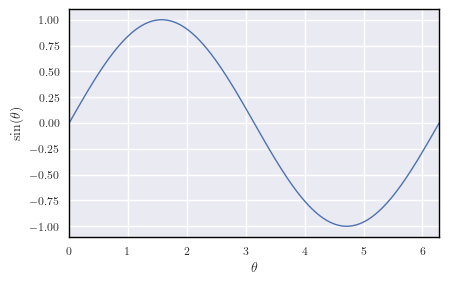

In [45]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



[0.  0.1 0.2 0.3 0.4 0.5 0.6]


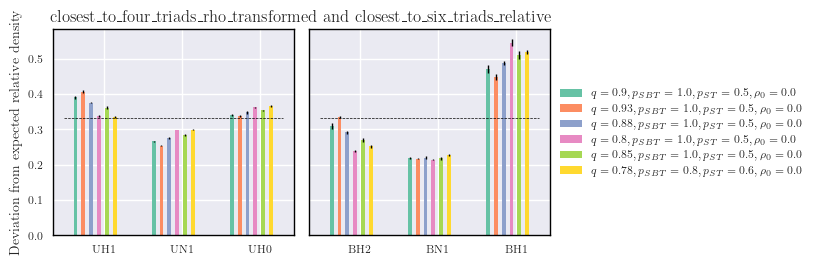

In [103]:
"""Many points
"""


save_ = False
fun_prepare_data = prepare_data4
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
addon = "_lvl3"
which_group = 6 #there can be `group_size` bars (8 at max). If data has more, which to show
group_size = 6

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df2_wrho_correct_g.iloc[inds_g3],  triads_set, 
                               std_data = df2_wrho_correct_g.iloc[inds_g3], addon = addon)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]
yerr = yerr.loc[:,~ydata.columns.duplicated()].copy() 
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy() 

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, yerr, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5, legend_elem = 4)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df2_wrho_correct_g.iloc[inds_g3],  triads_set, 
                               std_data = df2_wrho_correct_g.iloc[inds_g3], addon = addon)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]
yerr = yerr.loc[:,~ydata.columns.duplicated()].copy() 
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, yerr, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5, legend_elem = 4)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

try:
    plt.title(error_functions[0 + which_group*2].__name__ + " and " + error_functions[1 + which_group*2].__name__)
except IndexError:
    plt.title(error_functions[0 + which_group*2].__name__)

fname = 'barplots_sim'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [104]:
ydata, yerr = fun_prepare_data(df2_wrho_correct_g.iloc[inds_g3],  triads_set, std_data = df2_wrho_correct_g.iloc[inds_g3])

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata
# yerr

0.900     0.925     0.875     0.800                         0.850  \
              1.0       1.0       1.0       1.0                           1.0   
              0.5       0.5       0.5       0.5                           0.5   
              0.0       0.0       0.0       0.0                           0.0   
q           0.900     0.925     0.875     0.800                         0.850   
p             1.0       1.0       1.0       1.0                           1.0   
ps            0.5       0.5       0.5       0.5       0.5       0.5       0.5   
tr1_lvl  0.307135  0.332802  0.287354  0.237949  0.237949  0.237949  0.269813   
tr2_lvl  0.215939  0.213286  0.216924  0.213155  0.213155  0.213155  0.217135   
tr4_lvl  0.476927  0.453911  0.495722  0.548896  0.548896  0.548896  0.513052   

            0.775  
              0.8  
              0.6  
              0.0  
q           0.775  
p             0.8  
ps            0.6  
tr1_lvl  0.250627  
tr2_lvl  0.227172  
tr4_lvl  0.522201

In [64]:
yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]
yerr

0.900     0.925     0.875     0.800                      \
                  1.0       1.0       1.0       1.0                       
                  0.5       0.5       0.5       0.5                       
                  0.0       0.0       0.0       0.0       0.0       0.0   
tr3_lvl_std  0.003584  0.004250  0.001843  0.002027  0.002027  0.002027   
tr5_lvl_std  0.000717  0.002119  0.000967  0.000565  0.000565  0.000565   
tr6_lvl_std  0.002135  0.002559  0.002284  0.000991  0.000991  0.000991   

                0.850     0.775  
                  1.0       0.8  
                  0.5       0.6  
                  0.0       0.0  
tr3_lvl_std  0.004538  0.002373  
tr5_lvl_std  0.002079  0.001381  
tr6_lvl_std  0.002429  0.002429

In [120]:
wiki.transpose()
df2_wrho_correct_g.iloc[inds_g3]
wiki_prep, _ = fun_prepare_data(wiki, triads_set)
wiki_prep.values, wiki_prep.columns[0]

n_simulated = ydata.copy()
real_net_data = wiki_prep.copy()

data_name = real_net_data.columns[0]
real_data = [val[0] for val in real_net_data.values]
n_simulated[data_name] = real_data
n_simulated

0.9                                            0.85  \
                        0.5                0.8                          1.0   
         0.7000000000000001 0.6000000000000001                          0.5   
                        0.2                0.4                0.2       0.0   
q                       0.9                0.9                0.9      0.85   
p                       0.5                0.8                0.8       1.0   
ps       0.7000000000000001 0.6000000000000001 0.6000000000000001       0.5   
tr3_lvl3           0.337887           0.358533           0.353313  0.361760   
tr5_lvl3           0.254788           0.261201           0.262254  0.284487   
tr6_lvl3           0.407324           0.380266           0.384433  0.353753   

                      0.775       0.8     0.775 wiki elections  
                        0.8       1.0       0.9                 
         0.6000000000000001       0.5       0.5                 
                        0.0       0.0       0.0                 
q                     0.775       0.8     0.775                 
p                       0.8       1.0       0.9                 
ps       0.6000000000000001       0.5       0.5                 
tr3_lvl3           0.334780  0.338856  0.355402       0.335668  
tr5_lvl3           0.298916  0.298569  0.297918       0.302768  
tr6_lvl3           0.366304  0.362575  0.346680       0.361564

In [122]:
len(n_simulated.index)
len(n_simulated.columns)
real_net_data
n_simulated.columns[-1][0]

'wiki elections'

In [252]:
inds_g[group_size*which_group:group_size*(which_group+1)]

[1865, 1831, 1845, 1610, 1865, 1626]

### Notes (new, based on rho_init results with reps)

* I like $q=0.9$, $p_{SBT} = 0.8$, $p_{ST} = 0.6$, $\rho_0=0.4$ (good discrepancies 
for Delta2, slightly too big, but good for Delta1;  best in closestto 4 triads trans, best in closest to 6 triads corrdev trans, closest to 4 triads corrdev trans)
* I like $q=0.875$, $p_{SBT} = 0.8$, $p_{ST} = 0.6$, $\rho_0=0.4$ (good discrepancies 
for Delta2, slightly too big, but good for Delta1;  best in closestto 4 triads trans, best in closest to 6 triads corrdev trans, closest to 4 triads corrdev trans)
* I like $q=0.9$, $p_{SBT} = 0.8$, $p_{ST} = 0.6$, $\rho_0=0.2$ (similar as above; 
best in closest to 6 triads trans)
* I like $q=0.925$, $p_{SBT} = 0.8$, $p_{ST} = 0.6$, $\rho_0=0.2$ (similar as above; 
best in closest to 6 triads trans)
* I like $q=0.9$, $p_{SBT} = 0.5$, $p_{ST} = 0.7$, $\rho_0=0.2$ (similar as above; 
best in closest to 6 triads trans)
* I like $q=0.85$, $p_{SBT} = 1.0$, $p_{ST} = 0.5$, $\rho_0=0.0$ (perfect discrepancies for Delta1, good for Delta2, bad for BH2 (there is big discrepancy, but there shoudlnt be); best in closest to 6 triads relative)
* I like $q=0.775$, $p_{SBT} = 1.0$, $p_{ST} = 0.5$, $\rho_0=0.0$ (very good Delta1 densities, good over and under for Delta2, poor discrepancy where there shouldnt be; best in closest to 6 triads=)
* I like $q=0.775$, $p_{SBT} = 0.8$, $p_{ST} = 0.6$, $\rho_0=0.0$ (perfect Delta1 densities, good over and under for Delta2, poor discrepancy where there shouldnt be; best in closest to 6 triads relative)
* I like $q=0.8$, $p_{SBT} = 1.0$, $p_{ST} = 0.5$, $\rho_0=0.0$ (very good Delta1 densities, good over and under for Delta2, poor discrepancy where there shouldnt be; best in closest to 6 triads, best in closest to 6 triads rho trans, best in closest to 6 triads relative)
* I like $q=0.825$, $p_{SBT} = 1.0$, $p_{ST} = 0.5$, $\rho_0=0.0$ (very good Delta1 densities, good over and under for Delta2, poor discrepancy where there shouldnt be; best in closest to 6 triads rho trans)
* I like $q=0.75$, $p_{SBT} = 0.8$, $p_{ST} = 0.6$, $\rho_0=0.0$ (very good Delta1 densities, good over and under for Delta2, poor discrepancy where there shouldnt be; best in closest to 6 triads)
* I like $q=0.775$, $p_{SBT} = 0.9$, $p_{ST} = 0.5$, $\rho_0=0.0$ (good Delta1 densities, over-representation where there shouldn't be, good but too small over and under for Delta2; best in closest to 6 triads rho)
* I like $q=0.75$, $p_{SBT} = 0.9$, $p_{ST} = 0.5$, $\rho_0=0.0$ (good Delta1 densities, over-representation where there shouldn't be, good but too small over and under for Delta2; best in closest to 6 triads rho)
* I like $q=0.8$, $p_{SBT} = 0.9$, $p_{ST} = 0.5$, $\rho_0=0.0$ (good Delta1 densities, over-representation where there shouldn't be, good but too small over and under for Delta2; best in closest to 6 triads rho)

### Grouping above results

* (0.9, 0.5, 0.7, 0.2)

* (0.75-775, 0.8, 0.6, 0.0),  
* (0.9-0.925, 0.8, 0.6, 0.2)
* (0.875-0.9, 0.8, 0.6, 0.4)

* (0.75-0.8, 0.9, 0.5, 0.0), 
* (0.775-0.85, 1.0, 0.5, 0.0)


In [107]:
def get_inds(df, sets):
    """Finds inds looking for indexes but not exact values
    """
    inds = []
    for set_ in sets:
        q, p, ps, rho_init = set_
        ind_p = np.where((np.abs(df2_wrho_correct_g.q - q) < 1e-8) & (np.abs(df2_wrho_correct_g.p - p) < 1e-8) & 
                         (np.abs(df2_wrho_correct_g.ps - ps) < 1e-8) & (np.abs(df2_wrho_correct_g.rho_init - rho_init) < 1e-8) )
        if len(ind_p[0]) == 0:
            print("No index for " + set_)
        else:
            if len(ind_p[0]) > 1:
                print("Multiple points for " + set_)
            inds.extend(ind_p[0])
    return inds

In [108]:
sets = [(0.9, 0.5, 0.7, 0.2), (0.925, 0.8, 0.6, 0.2),
        (0.9, 0.8, 0.6, 0.4), (0.875, 0.8, 0.6, 0.4), (0.9, 0.8, 0.6, 0.2), 
        (0.85, 1.0, 0.5, 0.0), (0.775, 1.0, 0.5, 0.0), (0.775, 0.8, 0.6, 0.0), 
        (0.8, 1.0, 0.5, 0.0), (0.825, 1.0, 0.5, 0.0), (0.75, 0.8, 0.6, 0.0), 
        (0.775, 0.9, 0.5, 0.0), (0.75, 0.9, 0.5, 0.0), (0.8, 0.9, 0.5, 0.0)]

sets = [(0.9, 0.5, 0.7, 0.2), 
        (0.9, 0.8, 0.6, 0.4), (0.9, 0.8, 0.6, 0.2), 
        (0.85, 1.0, 0.5, 0.0), (0.775, 1.0, 0.5, 0.0), (0.775, 0.8, 0.6, 0.0), 
        (0.8, 1.0, 0.5, 0.0), (0.825, 1.0, 0.5, 0.0), 
        (0.775, 0.9, 0.5, 0.0)]

sets = [(0.9, 0.5, 0.7, 0.2), 
        (0.9, 0.8, 0.6, 0.4), (0.9, 0.8, 0.6, 0.2), 
        (0.85, 1.0, 0.5, 0.0), (0.775, 0.8, 0.6, 0.0), 
        (0.8, 1.0, 0.5, 0.0),
        (0.775, 0.9, 0.5, 0.0)]

inds = get_inds(df2_wrho_correct_g, sets)
df2_wrho_correct_g.iloc[inds]

q    p   ps  rho_init  repetitions   rho_lvl  \
0.900 0.5 0.7 0.2  0.900  0.5  0.7       0.2            5  0.895893   
      0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.916989   
              0.2  0.900  0.8  0.6       0.2            5  0.893451   
0.850 1.0 0.5 0.0  0.850  1.0  0.5       0.0            5  0.838019   
0.775 0.8 0.6 0.0  0.775  0.8  0.6       0.0            5  0.836517   
0.800 1.0 0.5 0.0  0.800  1.0  0.5       0.0            5  0.840489   
0.775 0.9 0.5 0.0  0.775  0.9  0.5       0.0            5  0.806144   

                   rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.900 0.5 0.7 0.2     0.002051              5  0.895893      0.002051  ...   
      0.8 0.6 0.4     0.000000              1  0.916989      0.000000  ...   
              0.2     0.001058              5  0.893451      0.001058  ...   
0.850 1.0 0.5 0.0     0.000942              5  0.838019      0.000942  ...   
0.775 0.8 0.6 0.0     0.000742              5  0.836517      0.000742  ...   
0.800 1.0 0.5 0.0     0.000725              5  0.840489      0.000725  ...   
0.775 0.9 0.5 0.0     0.000794              5  0.806144      0.000794  ...   

                   closest_to_six_triads  closest_to_six_triads_transformed  \
0.900 0.5 0.7 0.2               0.004356                           0.009082   
      0.8 0.6 0.4               0.005097                           0.009926   
              0.2               0.003663                           0.008830   
0.850 1.0 0.5 0.0               0.000964                           0.014975   
0.775 0.8 0.6 0.0               0.000932                           0.017137   
0.800 1.0 0.5 0.0               0.000884                           0.014360   
0.775 0.9 0.5 0.0               0.001772                           0.025275   

                   closest_to_six_triads_corrdevs_transformed  \
0.900 0.5 0.7 0.2                                    0.008526   
      0.8 0.6 0.4                                    0.006487   
              0.2                                    0.008004   
0.850 1.0 0.5 0.0                                    0.011398   
0.775 0.8 0.6 0.0                                    0.015031   
0.800 1.0 0.5 0.0                                    0.013980   
0.775 0.9 0.5 0.0                                    0.016047   

                   closest_to_four_triads_corrdevs_transformed  \
0.900 0.5 0.7 0.2                                     0.008526   
      0.8 0.6 0.4                                     0.006487   
              0.2                                     0.008004   
0.850 1.0 0.5 0.0                                     0.011398   
0.775 0.8 0.6 0.0                                     0.015031   
0.800 1.0 0.5 0.0                                     0.013980   
0.775 0.9 0.5 0.0                                     0.016047   

                   closest_to_six_triads_rho  \
0.900 0.5 0.7 0.2                   0.055926   
      0.8 0.6 0.4                   0.079835   
              0.2                   0.053199   
0.850 1.0 0.5 0.0                   0.010745   
0.775 0.8 0.6 0.0                   0.010006   
0.800 1.0 0.5 0.0                   0.011863   
0.775 0.9 0.5 0.0                   0.002517   

                   closest_to_six_triads_rho_transformed  \
0.900 0.5 0.7 0.2                               0.029710   
      0.8 0.6 0.4                               0.039821   
              0.2                               0.028644   
0.850 1.0 0.5 0.0                               0.018887   
0.775 0.8 0.6 0.0                               0.020767   
0.800 1.0 0.5 0.0                               0.018751   
0.775 0.9 0.5 0.0                               0.025573   

                   closest_to_four_triads_rho  \
0.900 0.5 0.7 0.2                    0.053641   
      0.8 0.6 0.4                    0.077323   
              0.2                    0.051294   
0.850 1.0 0.5 0.0                    0.010001   
0.775 0.8 0.6 0.0                  

In [161]:
df2_wrho_correct_g.iloc[inds].rho.values
wiki_rho.values[0]

0.7947289140762432

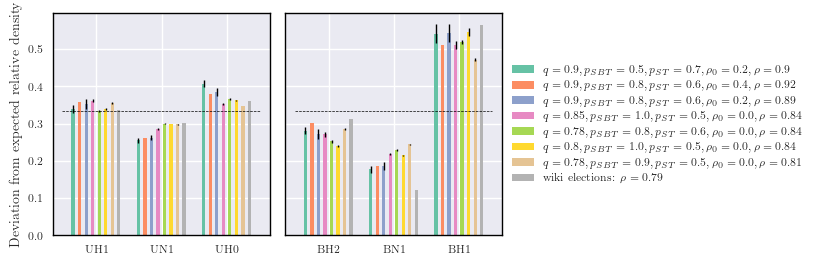

In [167]:
"""Many points
"""


save_ = False
fun_prepare_data = prepare_data4
linewidth = 0.5
addon = "_lvl3"
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
which_group = 0 #there can be `group_size` bars (8 at max). If data has more, which to show. If `add_real_data == True`, then there should be 7 at max. 
group_size = 7
add_real_data = True
show_error = True
show_rho = True

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df2_wrho_correct_g.iloc[inds],  triads_set, 
                               std_data = df2_wrho_correct_g.iloc[inds], addon = addon)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
if show_error:
    yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]
    yerr = yerr.loc[:,~ydata.columns.duplicated()].copy() 
else:
    yerr = None
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy() 
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

if add_real_data:
    real_net_data, _ = fun_prepare_data(wiki,  triads_set)
else:
    real_net_data = None

if show_rho:
    rhos = df2_wrho_correct_g.iloc[inds].rho.values
    wiki_rho = wiki.rho.values[0]
else:
    rhos = None
    wiki_rho = None

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, yerr, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5, legend_elem = 4, 
              real_net_data = real_net_data, additional_label_data = rhos, real_net_additional_label_data = wiki_rho)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df2_wrho_correct_g.iloc[inds],  triads_set, 
                               std_data = df2_wrho_correct_g.iloc[inds], addon = addon)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
if show_error:
    yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]
    yerr = yerr.loc[:,~ydata.columns.duplicated()].copy() 
else:
    yerr = None
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

if add_real_data:
    real_net_data, _ = fun_prepare_data(wiki,  triads_set)
else:
    real_net_data = None

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, yerr, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5, legend_elem = 4, 
              real_net_data = real_net_data, additional_label_data = rhos, real_net_additional_label_data = wiki_rho)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
# print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_wiki_rhoinit_s2000_repeat5'
# fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

if show_error:
    fname = fname + "_err"
if add_real_data:
    fname = fname + "_real"
if show_rho:
    fname = fname + "_rho"

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [137]:
real_data

[0.3356682211775576, 0.30276752882712465, 0.3615642499953177]

In [254]:
sets = [(0.9, 0.0, 0.8, 0.0), (0.9, 0.8, 0.6, 0.4), (0.9, 0.8, 0.6, 0.2), 
        (0.925, 0.7, 0.6, 0.2), (0.925, 0.7, 0.6, 0.0)]

sets = [(0.9, 0.8, 0.6, 0.4), (0.9, 0.8, 0.6, 0.2), 
        (0.925, 0.7, 0.6, 0.2), (0.925, 0.7, 0.6, 0.0), (0.85, 0.6, 0.7, 0.4), 
        (0.85, 1.0, 0.5, 0.0), (0.9, 0.4, 0.7, 0.0), (0.925, 0.3, 0.7, 0.0)] 
        # (0.775, 1.0, 0.5, 0.0)]

sets = [(0.9, 0.8, 0.6, 0.4), (0.9, 0.8, 0.6, 0.2), 
        (0.925, 0.7, 0.6, 0.0), (0.85, 0.6, 0.7, 0.4), 
        (0.85, 1.0, 0.5, 0.0), (0.9, 0.4, 0.7, 0.0), (0.925, 0.3, 0.7, 0.0), 
        (0.775, 1.0, 0.5, 0.0)]

inds = get_inds(df2_joined_correct_g, sets)
df2_joined_correct_g.iloc[inds]

q    p   ps  rho_init  repetitions   rho_lvl  \
0.900 0.8 0.6 0.4  0.900  0.8  0.6       0.4            1  0.915134   
              0.2  0.900  0.8  0.6       0.2            1  0.891006   
0.925 0.7 0.6 0.0  0.925  0.7  0.6       0.0            1  0.851985   
0.850 0.6 0.7 0.4  0.850  0.6  0.7       0.4            1  0.913060   
      1.0 0.5 0.0  0.850  1.0  0.5       0.0            1  0.830820   
0.900 0.4 0.7 0.0  0.900  0.4  0.7       0.0            1  0.840841   
0.925 0.3 0.7 0.0  0.925  0.3  0.7       0.0            1  0.842721   
0.775 1.0 0.5 0.0  0.775  1.0  0.5       0.0            1  0.835193   

                   rho_lvl_std  rho_lvl_valid  rho_lvl2  rho_lvl2_std  ...  \
0.900 0.8 0.6 0.4          0.0              1  0.915134           0.0  ...   
              0.2          0.0              1  0.891006           0.0  ...   
0.925 0.7 0.6 0.0          0.0              1  0.851985           0.0  ...   
0.850 0.6 0.7 0.4          0.0              1  0.913060           0.0  ...   
      1.0 0.5 0.0          0.0              1  0.830820           0.0  ...   
0.900 0.4 0.7 0.0          0.0              1  0.840841           0.0  ...   
0.925 0.3 0.7 0.0          0.0              1  0.842721           0.0  ...   
0.775 1.0 0.5 0.0          0.0              1  0.835193           0.0  ...   

                   closest_to_six_triads  closest_to_six_triads_transformed  \
0.900 0.8 0.6 0.4               0.005310                           0.010699   
              0.2               0.003697                           0.008505   
0.925 0.7 0.6 0.0               0.001727                           0.008609   
0.850 0.6 0.7 0.4               0.005056                           0.008823   
      1.0 0.5 0.0               0.000820                           0.011800   
0.900 0.4 0.7 0.0               0.001503                           0.009449   
0.925 0.3 0.7 0.0               0.001845                           0.010226   
0.775 1.0 0.5 0.0               0.000774                           0.015972   

                   closest_to_six_triads_corrdevs_transformed  \
0.900 0.8 0.6 0.4                                    0.006890   
              0.2                                    0.008062   
0.925 0.7 0.6 0.0                                    0.007318   
0.850 0.6 0.7 0.4                                    0.007262   
      1.0 0.5 0.0                                    0.010422   
0.900 0.4 0.7 0.0                                    0.008631   
0.925 0.3 0.7 0.0                                    0.009665   
0.775 1.0 0.5 0.0                                    1.015712   

                   closest_to_four_triads_corrdevs_transformed  \
0.900 0.8 0.6 0.4                                     0.006890   
              0.2                                     0.008062   
0.925 0.7 0.6 0.0                                     0.007318   
0.850 0.6 0.7 0.4                                     0.007262   
      1.0 0.5 0.0                                     0.010422   
0.900 0.4 0.7 0.0                                     0.008631   
0.925 0.3 0.7 0.0                                     0.009665   
0.775 1.0 0.5 0.0                                     0.015712   

                   closest_to_six_triads_rho  \
0.900 0.8 0.6 0.4                   0.079833   
              0.2                   0.050445   
0.925 0.7 0.6 0.0                   0.018938   
0.850 0.6 0.7 0.4                   0.075343   
      1.0 0.5 0.0                   0.007907   
0.900 0.4 0.7 0.0                   0.015064   
0.925 0.3 0.7 0.0                   0.014670   
0.775 1.0 0.5 0.0                   0.009260   

                   closest_to_six_triads_rho_transformed  \
0.900 0.8 0.6 0.4                               0.040508   
              0.2                               0.027204   
0.925 0.7 0.6 0.0                               0.015493   
0.850 0.6 0.7 0.4                               0.036937   
      1.0 0.5 0.0                               0.0146

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7]


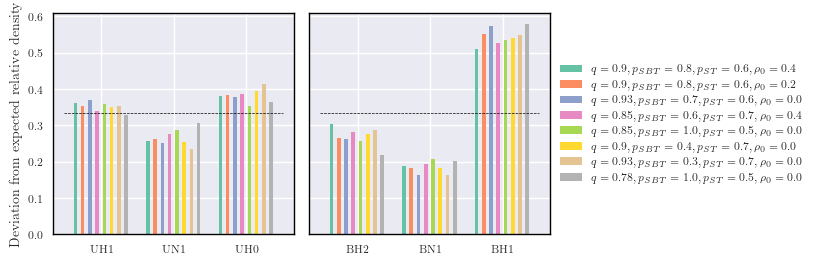

In [256]:
"""Many points
"""


save_ = True
fun_prepare_data = prepare_data4
linewidth = 0.5
addon = "_lvl3"
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
# which_group = 6 #there can be `group_size` bars (8 at max). If data has more, which to show
# group_size = 6

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df2_joined_correct_g.iloc[inds],  triads_set, 
                               std_data = None, addon = addon)

# ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy() 
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5, legend_elem = 4)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df2_joined_correct_g.iloc[inds],  triads_set, 
                               std_data = None, addon = addon)

# ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5, legend_elem = 4)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_wiki_rhoinit_new'
# fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [222]:
# 0.8, 0.4, 0.9 (looking good overall, best in closest to 4 triads transformed, 6 triads trans, 4 triads corrdev trans, )
# 0.8, 0.7, 0.7 (slightly worse than above, best in closest to 4 triads trans, 6 triads trans, 6 triads corrdev trans, 4 triads corrdev trans, )

sets_g = [(0.8, 0.4, 0.9), (0.8, 0.7, 0.7)]
df2_w1000_g.loc[sets_g]

q    p   ps  repetitions   rho_lvl  rho_lvl_std  rho_lvl_valid  \
0.8 0.4 0.9  0.8  0.4  0.9            1  0.965761          0.0              1   
    0.7 0.7  0.8  0.7  0.7            1  0.963461          0.0              1   

             rho_lvl2  rho_lvl2_std  rho_lvl2_valid  ...  \
0.8 0.4 0.9  0.965761           0.0               1  ...   
    0.7 0.7  0.963461           0.0               1  ...   

             closest_to_four_triads  closest_to_four_triads_transformed  \
0.8 0.4 0.9                0.007137                            0.002214   
    0.7 0.7                0.006283                            0.003106   

             closest_to_six_triads  closest_to_six_triads_transformed  \
0.8 0.4 0.9               0.012661                           0.003949   
    0.7 0.7               0.011340                           0.004401   

             closest_to_six_triads_corrdevs_transformed  \
0.8 0.4 0.9                                    1.002214   
    0.7 0.7                                    1.003106   

             closest_to_four_triads_corrdevs_transformed  \
0.8 0.4 0.9                                     0.002214   
    0.7 0.7                                     0.003106   

             closest_to_six_triads_rho  closest_to_six_triads_rho_transformed  \
0.8 0.4 0.9                   0.158921                               0.062453   
    0.7 0.7                   0.153692                               0.061342   

             closest_to_four_triads_rho  \
0.8 0.4 0.9                    0.153397   
    0.7 0.7                    0.148635   

             closest_to_four_triads_rho_transformed  
0.8 0.4 0.9                                0.060718  
    0.7 0.7                                0.060046  

[2 rows x 50 columns]

[0.  0.1 0.2 0.3 0.4 0.5 0.6]


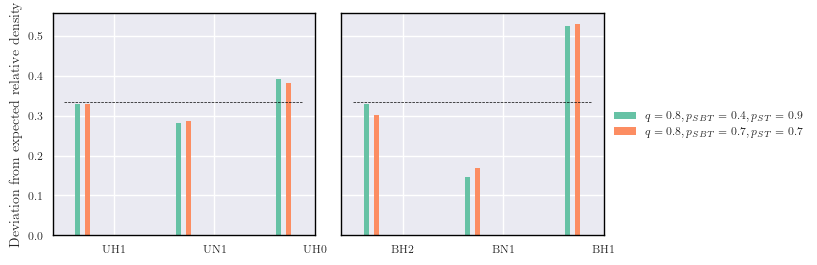

In [257]:
"""Many points
"""


save_ = True
fun_prepare_data = prepare_data4
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
# which_group = 6 #there can be `group_size` bars (8 at max). If data has more, which to show
# group_size = 6

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df2_w1000_g.loc[sets_g],  triads_set, std_data = None)

# ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy() 
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df2_w1000_g.loc[sets_g],  triads_set, std_data = None)

# ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_wiki2_s1000_sim_best_grouped'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [226]:
df2_w1000_g.loc[sets_g]

q    p   ps  repetitions   rho_lvl  rho_lvl_std  rho_lvl_valid  \
0.8 0.4 0.9  0.8  0.4  0.9            1  0.965761          0.0              1   
    0.7 0.7  0.8  0.7  0.7            1  0.963461          0.0              1   

             rho_lvl2  rho_lvl2_std  rho_lvl2_valid  ...  \
0.8 0.4 0.9  0.965761           0.0               1  ...   
    0.7 0.7  0.963461           0.0               1  ...   

             closest_to_four_triads  closest_to_four_triads_transformed  \
0.8 0.4 0.9                0.007137                            0.002214   
    0.7 0.7                0.006283                            0.003106   

             closest_to_six_triads  closest_to_six_triads_transformed  \
0.8 0.4 0.9               0.012661                           0.003949   
    0.7 0.7               0.011340                           0.004401   

             closest_to_six_triads_corrdevs_transformed  \
0.8 0.4 0.9                                    1.002214   
    0.7 0.7                                    1.003106   

             closest_to_four_triads_corrdevs_transformed  \
0.8 0.4 0.9                                     0.002214   
    0.7 0.7                                     0.003106   

             closest_to_six_triads_rho  closest_to_six_triads_rho_transformed  \
0.8 0.4 0.9                   0.158921                               0.062453   
    0.7 0.7                   0.153692                               0.061342   

             closest_to_four_triads_rho  \
0.8 0.4 0.9                    0.153397   
    0.7 0.7                    0.148635   

             closest_to_four_triads_rho_transformed  
0.8 0.4 0.9                                0.060718  
    0.7 0.7                                0.060046  

[2 rows x 50 columns]

In [239]:
i_l = (df_w1000.q == sets_g[0][0]) & (df_w1000.p == sets_g[0][1]) & (df_w1000.ps == sets_g[0][2])

np.where(i_l)[0]

df_w1000[i_l]

,index,q,p,ps,rho_init,steps,cur_steps,rho,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,Lplus
754,0,0.8,0.4,0.9,0.794729,1000,"[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...","[0.7966249881495371, 0.887615476177936, 0.9146...","[0.008919260960182734, 0.001646694733395157, 0...","[0.0342410508784385, 0.014763886521662693, 0.0...","[0.03411355617617889, 0.009264167681032411, 0....","[0.13266561897335896, 0.08812568025133903, 0.0...","[0.03354184309025685, 0.011954976923458892, 0....","[0.12960977226762077, 0.0777113761509752, 0.05...","[0.12780739979251915, 0.07661223761254762, 0.0...","[0.49910149786144414, 0.719920980125589, 0.792...","[75626.0, 84264.0, 86831.0, 88252.0, 89266.0, ..."


In [251]:
a[0]

array([0.13266562, 0.08812568, 0.06833716, 0.05635668, 0.04968536,
       0.04329988, 0.03780553, 0.032181  , 0.03035179, 0.02830248,
       0.02518893, 0.02233036, 0.02092255, 0.02009451, 0.01952145,
       0.01741309, 0.01753656, 0.01662665, 0.01672462, 0.01599186,
       0.01677293, 0.01703732, 0.01477328, 0.01574358, 0.01669107,
       0.01536512, 0.01297493, 0.01307559, 0.01250388, 0.01132421,
       0.01295615, 0.01316953, 0.01302996, 0.01434651, 0.01351712,
       0.01472765, 0.01487393, 0.01584155, 0.01537989, 0.01635287,
       0.01474912, 0.01534097, 0.01630993, 0.01562011, 0.01390229,
       0.01542015, 0.01491822, 0.01685077, 0.01673267, 0.01464579,
       0.0147357 , 0.01527655, 0.01355067, 0.01475986, 0.01464847,
       0.01552751, 0.01646292, 0.01546309, 0.0150323 , 0.01457063,
       0.01488736, 0.01461358, 0.0166186 , 0.01568856, 0.01562146,
       0.01542015, 0.01596905, 0.01471423, 0.01519737, 0.01608715,
       0.01583753, 0.01442301, 0.01335608, 0.01455184, 0.01302

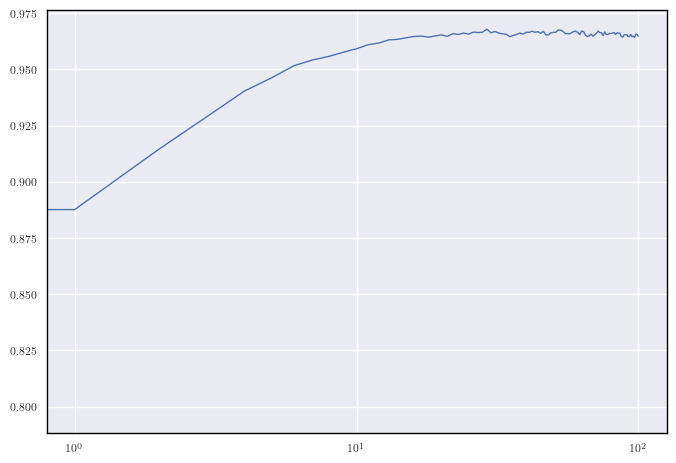

In [255]:
a = df_w1000[i_l]["rho"].values[0]
plt.plot(a)
    
# plt.legend(deg_triads)
plt.xscale('log')

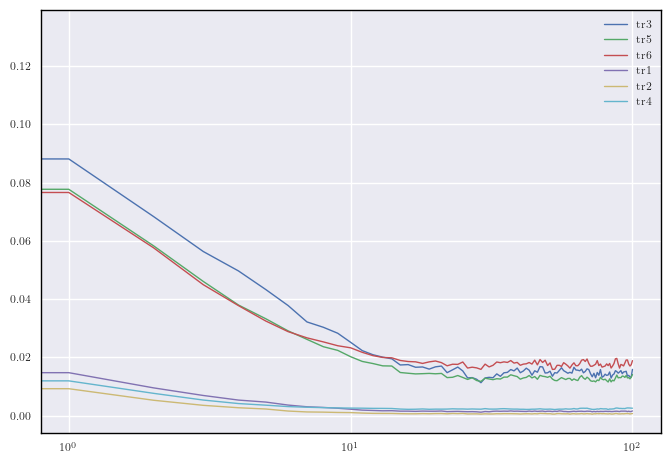

In [253]:
# inds = np.where(df_w1000.rho_init > 0)[0]
# inds2 = np.where(df_w1000.rho_init < 0)[0]

for triad in deg_triads:
    # print(triad)
    a = df_w1000[i_l][triad].values[0]
    plt.plot(a)
    
plt.legend(deg_triads)
plt.xscale('log')

[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]


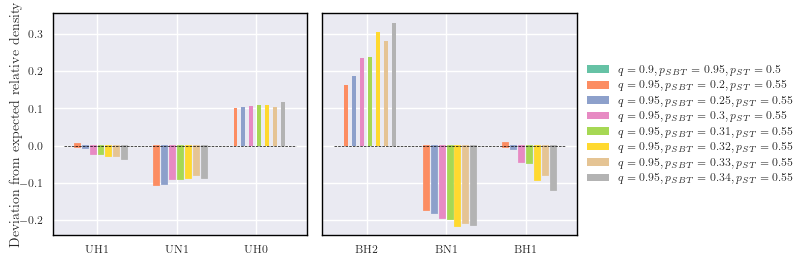

In [68]:
"""Many points
"""


save_ = False
fun_prepare_data = prepare_data5
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
which_eight = 0 #there can be 8 bars at max. If data has more, which to show

df_data = df32long_g

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df32long_g,  triads_set, std_data = df32long_g)

ydata = ydata[ydata.columns[8*which_eight:8*(which_eight+1)]]
yerr = yerr[yerr.columns[8*which_eight:8*(which_eight+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df32long_g,  triads_set, std_data = df32long_g)

ydata = ydata[ydata.columns[8*which_eight:8*(which_eight+1)]]
yerr = yerr[yerr.columns[8*which_eight:8*(which_eight+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_sim'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_eight)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [58]:
col = ydata.columns[1]

In [60]:
[val for ind, val in enumerate(ydata[col] < 0.01)]

[False, True, True]

In [119]:
# Checking if detailed balance equation works
# Let me check pi+ and pi-when ps=0.5. In such a case pi+ and pi- are dependent only on psbt

def pi_plus_minus(pb, ps, q, BN1 = None, UN1 = None, UH0 = None, UH1 = None, UH2 = None, n1 = None, n2 = None, n3 = None, rho = None):
    tr_l = [BN1 , UN1 , UH0 , UH1 , UH2 , n1, n2, n3, rho]
    if not any(tr_l):
        if not any(np.array(tr_l) == 0):
            raise ValueError("Triads densities and link densities not given. ")
    if rho:
        n1 = 3*rho**2 * (1-rho)
        n2 = 3*rho*(1-rho)**2
        n3 = (1-rho)**3
    if all([n1, n2, n3]):
        BN1 = n2/3
        UN1 = n1/3
        UH0 = n1/3
        UH1 = n1/3
        UH2 = n3
    
    plus = q*(BN1 + UN1)*(1-ps) + (1-q)*((1-pb)*(UH1 + UN1) + UH0)
    minus = q*(BN1 + UN1)*ps + (1-q)*(pb*(UH1 + UN1) + UH2)
    return (plus,minus)


q = 0.95
# q=0.15
ps = 0.5
pb = 0.7422145328719724
rho = 0.85

plus,minus = pi_plus_minus(pb, ps, q, rho = rho)

# assert(abs(plus - minus) < 1e-5)
print(plus-minus, plus)

# q=0.95
row = df2_g.loc[(q,pb,ps)]

BN1 = row[triad_names_map['BN1'] + '_lvl']
UN1 = row[triad_names_map['UN1'] + '_lvl']
UH0 = row[triad_names_map['UH0'] + '_lvl']
UH1 = row[triad_names_map['UH1'] + '_lvl']
UH2 = row[triad_names_map['UH2'] + '_lvl']

# q=0.15
plus,minus = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)

# assert(abs(plus - minus) < 1e-5)
plus-minus, plus

0.0 0.068775


(2.2188545843876417e-05, 0.07305424308175813)

In [74]:
df2.iloc[[301]].p.values[0]

0.1833910034602075

In [58]:
q = 0.1
# q=0.15
ps = 0.8
pb = 0.7226066897347174
rho = 0.85

plus,minus = pi_plus_minus(pb, ps, q, rho = rho)

# assert(abs(plus - minus) < 1e-5)
print(plus-minus, plus)

# q=0.95
row = df2_g.loc[(q,pb,ps)]

BN1 = row[triad_names_map['BN1'] + '_lvl']
UN1 = row[triad_names_map['UN1'] + '_lvl']
UH0 = row[triad_names_map['UH0'] + '_lvl']
UH1 = row[triad_names_map['UH1'] + '_lvl']
UH2 = row[triad_names_map['UH2'] + '_lvl']

# q=0.15
plus,minus = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)

# assert(abs(plus - minus) < 1e-5)
plus-minus, plus

-2.7755575615628914e-17 0.15419999999999998


(0.00032214188978632596, 0.12281695480086882)

In [75]:
q = 0.95
# q=0.15
ps = 0.55
pb = 0.1833910034602075
rho = 0.85

plus,minus = pi_plus_minus(pb, ps, q, rho = rho)

# assert(abs(plus - minus) < 1e-5)
print(plus-minus, plus)

# q=0.95
row = df2_g.loc[(q,pb,ps)]

BN1 = row[triad_names_map['BN1'] + '_lvl']
UN1 = row[triad_names_map['UN1'] + '_lvl']
UH0 = row[triad_names_map['UH0'] + '_lvl']
UH1 = row[triad_names_map['UH1'] + '_lvl']
UH2 = row[triad_names_map['UH2'] + '_lvl']

# q=0.15
plus,minus = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)

# assert(abs(plus - minus) < 1e-5)
plus-minus, plus

0.0 0.068775


(0.00011295027692963255, 0.07286826851545948)

In [ ]:
301,603

In [80]:
df2.iloc[[301]]

,index,q,p,ps,rho_init,steps,rho,bp,tr0,tr1,...,tr5_qs_b,tr5_qs_f,tr6_qs_m,tr6_qs_s,tr6_qs_b,tr6_qs_f,tr7_qs_m,tr7_qs_s,tr7_qs_b,tr7_qs_f
301,0,0.95,0.183391,0.55,0.85,4000,"[0.8366935483870968, 0.8205645161290323, 0.819...",279.0,"[0.004737903225806452, 0.00625, 0.006989247311...","[0.021740591397849462, 0.02896505376344086, 0....",...,2001.0,3999.0,0.167669,0.007611,2004.0,3971.0,0.302656,0.073614,2000.0,3971.0


In [127]:
row.p.values

array([0.72260669])

In [198]:
row = df2.iloc[[512]]
pb = row.p.values[0]
ps = row.ps.values[0]
q = row.q.values[0]

s = row.steps.values[0]

pluss = np.zeros(s)
minuss = np.zeros(s)

for i in range(s):
    BN1 = row[triad_names_map['BN1']].values[0][i]
    UN1 = row[triad_names_map['UN1']].values[0][i]
    UH0 = row[triad_names_map['UH0']].values[0][i]
    UH1 = row[triad_names_map['UH1']].values[0][i]
    UH2 = row[triad_names_map['UH2']].values[0][i]
    # print(UH2)
    # break
    
    try:
        pluss[i], minuss[i] = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)
    except ValueError:
        print(i)
        break

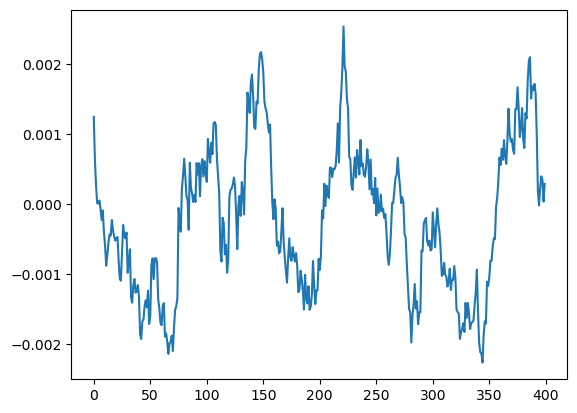

In [199]:
plt.plot(minuss - pluss)

In [130]:
beg = 200
np.mean(-pluss[beg:] + minuss[beg:])

0.0016557634083045026

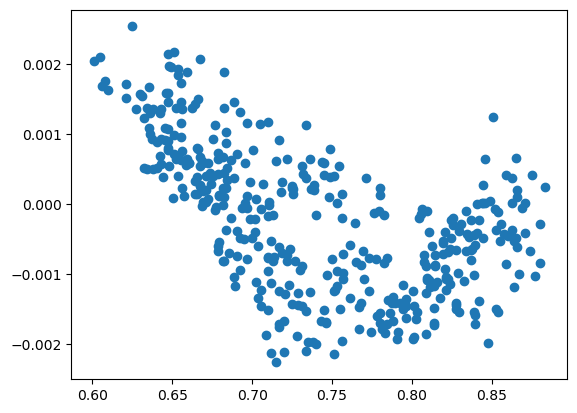

In [200]:
rho = row.rho.values[0]
# rho
# row.rho.values[0]
plt.scatter(rho, minuss - pluss)

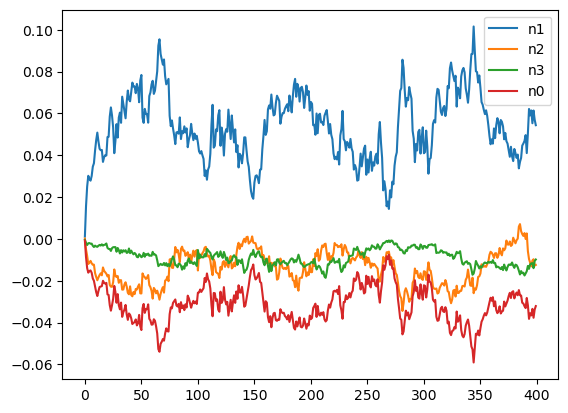

In [201]:
n1_rho = 3*rho**2*(1-rho) 
n2_rho = 3*rho*(1-rho)**2
n3_rho = (1-rho)**3 
n0_rho = rho**3

n2_true = row[triad_names_map['BN1']].values[0] + row[triad_names_map['BH1']].values[0] + row[triad_names_map['BH2']].values[0]
n1_true = row[triad_names_map['UN1']].values[0] + row[triad_names_map['UH1']].values[0] + row[triad_names_map['UH0']].values[0]
n3_true = row[triad_names_map['UH2']].values[0]
n0_true = row[triad_names_map['BH0']].values[0]

plt.plot(n1_rho - n1_true)
plt.plot(n2_rho - n2_true)
plt.plot(n3_rho - n3_true)
plt.plot(n0_rho - n0_true)

plt.legend(['n1', 'n2', 'n3', 'n0'])

/tmp/ipykernel_76370/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

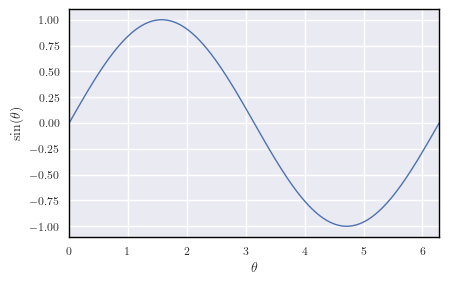

In [129]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



In [130]:
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])
figsize = (figsize[0] * 1.7, figsize[1] * 1.7)
# figsize = 

In [ ]:
"""Four triads
"""


save_ = True
fun_prepare_data = prepare_data2
linewidth = None
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'

reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

sim_data = mean_data.copy()
sim_data_std = std_data.copy()
real_data = results_realnet.copy()
if reverse:
    order = results_realnet.columns.tolist()
    order.reverse()
    real_data = results_realnet[order]
    
    order = mean_data.columns.tolist()
    order.reverse()
    sim_data = sim_data[order]
    std_data_std = std_data[order]

triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0] , figsize[1])
# figsize = 

if fun_prepare_data == prepare_data2:
    line_level = 0
else:
    line_level = 1/3


sim_pos = 0
real_pos = 1
if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)


# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:8]
sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
print(sim_labels)
# plot_bar_simulatednets(ax=axes[sim_pos, 0], triads_set=n1_triads, title='n1', labels=sim_labels, colors=colors)
triads_set = triads
ydata, yerr = prepare_data3(sim_data, all_sets, triads_set, std_data = sim_data_std)
print(ydata)
title = r'$\Delta_1$'
plot_bar_nets(axes[sim_pos], ydata, yerr, triads_set, None, labels = sim_labels, line_level = line_level, linewidth = linewidth, colors=colors[0:3][::-1], width = 0.2, smallest_edge = True)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
# triads_set = n2_triads
# ydata, yerr = fun_prepare_data(mean_data, triads_set, std_data = std_data)
# title = r'$\Delta_2$'

# plot_bar_nets(axes[sim_pos, 1], ydata, yerr, triads_set, title, labels = sim_labels, line_level = line_level, colors=colors, linewidth = linewidth)

# Realnets
triads_set = triads
ydata, _ = prepare_data3(real_data, all_sets, triads_set)

plot_bar_nets(axes[real_pos], ydata, None, triads_set, None, labels = None, line_level = line_level, colors=colors[3:], linewidth = linewidth, width = 0.2)
# plot_bar_realnets(ax=axes[real_pos, 1], triads_set=n2_triads, title='')
# triads_set = n2_triads

# ydata, _ = fun_prepare_data(results_realnet, triads_set)

# plot_bar_nets(axes[real_pos, 1], ydata, None, triads_set, None, labels = None, line_level = line_level, colors=colors, linewidth = linewidth)

# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in (sim_pos, real_pos):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    axes[i].legend(loc='upper left')
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_sim_real'
fname = fname + "_down"
fname = fname + "_down_nx"
fname = fname + "_v2"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

if reverse is True:
    fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(save_fig_path / fname, format='pdf', bbox_inches='tight') 

### Time series of specific triad densities

In [ ]:

outputs_dir_triads_wiki2 = Path("../../outputs/LtdReal/outputs/wiki2-s400-triads")
outputs_dir_triads_wiki2_1000 = Path("../../outputs/LtdReal/outputs/wiki2-s1000-triads")

In [54]:
# df, rho_inits = process_folder(outputs_dir_test)
df_w2 = process_folder(outputs_dir_triads_wiki2, no_triad_stats=False)
# df.head(3)
df_w2_1000 = process_folder(outputs_dir_triads_wiki2_1000, no_triad_stats=False)
# df.head(3)
df_w2

,index,q,p,ps,rho_init,steps,rho,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,Lplus
0,0,0.8,1.0,1.0,0.794729,400,"[0.7905982007734993, 0.8482428115015974, 0.873...","[0.008964818904505015, 0.0041653903414844255, ...","[0.03393442118597251, 0.0231517585197214, 0.01...","[0.03433437356622422, 0.019660535401136187, 0....","[0.12985209787730959, 0.11106236180575156, 0.0...","[0.03431297143216393, 0.021628194101304326, 0....","[0.12943341862975513, 0.11174187956216584, 0.0...","[0.13076971437514462, 0.1045574506848014, 0.08...","[0.495107605917155, 0.6007418514718649, 0.6631...","[75227.0, 80712.0, 83113.0, 84673.0, 85902.0, ..."
1,1,0.8,1.0,1.0,0.794729,400,"[0.7962418025895409, 0.853371447788801, 0.8789...","[0.008188991544819413, 0.0036223111897045034, ...","[0.032602138340719296, 0.02187298100961892, 0....","[0.03272386297818721, 0.018075439847295774, 0....","[0.12632342102411886, 0.1076741364573315, 0.09...","[0.03322948839536162, 0.020282534922263437, 0....","[0.12943743152989143, 0.11000295616976707, 0.0...","[0.1288783007775663, 0.10135916927616645, 0.08...","[0.5053257872975659, 0.6138198930160824, 0.675...","[75764.0, 81200.0, 83631.0, 85276.0, 86389.0, ..."
2,0,0.8,1.0,1.0,-0.500000,400,"[0.7928997814023877, 0.8318164620817219, 0.851...","[0.012419925921863483, 0.0069623817364888995, ...","[0.02741479609785591, 0.020056474881251597, 0....","[0.01068902832973733, 0.007189779410879507, 0....","[0.07192053387623414, 0.0634921059566152, 0.05...","[0.04946166944671471, 0.03921941066548598, 0.0...","[0.0648712059701253, 0.05916084907616351, 0.05...","[0.07746903713136497, 0.06540893458839014, 0.0...","[0.6824632251143342, 0.7352194855729552, 0.771...","[75446.0, 79149.0, 80981.0, 82270.0, 83252.0, ..."
3,1,0.8,1.0,1.0,-0.500000,400,"[0.7929102909029763, 0.8312384395493526, 0.850...","[0.01241591302172718, 0.007276725580499446, 0....","[0.02741345846447714, 0.01987589437511788, 0.0...","[0.010690365963116098, 0.007045315005972533, 0...","[0.0719218715096129, 0.06312291914407515, 0.05...","[0.04946300708009348, 0.03939731590486217, 0.0...","[0.0648712059701253, 0.05971329166159481, 0.05...","[0.07747037476474374, 0.06528453468416469, 0.0...","[0.6824632251143342, 0.7349934255319434, 0.767...","[75447.0, 79094.0, 80888.0, 82113.0, 83105.0, ..."
4,2,0.8,1.0,1.0,-0.500000,400,"[0.7928997814023877, 0.8314486295611233, 0.850...","[0.012419925921863483, 0.007098820341123265, 0...","[0.02741479609785591, 0.0199467889441926, 0.01...","[0.01068902832973733, 0.007183091243985666, 0....","[0.07192053387623414, 0.061977904971849504, 0....","[0.04946166944671471, 0.038729836848856794, 0....","[0.0648712059701253, 0.059132758775209376, 0.0...","[0.07746903713136497, 0.06457291372665996, 0.0...","[0.6824632251143342, 0.7380673070363528, 0.774...","[75446.0, 79114.0, 80956.0, 82249.0, 83252.0, ..."
5,3,0.8,1.0,1.0,-0.500000,400,"[0.7928997814023877, 0.8307550025222802, 0.850...","[0.012419925921863483, 0.007375710450528298, 0...","[0.02741479609785591, 0.02028788545577851, 0.0...","[0.01068902832973733, 0.007045315005972533, 0....","[0.07192053387623414, 0.06359109082664405, 0.0...","[0.04946166944671471, 0.03900538932488306, 0.0...","[0.0648712059701253, 0.06028312348095009, 0.05...","[0.07746903713136497, 0.0657607321670062, 0.05...","[0.6824632251143342, 0.7333601751764672, 0.769...","[75446.0, 79048.0, 80937.0, 82295.0, 83321.0, ..."
6,4,0.8,1.0,1.0,-0.500000,400,"[0.7928997814023877, 0.8313330250546495, 0.851...","[0.012419925921863483, 0.0074305534190577975, ...","[0.02741479609785591, 0.02013138235046262, 0.0...","[0.01068902832973733, 0.007181753610606897, 0....","[0.07192053387623414, 0.06326069538208828, 0.0...","[0.04946166944671471, 0.03866964334681222, 0.0...","[0.0648712059701253, 0.059535386422218624, 0.0...","[0.07746903713136497, 0.06499961877448705, 0.0...","[0.6824632251143342, 0.7355003885824966, 0.769...","[75446.0, 79103.0, 81003.0, 82313.0, 83292.0, ..."
7,5,0.8,1.0,1.0,-0.500000,400,"[0.7928997814023877, 0.8319530855893728, 0.852..."

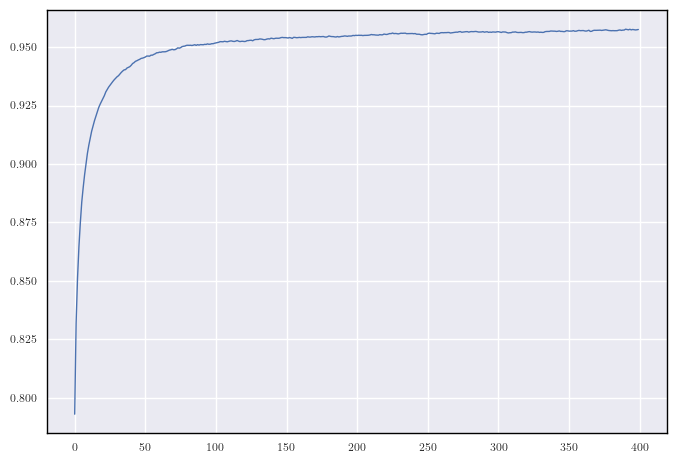

In [39]:
df_one = df_w2.iloc[0].rho
df_one
plt.plot(df_one)

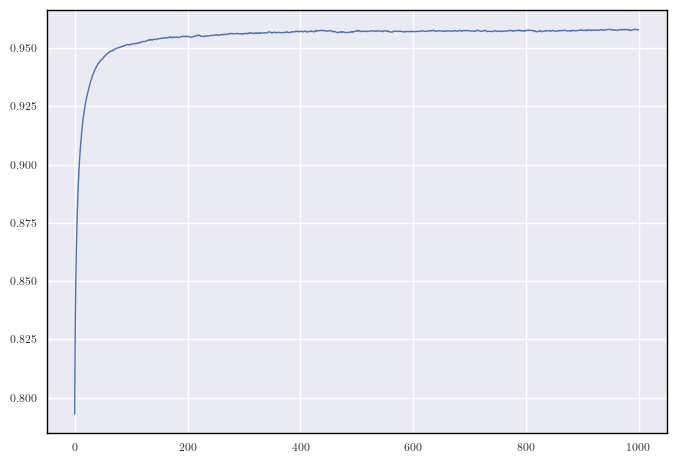

In [41]:
df_one = df_w2_1000.iloc[0].rho
df_one
plt.plot(df_one)

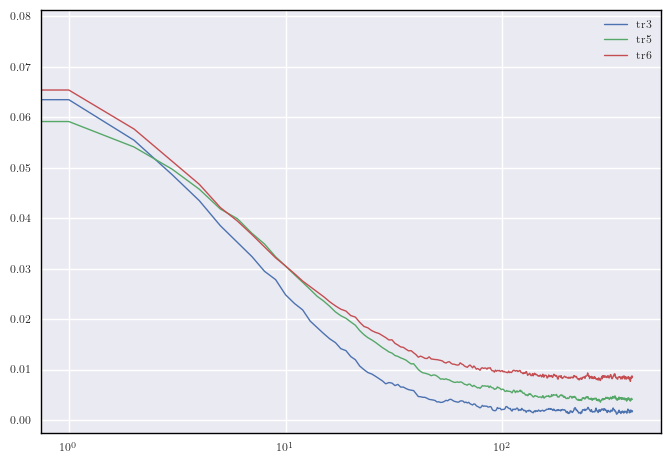

In [46]:
# df_one = df_w2.iloc[0].rho
# df_one
# plt.plot(df_one)

# plt.plot()

for triad in n1_triads:
    plt.plot(df_w2.iloc[0][triad])
    
plt.legend(n1_triads)
plt.xscale('log')

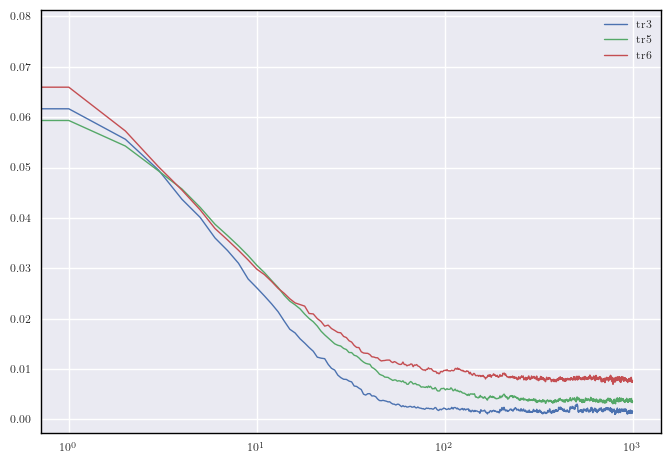

In [48]:
# df_one = df_w2.iloc[0].rho
# df_one
# plt.plot(df_one)

# plt.plot()

for triad in n1_triads:
    plt.plot(df_w2_1000.iloc[0][triad])
    
plt.legend(n1_triads)
plt.xscale('log')

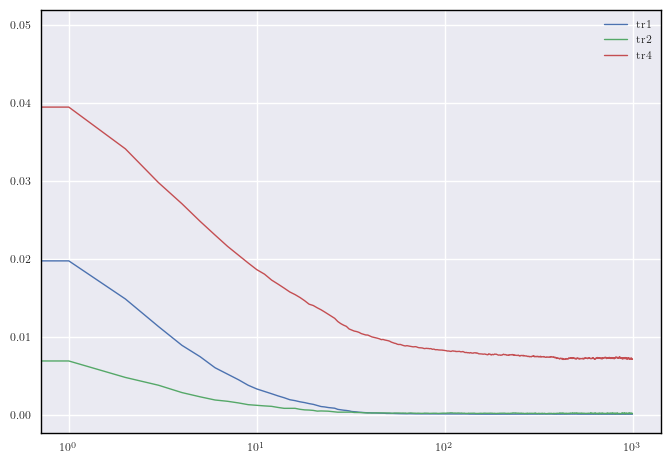

In [51]:
# df_one = df_w2.iloc[0].rho
# df_one
# plt.plot(df_one)

# plt.plot()

for triad in n2_triads:
    plt.plot(df_w2_1000.iloc[0][triad])
    
plt.legend(n2_triads)
plt.xscale('log')

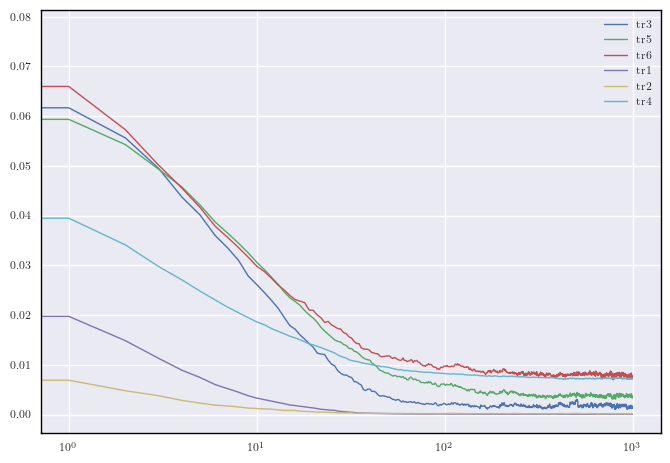

In [55]:
# df_one = df_w2.iloc[0].rho
# df_one
# plt.plot(df_one)

# plt.plot()

for triad in deg_triads:
    plt.plot(df_w2_1000.iloc[0][triad])
    
plt.legend(deg_triads)
plt.xscale('log')

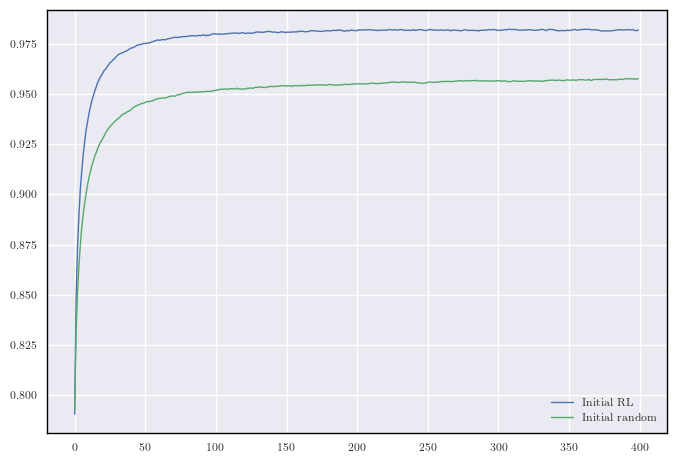

In [63]:
inds = np.where(df_w2.rho_init > 0)[0]
inds2 = np.where(df_w2.rho_init < 0)[0]

df_one = df_w2.loc[inds[0]].rho
df_one
plt.plot(df_one)
plt.plot(df_w2.loc[inds2[0]].rho)

plt.legend(["Initial RL", "Initial random"])

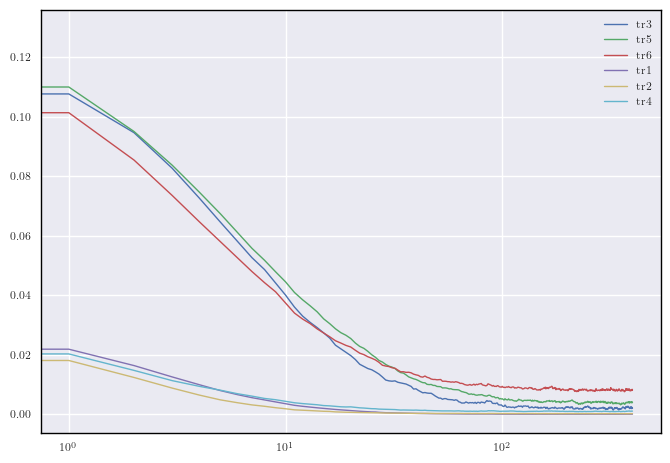

In [70]:
inds = np.where(df_w2.rho_init > 0)[0]
inds2 = np.where(df_w2.rho_init < 0)[0]

for triad in deg_triads:
    plt.plot(df_w2.loc[inds[1]][triad])
    
plt.legend(deg_triads)
plt.xscale('log')

In [51]:
wiki

,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,rho
0,0.012999,0.027805,0.010694,0.071937,0.049472,0.064931,0.078229,0.683932,0.794729


In [53]:
wiki_trans

,tr1,tr2,tr3,tr4,tr5,tr6,rho
0,-0.017263,-0.211768,0.001105,0.229031,-0.031463,0.030358,0.794729


# Checking strange result of transformed error functions. 

Eg when q=0 or q=1

In [89]:
df2_w1000_g.columns

Index(['q', 'p', 'ps', 'repetitions', 'rho_lvl', 'rho_lvl_std',
       'rho_lvl_valid', 'rho_lvl2', 'rho_lvl2_std', 'rho_lvl2_valid',
       'rho_lvl_exp', 'tr_valid', 'tr0_lvl', 'tr0_lvl_std', 'tr1_lvl',
       'tr1_lvl_std', 'tr2_lvl', 'tr2_lvl_std', 'tr3_lvl', 'tr3_lvl_std',
       'tr4_lvl', 'tr4_lvl_std', 'tr5_lvl', 'tr5_lvl_std', 'tr6_lvl',
       'tr6_lvl_std', 'tr7_lvl', 'tr7_lvl_std', 'rho', 'tr0', 'tr1', 'tr2',
       'tr3', 'tr4', 'tr5', 'tr6', 'tr7', 'closest_to_rho',
       'closest_to_high_underrepresentation',
       'closest_to_high_underrepresentation_transformed',
       'closest_to_four_triads', 'closest_to_four_triads_transformed',
       'closest_to_six_triads', 'closest_to_six_triads_transformed',
       'closest_to_six_triads_corrdevs_transformed',
       'closest_to_four_triads_corrdevs_transformed',
       'closest_to_six_triads_rho', 'closest_to_six_triads_rho_transformed',
       'closest_to_four_triads_rho', 'closest_to_four_triads_rho_transformed'],
      d

In [94]:
triad_lbs = []
for triad in deg_triads:
    triad_lbs.append(triad + "_lvl")

df2_w1000_g.loc[(0., 1., 0.5)][triad_lbs]

tr3_lvl    0.006883
tr5_lvl    0.013687
tr6_lvl    0.015746
tr1_lvl    0.000160
tr2_lvl    0.001274
tr4_lvl    0.006462
Name: (0.0, 1.0, 0.5), dtype: float64

In [100]:
df2_w1000_g.loc[(0., 1., 0.5)][deg_triads]

tr3    0.006883
tr5    0.013687
tr6    0.015746
tr1    0.000160
tr2    0.001274
tr4    0.006462
Name: (0.0, 1.0, 0.5), dtype: float64

In [107]:
# a = transform_data(df2_w1000_g.loc[(0., 1., 0.5)], triads_groups=(n1_triads, n2_triads))
df2_w1000_g_trans.loc[(0., 1., 0.5)][deg_triads]

tr3    0.006883
tr5    0.013687
tr6    0.015746
tr1    0.000160
tr2    0.001274
tr4    0.006462
Name: (0.0, 1.0, 0.5), dtype: float64

In [136]:
i_l = np.where(df2_w1000_g_trans['rho_lvl'] != df2_w1000_g['rho_lvl'])[0]

df2_w1000_g_trans.iloc[i_l]

q    p    ps  repetitions  rho_lvl  rho_lvl_std  \
1.0 0.5 0.40  1.0  0.5  0.40            1      NaN          NaN   
        0.45  1.0  0.5  0.45            1      NaN          NaN   
        0.55  1.0  0.5  0.55            1      NaN          NaN   
        0.70  1.0  0.5  0.70            1      NaN          NaN   

              rho_lvl_valid  rho_lvl2  rho_lvl2_std  rho_lvl2_valid  ...  \
1.0 0.5 0.40              0       NaN           NaN               0  ...   
        0.45              0       NaN           NaN               0  ...   
        0.55              0       NaN           NaN               0  ...   
        0.70              0       NaN           NaN               0  ...   

              tr6_lvl_std   tr7_lvl  tr7_lvl_std  rho       tr1           tr2  \
1.0 0.5 0.40          0.0  0.004639          0.0  NaN  0.083326  8.699612e-03   
        0.45          0.0       NaN          NaN  NaN  0.169760  3.071301e-02   
        0.55          0.0  0.943591          0.0  NaN  0.005186  3.999308e-05   
        0.70          0.0  0.984968          0.0  NaN  0.000829  1.059513e-07   

                   tr3       tr4       tr5       tr6  
1.0 0.5 0.40       NaN  0.036481  0.000348  0.024119  
        0.45       NaN  0.136467  0.007304  0.097028  
        0.55  0.019391  0.000537  0.003382  0.020188  
        0.70  0.002794  0.000162  0.000093  0.011131  

[4 rows x 35 columns]

In [143]:
df_w1000_trans.columns, df_w1000.columns

(Index(['index', 'q', 'p', 'ps', 'rho_init', 'steps', 'cur_steps', 'rho', 'tr1',
        'tr2', 'tr3', 'tr4', 'tr5', 'tr6', 'Lplus'],
       dtype='object'),
 Index(['index', 'q', 'p', 'ps', 'rho_init', 'steps', 'cur_steps', 'rho', 'tr0',
        'tr1', 'tr2', 'tr3', 'tr4', 'tr5', 'tr6', 'tr7', 'Lplus'],
       dtype='object'))

In [144]:
ch_cols = ['q', 'p', 'ps', 'repetitions', 'rho_lvl', 'rho_lvl_std',
        'rho_lvl_valid', 'rho_lvl2', 'rho_lvl2_std', 'rho_lvl2_valid',
        'rho_lvl_exp', 'tr_valid', 'tr0_lvl', 'tr0_lvl_std', 'tr1_lvl',
        'tr1_lvl_std', 'tr2_lvl', 'tr2_lvl_std', 'tr3_lvl', 'tr3_lvl_std',
        'tr4_lvl', 'tr4_lvl_std', 'tr5_lvl', 'tr5_lvl_std', 'tr6_lvl',
        'tr6_lvl_std', 'tr7_lvl', 'tr7_lvl_std', 'rho', 'tr1', 'tr2', 'tr3',
        'tr4', 'tr5', 'tr6']

ch_cols2 = [ 'q', 'p', 'ps', 'rho_init', 'steps', 'cur_steps', 'rho', 'tr1',
        'tr2', 'tr3', 'tr4', 'tr5', 'tr6', 'Lplus']

df2_w1000_g[ch_cols].equals(df2_w1000_g_trans[ch_cols]), df_w1000[ch_cols2].equals(df_w1000_trans[ch_cols2])

(True, False)

In [168]:
t_trans = transform_data(df2_w1000_g, triads_groups = (n1_triads, n2_triads))

df2_w1000_g[ch_cols].equals(t_trans[ch_cols])

# type(df2_w1000_g) == pd.DataFrame

# t_trans = df2_w1000_g.copy(deep=True)
# triads = n1_triads
# nn = transform_data(df2_w1000_g, triads)
# nn = nn.transpose()
# nn
# new_df = pd.DataFrame(nn, index = t_trans.index, columns=triads)
# new_df
# t_trans.update(new_df)

# df2_w1000_g[ch_cols].equals(t_trans[ch_cols])
# np.min(t_trans.tr3), np.min(new_df.tr3)

False

In [165]:
new_df.columns, t_trans.columns
new_df
t_trans.index

MultiIndex([( 0.0,  0.7,  0.5),
            ( 0.0, 0.75,  0.5),
            ( 0.0,  0.8,  0.5),
            ( 0.0,  0.9,  0.5),
            ( 0.0,  1.0,  0.5),
            ( 0.1,  0.7,  0.0),
            ( 0.1,  0.7,  0.1),
            ( 0.1,  0.7,  0.2),
            ( 0.1,  0.7,  0.3),
            ( 0.1,  0.7,  0.4),
            ...
            (0.95,  0.9, 0.45),
            (0.95,  1.0,  0.4),
            (0.95,  1.0, 0.45),
            ( 1.0,  0.5,  0.3),
            ( 1.0,  0.5,  0.4),
            ( 1.0,  0.5, 0.45),
            ( 1.0,  0.5,  0.5),
            ( 1.0,  0.5, 0.55),
            ( 1.0,  0.5,  0.6),
            ( 1.0,  0.5,  0.7)],
           length=615)

In [90]:
df2_w1000_g.loc[(0., 1., 0.5)][error_functions_names]

closest_to_rho                                     0.029148
closest_to_high_underrepresentation                0.000089
closest_to_high_underrepresentation_transformed    0.045173
closest_to_four_triads                             0.007320
closest_to_four_triads_transformed                 0.047704
closest_to_six_triads                              0.013444
closest_to_six_triads_transformed                  0.098376
closest_to_six_triads_corrdevs_transformed         1.047704
closest_to_four_triads_corrdevs_transformed        1.047704
closest_to_six_triads_rho                          0.159186
closest_to_six_triads_rho_transformed              0.156672
closest_to_four_triads_rho                         0.153062
closest_to_four_triads_rho_transformed             0.106000
Name: (0.0, 1.0, 0.5), dtype: float64

In [81]:
df2_w1000_g.loc[(0., 1., 0.5)]

q                                                  0.000000
p                                                  1.000000
ps                                                 0.500000
repetitions                                        1.000000
rho_lvl                                            0.965458
rho_lvl_std                                        0.000000
rho_lvl_valid                                      1.000000
rho_lvl2                                           0.965458
rho_lvl2_std                                       0.000000
rho_lvl2_valid                                     1.000000
rho_lvl_exp                                             NaN
tr_valid                                           1.000000
tr0_lvl                                            0.000076
tr0_lvl_std                                        0.000000
tr1_lvl                                            0.000160
tr1_lvl_std                                        0.000000
tr2_lvl                                 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbf4a1648b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbf4a1693a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbf4a164220>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbf4a1697c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbf4a169a60>],
 'means': []}

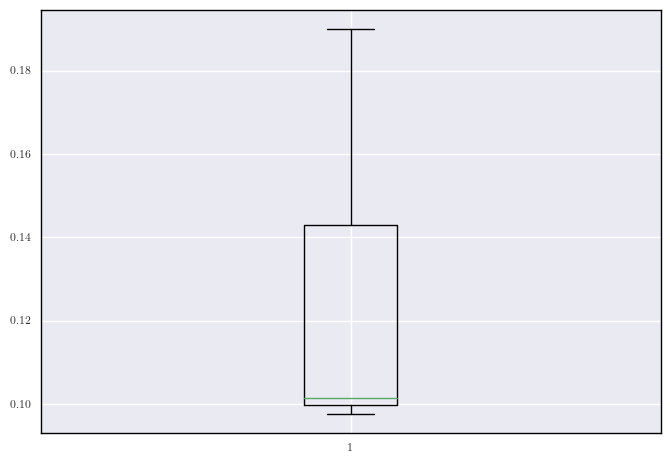

In [91]:
plt.boxplot(df2_w1000_g.closest_to_six_triads_transformed)